In [1]:
import warnings
from pprint import pprint

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch

Распределите в команде гпу, задайте свой номер.

In [3]:
cuda_device = 1

Импортируем полезную либу `attrdict`. Чем она хороша: позволяет обращаться к элементам словаря, как к его атрибутам

In [4]:
from attrdict import AttrDict

# Работа с аудио и текстом

В распознавании речи нейронная сеть обучается на парах аудио+текст.

Давайте научимся открывать аудиофайлы и подготавливать их для работы с нейронной сетью.



На лекциях мы обсуждали, что аудио может быть записано с разной частотой дискретизации (sample rate), но для обучения нейронной сети обычно все аудио приводят к одной частоте дискретизации. (В этом проекте мы будем использовать sample rate 8000).

Так же аудио может быть одноканальным или многоканальным. Проблема с многоканальным аудио может быть в том, что речь в двух каналах может звучать одновременно, такие аудио надо разделять на 2 дорожки. В нашем же случае данные подобраны таким образом, что такой ситуации не возникет, поэтому несколько каналов можно просто усреднить.


Будем использовать библиотеку `torchaudio` [docs](https://pytorch.org/audio/).

Реализуйте функцию `open_audio`, которая открывает аудио (искать [тут](https://pytorch.org/audio/stable/torchaudio.html)), усредняет аудио по всем каналам (это можно сделать обычным усреднением) и приводит к необходимой частоте дискретизации (искать [тут](https://pytorch.org/audio/stable/transforms.html)).

In [5]:
import torchaudio

In [6]:
import numpy as np
import torch

In [7]:
file = "test_files/test_audio.mp3"

In [8]:
def open_audio(audio_path, desired_sample_rate):
    
    """ Open and resample audio, average across channels
        Inputs:
            audio_path: str, path to audio
            desired_sample_rate: int, the sampling rate to which we would like to convert the audio
        Returns:
            audio: 1D tensor with shape (num_timesteps)
            audio_len: int, len of audio
    """
    
    audio_tensor = torchaudio.load(audio_path)
    orig_freq = audio_tensor[1]
    audio = torchaudio.transforms.Resample(orig_freq, desired_sample_rate).forward(audio_tensor[0])
    audio = torch.transpose(audio, 0 , 1)
    audio = torch.mean(audio, axis=1)
    audio_len = audio.shape[0]
    
    ### write your code here ###
    
    return audio, audio_len


Запустите тесты, чтобы проверить себя.
<img src="images/tests_are_all_we_need.png" width="400" height="600">


**Перед каждым запуском тестов не забывайте сохранять ноутбук.**

In [9]:
! pytest tests/test_open_audio.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 2 items                                                              

tests/test_open_audio.py ..                                              [100%]

============================== 2 passed in 2.10s ===============================


Теперь давайте откроем аудио, и послушаем, что у нас получилось.

In [10]:
from IPython.display import Audio

In [11]:
sample_rate=8000
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

Так же послушать аудио можно через путь к аудио файлу.

Можно заметить, что звучание немного поменялось. Это произошло из-за того, что мы поменяли оригинальный sample rate 48000Hz на 8000Hz.

In [12]:
Audio('test_files/test_audio.mp3')

Speech2text  —  это не только speech, но и text, поэтому теперь давайте поговорим о предобработке текста. 

Первым шагом необходимо привести текст к нижнему регистру и удалить пунктуацию. Если на этом этапе в тексте содержатся символы кроме русского алфавита и пробела (например, цифры), то такие примеры лучше вообще убрать из обучающей выборки (если просто убрать символ из строки, то может нарушиться соответствие аудио-текст).

В размеченных данных для обучения и валидации уже произедена очистка и удаление ненужных символов, поэтому нам надо только извлечь токены из текста.

В качестве токенов для обучения нейронной сети будем использовать буквы русского алфавита и пробел. Так же, как было сказано в лекциях, нам потребуется специальный символ `<blank>` для построения выравниваний.

In [13]:
alphabet = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к',
            'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц',
            'ч', 'ш', 'щ', 'ь', 'ы', 'ъ', 'э', 'ю', 'я',
            ' ', '<blank>']

Но, естественно, в таком виде передавать буквы в нейронную сеть мы не можем — их нужно закодировать в числа. Для этого будем использовать уже готовую функцию Vocab.

Обратите внимание, что Vocab добавляет дополнительный токен `<unk>`, ответственный за все символы, которых нет в словаре.

In [14]:
from vocabulary import Vocab
vocab = Vocab(alphabet)

The `unk_token` '<unk>' wasn't found in the tokens. Adding the `unk_token` to the end of the Vocab.


Попрактикуйтесь с Vocab. Для того, чтобы понять все возможности Vocab можно заглянуть в код vocabulary.py и почитать докстринги.

* переведите "привет" в индексы
* переведите [11, 0, 11, 33, 4, 5, 12, 0] в текст
* что будет если перевести в индексы слово "hi"?
* а [44, 5] в текст?


In [15]:
vocab.lookup_indices('привет')

[16, 17, 9, 2, 5, 19]

In [16]:
vocab.lookup_tokens([11, 0, 11, 33, 4, 5, 12, 0] )

['к', 'а', 'к', ' ', 'д', 'е', 'л', 'а']

In [17]:
vocab.lookup_indices('hi')

[35, 35]

In [18]:
vocab.lookup_tokens([44, 5] )

RuntimeError: Specified index 44 is out of bounds of the size of itos dictionary: 36.

Какие еще у Vocab возможности?

Если в процессе исследования вы изменили текущий vocab (путем добавления нового токена, например), не забудьте вернуть vocab к начальному состоянию  `vocab = Vocab(alphabet)`

In [19]:
vocab.append_token('i')

In [20]:
vocab = Vocab(alphabet)

Давайте извлечем из Vocab и сохраним в переменные два важных значения - длину алфавита и значения индекса `<blank>`.
    
Эти значения нам еще много раз пригодятся.

In [21]:
def get_num_tokens(vocab):
    ### write your code here ###
    num_tokens= vocab.__len__()
    return num_tokens

def get_blank_index(vocab):
    vocab.append_token('<blank>')
    blank_index = vocab.__getitem__('<blank>')
    return blank_index

In [22]:
! pytest tests/test_num_tokens.py
! pytest tests/test_blank_index.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_num_tokens.py .                                               [100%]

============================== 1 passed in 1.95s ===============================
Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_blank_index.py .                                              [100%]

============================== 1 passed in 1.98s ===============================


In [23]:
num_tokens = get_num_tokens(vocab) 
blank_index = get_blank_index(vocab)

# Подготовка датасета

Обучать нейронную сеть мы будем на подготовленном датасете. Для удобства мы сгруппировали обучающие и валидационные данные в текстовые файлы, где в каждой строке через запятую указан путь к файлу, соответствующий текст, длина аудио (в секундах).


Давайте реализуем функцию AudioDataset, которая подготавливает текст и аудио для каждого элемента датастета.


На этих данных мы будем обучать модель с помощью ctc лосса, а мы уже знаем, что для обучения с ctc аудио лучше отсортировать по длине - так модели будет проще обучиться.

Изучить документацию по Dataset и DataLoader (пригодится далее) можно найти [тут](https://pytorch.org/docs/stable/data.html).

In [24]:
import pandas as pd

In [25]:
 class AudioDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_path,
                 vocab,
                 sample_rate=8000,
                 ):
        self.vocab = vocab
        self.sample_rate = sample_rate
        data = pd.read_csv(dataset_path, header=None, names=['audio_path', 'text', 'duration'])
        data['duration'] = data['duration'].astype(float)
        self.data = data.sort_values(by='duration')

    def __len__(self):
        
        return self.data.shape[0]


    def __getitem__(self, idx):
        audio_path = self.data.audio_path[idx]
        text = self.data.text[idx]
        text_len = len(text)
        
        audio, audio_len = open_audio(audio_path, self.sample_rate)
        tokens = torch.tensor(self.vocab.lookup_indices(text))
        
        ### write your code here ###
        
        return {"audio":  audio,  # torch tensor, (num_timesteps)
                "audio_len": audio_len, # int
                "text": text, # str
                "text_len": text_len, # int
                'tokens': tokens, # torch tensor, (text_len)
               }

In [26]:
dataset = AudioDataset("test_files/test_dataset.txt", vocab)

In [27]:
dataset.__getitem__(0)

{'audio': tensor([-6.1978e-10, -1.9903e-09, -2.2880e-09,  ..., -1.7954e-03,
         -3.6443e-04,  2.6201e-03]),
 'audio_len': 39168,
 'text': 'тестовое аудио',
 'text_len': 14,
 'tokens': tensor([19,  5, 18, 19, 15,  2, 15,  5, 33,  0, 20,  4,  9, 15])}

In [28]:
! pytest tests/test_dataset.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 2 items                                                              

tests/test_dataset.py ..                                                 [100%]

============================== 2 passed in 2.21s ===============================


Давайте посмотрим, как будут выглядеть элементы полученного датасета.

In [29]:
train_dataset = '/home/e.chuykova/data/train.txt'
val_dataset = '/home/e.chuykova/data/val.txt'
test_dataset = '/home/e.chuykova/data/test.txt'

In [30]:
dataset = AudioDataset(train_dataset, vocab)

for i, element in enumerate(dataset):
    print(f'element number: {i}')
    pprint(element)
    print()
    if i > 1:
        break

element number: 0
{'audio': tensor([ 0.0000,  0.0000,  0.0000,  ...,  0.0005, -0.0008, -0.0006]),
 'audio_len': 8360,
 'text': 'один',
 'text_len': 4,
 'tokens': tensor([15,  4,  9, 14])}

element number: 1
{'audio': tensor([-1.3758e-09, -2.2855e-09, -1.3640e-09,  ..., -2.1114e-04,
        -4.1249e-04, -2.6402e-04]),
 'audio_len': 8640,
 'text': 'ноль',
 'text_len': 4,
 'tokens': tensor([14, 15, 12, 27])}

element number: 2
{'audio': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0068, 0.0080, 0.0038]),
 'audio_len': 8987,
 'text': 'два',
 'text_len': 3,
 'tokens': tensor([4, 2, 0])}



Чтобы эффективно обучать нейронную сеть, необходимо подавать в нее данные батчами. В этом нам поможет функция `torch.utils.data.DataLoader`. 

Обратите внимание, что некоторые данные в датасете разной длины (например, `audio`), для формирования батча из таких данных  необходимо использовать паддинг. Для этого можно реализовать фукцию `collate_fn`. Подробнее про то, как именно использовать `collate_fn` можно почитатать в доках к `torch.utils.data.DataLoader`.

In [31]:
from torch.nn.utils.rnn import pad_sequence

In [32]:
def collate_fn(batch):
    """ 
        Inputs:
            batch: list of elements with length=batch_size
        Returns:
            dict
    """
    batch_size = len(batch)
    
    ### write your code here ###
    audios = []
    audio_lens = []
    texts = []
    text_lens = []
    tokens = []
    
    for el in batch:
        audios.append(el['audio'])
        audio_lens.append(el['audio_len'])
        texts.append(el['text'])
        text_lens.append(el['text_len'])
        tokens.append(el['tokens'])
        
    audios = pad_sequence(audios, batch_first=True)
    audio_lens = torch.tensor(audio_lens)
    text_lens = torch.tensor(text_lens)
    tokens = pad_sequence(tokens, batch_first=True)

    return {'audios': audios, # torch tensor, (batch_size, max_num_timesteps)
            'audio_lens': audio_lens, # torch tensor, (batch_size)
            'texts': texts,  # list, len=(batch_size)
            "text_lens": text_lens, # torch tensor, (batch_size)
            'tokens': tokens,  # torch tensor, (batch_size, max_text_len)
           }


In [33]:
! pytest tests/test_collate_fn.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_collate_fn.py .                                               [100%]

============================== 1 passed in 2.06s ===============================


In [34]:
batch_size = 90
num_workers = 8

При создании DataLoader не забудьте использовать параметры `batch_size`, `num_workers`.

Так же в DataLoader есть параметр `shuffle`, который используется для перемешивания данных. Сейчас наши аудио отсортированы по длине, т.е. длины аудио внутри одного батча максимально близки друг другу - и это самый эффективный способ формировать батчи в распознавании речи. Если включить shuffle=True, то короткие аудио могут попасть в один батч с длинными, средний размер батча увеличится, это будет менее эффективно. Поэтому необходимо **перемешивать сформированные батчи**, а не элементы датасета.
    
Реализовать перемешивание батчей в PyTorch - это не самая простая задача, поэтому советую сейчас пропустить этот шаг.

In [35]:
train_audiodataset = AudioDataset(train_dataset, vocab)
train_dataloader = torch.utils.data.DataLoader(train_audiodataset, batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
val_audiodataset = AudioDataset(val_dataset, vocab)
val_dataloader = torch.utils.data.DataLoader(val_audiodataset, batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

Давайте посмотрим, что у нас хранится в даталоадере. Обратите внимание, что из-за `batch_size=90` выведется достаточно много значений. Можно уменьшить `batch_size`, чтобы посмотреть на выход, но обучать сеть лучше с `batch_size=90`.

In [36]:
for i, element in enumerate(train_dataloader):
    print(f'element number: {i}')
    pprint(element)
    print()
    if i > 0:
        break

element number: 0
{'audio_lens': tensor([ 8360,  8640,  8987,  9196,  9196,  9405,  9405,  9600,  9823, 10032,
        10176, 10176, 10368, 10449, 10560, 10560, 10560, 10560, 10560, 10560,
        10560, 10560, 10560, 10560, 10658, 10752, 10752, 11136, 11136, 11136,
        11136, 11285, 11328, 11328, 11520, 11520, 11520, 11520, 11520, 11520,
        11520, 11520, 11712, 11712, 11712, 11712, 11703, 11904, 11904, 11904,
        12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096,
        12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096,
        12096, 12288, 12288, 12288, 12288, 12288, 12330, 12480, 12480, 12480,
        12480, 12480, 12480, 12480, 12480, 12480, 12480, 12480, 12480, 12480]),
 'audios': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3758e-09, -2.2855e-09, -1.3640e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00

# Акустические фичи

Как мы обсуждали на лекциях, есть разные способы построить аудио фичи. Мы будем использовать log mel spectrogram.


In [37]:
def compute_log_mel_spectrogram(audio, sequence_lengths,
                            sample_rate=8000,
                            window_size=0.02,
                            window_step=0.01,
                            f_min=20,
                            f_max=3800,
                            n_mels=64,
                            window_fn=torch.hamming_window,
                            power=1.0,
                            eps=1e-6
                            ):
    """ Compute log-mel spectrogram.
        Input shape:
            audio: 3D tensor with shape (batch_size, num_timesteps)
            sequence_lengths: 1D tensor with shape (batch_size)
        Returns:
            4D tensor with shape (batch_size, n_mels, new_num_timesteps)
            1D tensor with shape (batch_size)
    """
    win_length = int(window_size * sample_rate)
    hop_length = int(window_step * sample_rate)
    n_fft = win_length
    
    log_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=win_length, 
    win_length=win_length, hop_length=hop_length, f_min=f_min, f_max=f_max,n_mels=n_mels,
                                window_fn=window_fn,power=power).forward(audio)
    log_mel_spectrogram = torch.log(log_mel_spectrogram + eps)
    
    sequence_lengths = ((sequence_lengths + 2 * hop_length - win_length) // hop_length + 1)
    
    return log_mel_spectrogram, sequence_lengths

In [38]:
audio = np.load('test_files/test_open_audio.npy')
compute_log_mel_spectrogram(torch.tensor(audio), torch.tensor(len(audio)))

(tensor([[-12.2315, -10.9659, -13.3015,  ...,  -3.6013,  -4.8720,  -5.0904],
         [-12.4047, -11.1747, -13.3853,  ...,  -3.8245,  -5.0952,  -5.3135],
         [-12.0072, -11.7247, -11.6357,  ...,  -4.0716,  -4.6618,  -3.9142],
         ...,
         [-12.0708, -10.4228, -10.2160,  ...,  -5.6175,  -5.3217,  -5.0717],
         [-11.8664, -10.8963,  -9.9737,  ...,  -5.6028,  -6.0899,  -6.1541],
         [-11.9398, -10.9734, -10.0810,  ...,  -6.2699,  -6.6645,  -6.2696]]),
 tensor(257))

In [39]:
! pytest tests/test_compute_log_mel_spectrogram.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_compute_log_mel_spectrogram.py .                              [100%]

============================== 1 passed in 2.02s ===============================


Давайте посмотрим, как выглядит log-mel спектрограмма.

In [40]:
import matplotlib.pyplot as plt

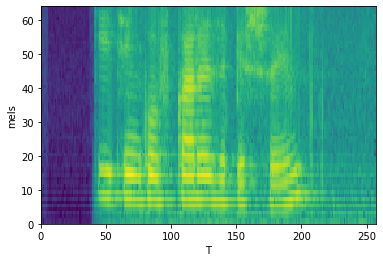

In [41]:
audio, audio_len = open_audio('test_files/test_audio.opus', 8000)
spectrogram, new_len = compute_log_mel_spectrogram(audio, audio_len)
plt.pcolormesh(spectrogram)
plt.xlabel('T')
plt.ylabel('mels')
plt.show()
Audio(data=audio.numpy(), rate=sample_rate)

# Нейронная сеть

Мы подготовили все данные, теперь можно заняться реализацией нейронной сети. Будем реализовывать архитектуру [Deepspeech 2](https://arxiv.org/pdf/1512.02595.pdf) в немного упрощенном виде.


<img src="images/cat_reproduction.jpg" width="400" height="400">


Вот так будет выглядеть архитектура сети:


<img src="images/deepspeech.jpg" width="200" height="150">

In [42]:
import torch.nn as nn
import torch.nn.functional as F

In [43]:
class Model(nn.Module):
    def __init__(self, num_mel_bins, hidden_size, num_layers, num_tokens):
        super(Model, self).__init__()

        conv1_params = AttrDict(
            {
                "num_filters": 32,
                "kernel_size": [21, 11],
                "stride": [1, 1] 
            })                             
        conv2_params = AttrDict(
            {
                "num_filters": 64,
                "kernel_size": [11, 11],
                "stride": [1, 3]
            }
        )
        
        self.conv1_params = conv1_params
        self.conv2_params = conv2_params

        self.conv = nn.Sequential(
            nn.Conv2d(
            in_channels=1,
            out_channels=conv1_params.num_filters,
            kernel_size=conv1_params.kernel_size,
            stride=conv1_params.stride,
            bias=False),
            nn.BatchNorm2d(conv1_params.num_filters,
                          momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv1_params.num_filters,
            out_channels=conv2_params.num_filters,
            kernel_size=conv2_params.kernel_size,
            stride=conv2_params.stride,
            bias=False),
            nn.BatchNorm2d(conv2_params.num_filters,
                          momentum=0.9),
            nn.ReLU()
            # CONV 1
            # BATCH NORM 1
            # RELU
            # CONV 2
            # BATCH NORM 2
            # RELU
        )

        
        rnn_input_size = (num_mel_bins - conv1_params.kernel_size[0]) // conv1_params.stride[0] + 1
        rnn_input_size = (rnn_input_size - conv2_params.kernel_size[0]) // conv2_params.stride[0] + 1
        rnn_input_size *= conv2_params.num_filters

        # 4 слоя бидир lstm
        self.lstm = nn.LSTM(input_size=rnn_input_size,
               hidden_size=hidden_size,
               num_layers=num_layers,
               bidirectional=True,
               batch_first=True) 
        
        
        self.output_layer = nn.Linear(in_features=hidden_size * 2,
                                      out_features=num_tokens) # YOUR CODE

    def forward(self, inputs, seq_lens, state=None):
        """
            Input shape:
                audio: 3D tensor with shape (batch_size, num_mel_bins, num_timesteps)
                sequence_lengths: 1D tensor with shape (batch_size)
            Returns:
                3D tensor with shape (new_num_timesteps, batch_size, alphabet_len)
                1D tensor with shape (batch_size)
            """
        
        outputs = inputs.unsqueeze(1) # conv2d input should be four-dimensional
        outputs = Model.transpose_and_reshape(self.conv(outputs))
        outputs, hidden = self.lstm(outputs)
        outputs = self.output_layer(outputs)
        outputs = torch.transpose(outputs, 0, 1)


        seq_lens = self.get_new_seq_lens(seq_lens,
                                         self.conv1_params.kernel_size[1], self.conv1_params.stride[1],
                                         self.conv2_params.kernel_size[1], self.conv2_params.stride[1])
        
        return F.log_softmax(outputs, dim=-1), seq_lens

    @staticmethod
    def transpose_and_reshape(inputs):
    
        """ This function will be very useful for converting the output of a convolutional layer 
            to the input of a lstm layer
            
            Input shape:
                inputs: 4D tensor with shape (batch_size, num_filters, num_features, num_timesteps)
            Returns:
                3D tensor with shape (batch_size, num_timesteps, new_num_features)
            """
            
        sizes = inputs.size()
                
        # reshape # YOUR CODE
        
        outputs = torch.reshape(inputs, (sizes[0], sizes[1] * sizes[2], sizes[3]))
        # (batch_size, num_filters * num_features, num_timesteps)
        
        # transpose # YOUR CODE
        
        # (batch_size, num_timesteps, new_num_features)
        
        outputs = torch.transpose(outputs, 2, 1)
        
        return outputs
           
    @staticmethod
    def get_new_seq_lens(seq_lens, conv1_kernel_size, conv1_stride, conv2_kernel_size, conv2_stride):
    
        """ Compute sequence_lengths after convolutions
            """
        seq_lens = (seq_lens - conv1_kernel_size) // conv1_stride + 1
        seq_lens = (seq_lens - conv2_kernel_size) // conv2_stride + 1
        return seq_lens

In [44]:
num_mel_bins = 64
hidden_size= 512
num_layers = 4

In [45]:
model = Model(num_mel_bins=num_mel_bins,
              hidden_size=hidden_size,
              num_layers=num_layers,
              num_tokens=num_tokens)

In [46]:
model = Model(num_mel_bins=64, hidden_size=512, num_layers=4, num_tokens=35)
outputs, seq_lens = model(torch.rand([3, 64, 1000]), torch.tensor([1000, 555, 900]))

In [47]:
outputs.shape

torch.Size([327, 3, 35])

In [48]:
! pytest tests/test_model.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 5 items                                                              

tests/test_model.py .....                                                [100%]

============================== 5 passed in 3.59s ===============================


Инициализируем модель из чекпоинта, чтобы она обучилась быстрее.

In [49]:
def load_from_ckpt(model, ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

In [50]:
load_from_ckpt(model, '/home/e.chuykova/data/ckpt.pt')

Тест, чтобы проверить, что код модели корректно написан, модель правильно восстановилась из чекпоинта

In [51]:
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
output = model(*compute_log_mel_spectrogram(torch.unsqueeze(audio, 0), torch.unsqueeze(torch.tensor([audio_len]), 0)))
assert torch.isclose(output[0][0][0][0], torch.tensor(-3.53916406))
assert torch.isclose(output[0][15][0][30], torch.tensor(-3.605963468))

Отправим модель на гпу.

<img src="images/cuda_is_important.jpg" width="400" height="400">


In [52]:
model.cuda(cuda_device)

Model(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(21, 11), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(11, 11), stride=(1, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (lstm): LSTM(2176, 512, num_layers=4, batch_first=True, bidirectional=True)
  (output_layer): Linear(in_features=1024, out_features=35, bias=True)
)

# Обучаем модельку

In [53]:
from time import time
from tqdm import tqdm_notebook as tqdm
import os

Давайте напишем несколько вспомогательных функций, которые будут нам нужны для обучения модели.

Для начала займемся метриками. Основная метрика - wer (word error rate).

Тут поможет библиотека `editdistance`.

In [54]:
import editdistance

In [55]:
def calc_wer(predicted_text, gt_text):
    """ Compute wer.
        Inputs:
            predicted_text: str
            gt_text: str
        Returns:
            wer: int
    """
    predicted_text = predicted_text.split()
    gt_text = gt_text.split()
    wer = editdistance.eval(predicted_text, gt_text)
    if len(gt_text) == 0:
        if wer > 0:
            return 1.0
        else:
            return 0
    return wer / len(gt_text)


def calc_wer_for_batch(list_of_predicted_text, list_of_gt_text):
    """ Compute mean wer for batch.
            Inputs:
                list_of_predicted_text: list
                list_of_gt_text: list
            Returns:int
            
    """
    mean_wer = np.mean([calc_wer(a, b) for (a, b) in zip(list_of_predicted_text, list_of_gt_text)])
        
    return mean_wer

In [56]:
! pytest tests/test_compute_wer.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 7 items                                                              

tests/test_compute_wer.py .......                                        [100%]

============================== 7 passed in 2.01s ===============================


Давайте реализуем greedy decoding. 

Сначала научимся получать greedy trn из выравниваний. Можно использовать `itertools`.

Не забудьте выкинуть лишние пробелы в начале и конце полученного текста!

In [57]:
import itertools

In [58]:
def decode(alignment):
    """ Get text from alignment.
        Inputs:
            alignment: str
        Returns:
            text: srt
    """
    prev = '+'
    text = ""
    for c in alignment:
        if c ==prev:
            continue
        text += c
        prev = c
    text = text.replace("<blank>", "")
    text = text.strip()
    return text

In [59]:
! pytest tests/test_decode.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 4 items                                                              

tests/test_decode.py ....                                                [100%]

============================== 4 passed in 2.00s ===============================


Получим greedy text из выхода акустической модели (logprobs).

In [60]:
def get_prediction(logprobs, logprobs_lens, vocab):
    """ Compute greedy text from loglikes.
            Input shape:
                logprobs: 3D tensor with shape (num_timesteps, batch_size, alphabet_len)
                logprobs_lens: 1D tensor with shape (batch_size)
            Returns:
                list of texts with len (batch_size)
        """
    logprobs = torch.transpose(logprobs, 0,1)
    pprint(logprobs)
    prediction = []
    tokens = []
    for instance in logprobs:
        for arr in instance:
            tokens.append(int(np.argmax(arr)))
        text = "".join(vocab.lookup_tokens(tokens))
        text = decode(text)
        prediction.append(text)
    return prediction

In [61]:
! pytest tests/test_get_prediction.py

Don't forget to save Jupyter Notebook! 


============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/polina/sirius-stt, configfile: pytest.ini
collected 1 item                                                               

tests/test_get_prediction.py .                                           [100%]

============================== 1 passed in 2.02s ===============================


В этой функции надо из сырых данных, извлеченных из датасета, получить спектрограмму, прогнать через модель, посчитать средний лосс и wer для батча, list с текстами предсказанных гипотез для батча.

In [62]:
def get_model_results(model, audio, audio_lens, tokens, text, text_lens, vocab, loss_fn):
    """ get mean loss, mean wer and prediction list for batch
        Returns:
            loss: int
            wer: int
            prediction: list of str
            
    """
    
    log_mel_spec, seq_lens = compute_log_mel_spectrogram(audio, audio_lens)
    logprobs, logprobs_lens = model.forward(log_mel_spec.cuda(cuda_device), seq_lens.cuda(cuda_device))
    
    prediction = get_prediction(logprobs.detach().cpu(), logprobs_lens.detach().cpu(), vocab)
    
    wer = calc_wer_for_batch(prediction, text)
    
    loss = loss_fn(logprobs, tokens.cuda(cuda_device), logprobs_lens.long(), text_lens.long().cuda(cuda_device))
    
    return loss, wer, prediction

Для удобства будем логировать метрики в [tensorboard](https://pytorch.org/docs/stable/tensorboard.html).

In [63]:
from torch.utils.tensorboard import SummaryWriter

In [64]:
class TensorboardLogger:
    def __init__(self, tensorboard_path):
        self.writer = SummaryWriter(tensorboard_path)

    def log(self, step, loss, wer, mode):
        assert mode in ('train', 'val')
        
        self.writer.add_scalar('Loss/' + mode, loss, step)
        self.writer.add_scalar('Wer', wer, step)
        
        # add loss to tb 
        # add wer to tb 

    def log_text(self, step, pred_texts, gt_texts, mode):
        
        ### write your code here ###
        
        for pred_text in pred_texts:
            self.writer.add_text('Predicted text', pred_text, step) 
            # add pred text to tb 
            
        for gt_text in gt_texts:
            self.writer.add_text('Ground true text', gt_text, step) 
            # add gt text to tb 
      

    def close(self):
        self.writer.close()

Теперь можем собрать функции в train loop. 

In [65]:
def training(model, optimizer, loss_fn, num_epochs, train_dataloader, val_dataloader, log_every_n_batch, model_dir,
             vocab):

    logger = TensorboardLogger(model_dir)

    for epoch in range(num_epochs):

        start_time = time()
        train_loss, train_wer = 0, 0
        model.train(True)

        for iteration, batch in enumerate(tqdm(train_dataloader)):
            loss, wer, prediction = get_model_results(model, batch["audios"], batch["audio_lens"],
                                                      batch["tokens"], batch["texts"],
                                                      batch["text_lens"], vocab, loss_fn)



            # optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
             
             
            

            train_loss += loss.cpu().data.numpy()
            train_wer += wer

            step = len(train_dataloader) * epoch + iteration
            if step % log_every_n_batch == 0:
                logger.log(step, loss, wer, 'train')
                logger.log_text(step, prediction, batch["texts"], "train")

        train_loss /= len(train_dataloader)
        train_wer /= len(train_dataloader)

        val_loss, val_wer = 0, 0
        model.train(False)

        for batch in tqdm(val_dataloader):
            loss_val, wer, prediction = get_model_results(model, batch["audios"], batch["audio_lens"],
                                                          batch["tokens"], batch["texts"],
                                                          batch["text_lens"], vocab, loss_fn)
            val_loss += loss_val.cpu().data.numpy()
            val_wer += wer

        val_loss /= len(val_dataloader)
        val_wer /= len(val_dataloader)

        logger.log(step, val_loss, val_wer, 'val')
        logger.log_text(step, prediction, batch["texts"], "val")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, os.path.join(model_dir, f'epoch_{epoch}.pt'))

        print(f'\nEpoch {epoch + 1} of {num_epochs} took {time() - start_time}s, ' + \
              f'train loss: {train_loss}, val loss: {val_loss}, train wer: {train_wer}, val wer: {val_wer}')

    logger.close()
    print("Finished!")

In [66]:
num_epochs = 7
model_dir = 'models/1'
log_every_n_batch = 10

In [67]:
learning_rate = 2e-4
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
loss_fn = torch.nn.CTCLoss(blank=blank_index, reduction='mean')

Про ctc loss очень хорошо написано [тут](https://distill.pub/2017/ctc/). А [это](https://www.cs.toronto.edu/~graves/icml_2006.pdf) исходная статья.

Если не используете перемешивание батчей (шафл), то при подборе batch size обратите внимание, что данные отсортированы (обучение будет замедляться с увеличением длины аудио).

In [69]:
training(model, opt, loss_fn, num_epochs, train_dataloader, val_dataloader, log_every_n_batch,
             model_dir, vocab)

  0%|          | 0/553 [00:00<?, ?it/s]

tensor([[[-3.5393, -3.5419, -3.6109,  ..., -3.6493, -3.5884, -3.5519],
         [-3.5417, -3.5363, -3.6035,  ..., -3.6617, -3.5739, -3.5617],
         [-3.5425, -3.5121, -3.6185,  ..., -3.6647, -3.5591, -3.5751],
         ...,
         [-3.7626, -3.7325, -3.6744,  ..., -3.5423, -3.4252, -3.4567],
         [-3.7246, -3.7262, -3.6652,  ..., -3.5388, -3.4280, -3.4541],
         [-3.7168, -3.7224, -3.6659,  ..., -3.5201, -3.4445, -3.4703]],

        [[-3.5590, -3.5262, -3.6178,  ..., -3.6452, -3.6079, -3.5448],
         [-3.5768, -3.5144, -3.6021,  ..., -3.6614, -3.5947, -3.5557],
         [-3.5775, -3.4830, -3.6014,  ..., -3.6562, -3.5813, -3.5860],
         ...,
         [-3.7783, -3.7673, -3.6854,  ..., -3.4994, -3.4425, -3.4742],
         [-3.7566, -3.7514, -3.6771,  ..., -3.4992, -3.4608, -3.4642],
         [-3.7614, -3.7177, -3.6666,  ..., -3.4923, -3.4752, -3.4734]],

        [[-3.5210, -3.5113, -3.6178,  ..., -3.6767, -3.6051, -3.5573],
         [-3.5399, -3.5010, -3.6098,  ..., -3

tensor([[[-3.5124, -3.5561, -3.6841,  ..., -3.6634, -3.7108, -3.0026],
         [-3.5390, -3.5559, -3.6891,  ..., -3.6671, -3.7024, -2.8677],
         [-3.5870, -3.5541, -3.7055,  ..., -3.6635, -3.7084, -2.7503],
         ...,
         [-3.7849, -3.9123, -3.7193,  ..., -3.7220, -3.6560, -2.4067],
         [-3.7413, -3.8818, -3.6989,  ..., -3.6913, -3.6198, -2.5692],
         [-3.7246, -3.8394, -3.6912,  ..., -3.6442, -3.5951, -2.7810]],

        [[-3.5219, -3.5349, -3.7044,  ..., -3.6686, -3.6904, -3.0262],
         [-3.5443, -3.5446, -3.7009,  ..., -3.6777, -3.6879, -2.8801],
         [-3.5944, -3.5629, -3.7118,  ..., -3.6819, -3.6997, -2.7437],
         ...,
         [-3.7969, -3.8919, -3.7270,  ..., -3.7349, -3.6619, -2.4318],
         [-3.7613, -3.8624, -3.7037,  ..., -3.7012, -3.6332, -2.5776],
         [-3.7417, -3.8240, -3.6870,  ..., -3.6571, -3.6144, -2.7842]],

        [[-3.5388, -3.5601, -3.6997,  ..., -3.6751, -3.6932, -3.0176],
         [-3.5675, -3.5797, -3.7013,  ..., -3

tensor([[[-3.6715, -3.6041, -3.8252,  ..., -3.7596, -3.9064, -2.0211],
         [-3.7614, -3.6799, -3.9001,  ..., -3.7701, -3.9638, -1.7413],
         [-3.8847, -3.7694, -3.9921,  ..., -3.8094, -4.0560, -1.5060],
         ...,
         [-3.9571, -4.1923, -4.0833,  ..., -3.9694, -3.9520, -1.3592],
         [-3.8654, -4.1115, -3.9836,  ..., -3.8976, -3.8461, -1.6394],
         [-3.8049, -4.0081, -3.8877,  ..., -3.7895, -3.7455, -2.0245]],

        [[-3.8180, -3.5535, -3.8081,  ..., -3.7303, -3.8827, -1.9396],
         [-3.9136, -3.6554, -3.8748,  ..., -3.8045, -3.9794, -1.6136],
         [-4.0481, -3.8059, -3.9785,  ..., -3.8969, -4.1042, -1.3359],
         ...,
         [-3.9951, -4.2283, -4.0168,  ..., -4.0633, -3.9912, -1.3090],
         [-3.8963, -4.1219, -3.8892,  ..., -3.9566, -3.8493, -1.6211],
         [-3.8221, -4.0165, -3.8045,  ..., -3.8257, -3.7379, -2.0232]],

        [[-3.7528, -3.6027, -3.8326,  ..., -3.7145, -3.9570, -1.8819],
         [-3.8446, -3.6961, -3.9058,  ..., -3

tensor([[[-4.2056, -3.9751, -4.2071,  ..., -4.3478, -4.4625, -0.9073],
         [-4.5573, -4.3842, -4.5536,  ..., -4.6274, -4.8423, -0.5681],
         [-4.9666, -4.8403, -4.9344,  ..., -4.9770, -5.2377, -0.3677],
         ...,
         [-4.6780, -5.0830, -4.9585,  ..., -4.7170, -4.8678, -0.4068],
         [-4.3023, -4.7009, -4.5467,  ..., -4.3374, -4.3996, -0.6721],
         [-4.0197, -4.3324, -4.1911,  ..., -3.9547, -4.0060, -1.1353]],

        [[-3.9884, -3.9216, -3.9933,  ..., -4.0782, -4.2734, -1.0887],
         [-4.1467, -4.1608, -4.1952,  ..., -4.2563, -4.5038, -0.8006],
         [-4.3323, -4.4565, -4.4333,  ..., -4.4675, -4.7283, -0.6052],
         ...,
         [-4.4383, -4.7769, -4.7336,  ..., -4.5232, -4.5184, -0.5661],
         [-4.1535, -4.4911, -4.3769,  ..., -4.2430, -4.1903, -0.8693],
         [-3.9456, -4.2275, -4.1040,  ..., -3.9553, -3.9329, -1.3269]],

        [[-4.0909, -3.9930, -4.0862,  ..., -4.2598, -4.4166, -0.9735],
         [-4.3837, -4.3277, -4.3839,  ..., -4

tensor([[[-4.4009, -4.4960, -4.4635,  ..., -4.7007, -4.6872, -0.5425],
         [-4.9572, -5.1390, -5.0686,  ..., -5.1843, -5.2944, -0.2766],
         [-5.5164, -5.7891, -5.6535,  ..., -5.7043, -5.8469, -0.1546],
         ...,
         [-5.6509, -6.1682, -6.1377,  ..., -5.6958, -5.8591, -0.1215],
         [-4.9576, -5.4519, -5.3940,  ..., -4.9651, -5.0669, -0.2647],
         [-4.3077, -4.6905, -4.6411,  ..., -4.1768, -4.2741, -0.6494]],

        [[-4.4039, -4.5132, -4.4862,  ..., -4.7984, -4.7487, -0.4982],
         [-5.0331, -5.2245, -5.1364,  ..., -5.3583, -5.4004, -0.2414],
         [-5.6907, -5.9659, -5.8127,  ..., -5.9839, -6.0390, -0.1231],
         ...,
         [-5.4885, -5.9926, -5.9263,  ..., -5.5063, -5.6782, -0.1440],
         [-4.8349, -5.3105, -5.2059,  ..., -4.8043, -4.9275, -0.3088],
         [-4.2672, -4.6389, -4.5460,  ..., -4.1028, -4.2276, -0.6951]],

        [[-4.4982, -4.6114, -4.5374,  ..., -4.7928, -4.7464, -0.4831],
         [-5.2109, -5.4291, -5.3134,  ..., -5

tensor([[[-4.3458, -4.5110, -4.6038,  ..., -4.7916, -4.4410, -0.4614],
         [-5.1845, -5.5291, -5.5462,  ..., -5.5892, -5.3386, -0.1702],
         [-5.8773, -6.3920, -6.3063,  ..., -6.2968, -6.0131, -0.0808],
         ...,
         [-6.1495, -6.8732, -6.7269,  ..., -6.3583, -6.3587, -0.0614],
         [-5.3493, -6.0045, -5.8336,  ..., -5.4916, -5.4822, -0.1521],
         [-4.4778, -4.9674, -4.8116,  ..., -4.4367, -4.4504, -0.4805]],

        [[-4.3474, -4.6769, -4.6778,  ..., -4.9328, -4.5312, -0.3983],
         [-5.2712, -5.7802, -5.6743,  ..., -5.7890, -5.4937, -0.1398],
         [-6.0566, -6.7491, -6.5559,  ..., -6.5783, -6.2704, -0.0606],
         ...,
         [-6.1582, -6.8717, -6.6886,  ..., -6.3224, -6.3617, -0.0624],
         [-5.3586, -6.0109, -5.8212,  ..., -5.4591, -5.4731, -0.1532],
         [-4.5015, -4.9818, -4.8298,  ..., -4.4245, -4.4528, -0.4704]],

        [[-4.2840, -4.4170, -4.5855,  ..., -4.7538, -4.3562, -0.4837],
         [-5.0998, -5.4389, -5.4865,  ..., -5

tensor([[[-4.2246, -4.6324, -4.6436,  ..., -4.7169, -4.4216, -0.4436],
         [-5.1975, -5.8096, -5.7238,  ..., -5.6126, -5.4072, -0.1401],
         [-5.9416, -6.7578, -6.5349,  ..., -6.3928, -6.0788, -0.0621],
         ...,
         [-6.0405, -7.0474, -6.7055,  ..., -6.4230, -6.2195, -0.0583],
         [-5.2822, -6.1972, -5.8599,  ..., -5.5730, -5.4019, -0.1401],
         [-4.3995, -5.0952, -4.7978,  ..., -4.4765, -4.3724, -0.4569]],

        [[-4.0042, -4.3504, -4.3166,  ..., -4.3730, -3.8867, -0.6735],
         [-4.7231, -5.2751, -5.1462,  ..., -5.0539, -4.6094, -0.2647],
         [-5.3161, -6.0609, -5.8140,  ..., -5.6712, -5.1452, -0.1339],
         ...,
         [-6.0689, -7.0306, -6.7112,  ..., -6.4219, -6.2215, -0.0580],
         [-5.3192, -6.1922, -5.8818,  ..., -5.5826, -5.4052, -0.1381],
         [-4.4277, -5.0839, -4.8127,  ..., -4.4797, -4.3632, -0.4551]],

        [[-3.9663, -4.3794, -4.2773,  ..., -4.5170, -3.9767, -0.6442],
         [-4.5797, -5.1438, -5.0044,  ..., -5

tensor([[[-3.8033, -4.4960, -4.1165,  ..., -4.2496, -3.6147, -0.7766],
         [-4.5617, -5.5369, -5.0148,  ..., -5.0504, -4.3721, -0.2723],
         [-5.1704, -6.3953, -5.7243,  ..., -5.7821, -4.9303, -0.1307],
         ...,
         [-5.8667, -7.1909, -6.5867,  ..., -6.4615, -5.9820, -0.0590],
         [-5.1687, -6.3286, -5.7432,  ..., -5.6132, -5.2295, -0.1400],
         [-4.2802, -5.1826, -4.6640,  ..., -4.4836, -4.2093, -0.4766]],

        [[-3.6240, -4.4452, -3.9885,  ..., -4.1613, -3.5271, -0.8630],
         [-4.2651, -5.3453, -4.7991,  ..., -4.8569, -4.2114, -0.3364],
         [-4.8464, -6.1547, -5.4703,  ..., -5.5238, -4.7423, -0.1700],
         ...,
         [-5.7862, -7.0957, -6.5869,  ..., -6.4110, -5.9124, -0.0627],
         [-5.0775, -6.2340, -5.7358,  ..., -5.5536, -5.1526, -0.1501],
         [-4.2225, -5.1144, -4.6679,  ..., -4.4621, -4.1689, -0.4977]],

        [[-3.6737, -4.3315, -3.9751,  ..., -3.9875, -3.3576, -0.9942],
         [-4.2902, -5.2325, -4.6972,  ..., -4

tensor([[[-3.5031, -4.3844, -3.9196,  ..., -4.1120, -3.1888, -0.9495],
         [-4.1559, -5.3416, -4.7051,  ..., -4.8206, -3.7889, -0.3580],
         [-4.6543, -6.0958, -5.3005,  ..., -5.4308, -4.2076, -0.1905],
         ...,
         [-5.5549, -7.1309, -6.4596,  ..., -6.3940, -5.6393, -0.0669],
         [-4.9245, -6.3236, -5.6774,  ..., -5.6030, -4.9705, -0.1497],
         [-4.1056, -5.2002, -4.6363,  ..., -4.5099, -4.0152, -0.4894]],

        [[-3.5223, -4.3879, -3.9076,  ..., -3.9610, -3.2065, -0.9693],
         [-4.1265, -5.3306, -4.6874,  ..., -4.6731, -3.8057, -0.3661],
         [-4.6285, -6.1283, -5.3227,  ..., -5.3511, -4.2615, -0.1876],
         ...,
         [-5.4911, -7.0908, -6.3750,  ..., -6.3467, -5.5771, -0.0725],
         [-4.8615, -6.2639, -5.5825,  ..., -5.5356, -4.9118, -0.1638],
         [-4.0674, -5.1519, -4.5651,  ..., -4.4814, -3.9842, -0.5264]],

        [[-3.6187, -4.5637, -4.0218,  ..., -4.4087, -3.4401, -0.7734],
         [-4.3367, -5.6420, -4.9248,  ..., -5

tensor([[[-3.5905, -4.5807, -3.9717,  ..., -4.2767, -3.2483, -0.8282],
         [-4.2994, -5.6464, -4.8713,  ..., -5.1117, -3.9582, -0.2866],
         [-4.8566, -6.5418, -5.6022,  ..., -5.8440, -4.4569, -0.1391],
         ...,
         [-5.5427, -7.2888, -6.5970,  ..., -6.5343, -5.5463, -0.0605],
         [-4.9235, -6.4536, -5.7948,  ..., -5.7027, -4.9004, -0.1349],
         [-4.0829, -5.2528, -4.6918,  ..., -4.5431, -3.9305, -0.4597]],

        [[-3.4427, -4.4852, -3.8829,  ..., -4.1980, -2.9978, -0.9316],
         [-4.0414, -5.4245, -4.6455,  ..., -4.8828, -3.6076, -0.3590],
         [-4.5410, -6.2354, -5.2891,  ..., -5.5465, -4.0406, -0.1856],
         ...,
         [-5.4764, -7.1905, -6.5267,  ..., -6.4647, -5.4671, -0.0654],
         [-4.8677, -6.3527, -5.7535,  ..., -5.6423, -4.8369, -0.1454],
         [-4.0515, -5.1866, -4.6804,  ..., -4.5105, -3.9054, -0.4823]],

        [[-3.3165, -4.4255, -3.8583,  ..., -4.1752, -3.0769, -0.9697],
         [-3.8281, -5.2181, -4.5210,  ..., -4

tensor([[[-3.4491, -4.4274, -3.8397,  ..., -4.2891, -2.9786, -0.9746],
         [-3.9767, -5.2998, -4.5141,  ..., -4.9073, -3.4724, -0.4104],
         [-4.5056, -6.1167, -5.1953,  ..., -5.5751, -3.9515, -0.2022],
         ...,
         [-5.5358, -7.4441, -6.7845,  ..., -6.6507, -5.5184, -0.0545],
         [-4.8682, -6.5240, -5.9275,  ..., -5.7596, -4.8278, -0.1281],
         [-4.0037, -5.2750, -4.7883,  ..., -4.5624, -3.8495, -0.4481]],

        [[-3.4726, -4.6818, -3.9624,  ..., -4.3829, -3.0602, -0.7592],
         [-4.1972, -5.7909, -4.8674,  ..., -5.2239, -3.7518, -0.2663],
         [-4.7087, -6.6388, -5.5391,  ..., -5.9246, -4.1822, -0.1386],
         ...,
         [-5.4998, -7.4129, -6.7502,  ..., -6.6359, -5.5027, -0.0561],
         [-4.8509, -6.5097, -5.9011,  ..., -5.7449, -4.8372, -0.1303],
         [-4.0040, -5.2679, -4.7671,  ..., -4.5610, -3.8581, -0.4487]],

        [[-3.6300, -4.6560, -4.1105,  ..., -4.4684, -3.2925, -0.6721],
         [-4.4268, -5.8706, -5.1213,  ..., -5

tensor([[[-3.4374, -4.6256, -3.9694,  ..., -4.5187, -3.0224, -0.7501],
         [-4.1464, -5.7506, -4.8612,  ..., -5.3388, -3.7016, -0.2676],
         [-4.6675, -6.6373, -5.5092,  ..., -6.0489, -4.1224, -0.1390],
         ...,
         [-5.5124, -7.5366, -6.8296,  ..., -6.7218, -5.5390, -0.0515],
         [-4.9127, -6.6878, -6.0583,  ..., -5.9016, -4.9118, -0.1113],
         [-4.0298, -5.3944, -4.8799,  ..., -4.6556, -3.8973, -0.3951]],

        [[-3.0241, -3.9833, -3.4357,  ..., -3.9653, -2.3709, -2.0069],
         [-2.9996, -3.9184, -3.4871,  ..., -3.9160, -2.4204, -1.9582],
         [-3.0012, -3.8431, -3.5484,  ..., -3.8577, -2.4380, -1.9040],
         ...,
         [-5.5312, -7.5605, -6.8568,  ..., -6.7474, -5.5613, -0.0502],
         [-4.9063, -6.6792, -6.0404,  ..., -5.8837, -4.9053, -0.1127],
         [-4.0226, -5.3772, -4.8602,  ..., -4.6366, -3.8856, -0.4028]],

        [[-3.5550, -4.7375, -4.0207,  ..., -4.6358, -3.1402, -0.6717],
         [-4.3278, -5.9395, -5.0262,  ..., -5

tensor([[[-3.2994, -4.6151, -3.8827,  ..., -4.4443, -2.8699, -0.8256],
         [-3.9325, -5.6556, -4.7064,  ..., -5.1949, -3.4707, -0.3131],
         [-4.4141, -6.5037, -5.3469,  ..., -5.8489, -3.8645, -0.1662],
         ...,
         [-5.5514, -7.6480, -6.9583,  ..., -6.7994, -5.6293, -0.0471],
         [-4.9251, -6.7616, -6.1334,  ..., -5.9278, -4.9685, -0.1054],
         [-4.0020, -5.4234, -4.9138,  ..., -4.6387, -3.9139, -0.3872]],

        [[-3.6654, -4.8700, -4.4057,  ..., -4.9444, -3.5659, -0.4857],
         [-4.6325, -6.3274, -5.6345,  ..., -6.0140, -4.5022, -0.1397],
         [-5.2307, -7.2846, -6.4194,  ..., -6.7753, -5.0000, -0.0686],
         ...,
         [-5.6035, -7.7310, -7.0226,  ..., -6.8775, -5.6587, -0.0436],
         [-4.9791, -6.8627, -6.2250,  ..., -6.0369, -5.0205, -0.0955],
         [-4.0210, -5.4721, -4.9676,  ..., -4.6966, -3.9160, -0.3661]],

        [[-3.5501, -4.7818, -4.1050,  ..., -4.6344, -3.1293, -0.6535],
         [-4.3443, -6.0564, -5.1536,  ..., -5

tensor([[[-3.4790, -4.7985, -4.0080,  ..., -4.6339, -3.1602, -0.6706],
         [-4.2748, -6.0748, -5.0737,  ..., -5.5734, -3.9532, -0.2146],
         [-4.8369, -7.0377, -5.8353,  ..., -6.3233, -4.4291, -0.1055],
         ...,
         [-5.5181, -7.6338, -6.8971,  ..., -6.7513, -5.6361, -0.0490],
         [-4.8694, -6.7301, -6.0665,  ..., -5.8642, -4.9468, -0.1110],
         [-3.9606, -5.4246, -4.8744,  ..., -4.6153, -3.9160, -0.3963]],

        [[-3.6196, -4.8556, -4.3476,  ..., -4.9004, -3.6531, -0.5158],
         [-4.5505, -6.2419, -5.5276,  ..., -5.9293, -4.5529, -0.1535],
         [-5.1206, -7.2153, -6.3231,  ..., -6.6889, -5.0334, -0.0747],
         ...,
         [-5.5500, -7.6480, -6.9108,  ..., -6.7778, -5.6405, -0.0475],
         [-4.9537, -6.8325, -6.1516,  ..., -5.9709, -5.0249, -0.0998],
         [-4.0431, -5.4913, -4.9339,  ..., -4.6934, -3.9652, -0.3632]],

        [[-3.5299, -4.7322, -4.2320,  ..., -4.8722, -3.5424, -0.5632],
         [-4.4044, -6.0454, -5.3436,  ..., -5

tensor([[[-3.4036, -4.5899, -3.7245,  ..., -4.4211, -2.8516, -0.8440],
         [-3.9542, -5.5156, -4.4774,  ..., -5.0725, -3.3922, -0.3533],
         [-4.2891, -6.2090, -4.9890,  ..., -5.5742, -3.6218, -0.2191],
         ...,
         [-5.5569, -7.6749, -6.9158,  ..., -6.7489, -5.7510, -0.0463],
         [-4.8963, -6.7523, -6.0724,  ..., -5.8597, -5.0470, -0.1068],
         [-4.0012, -5.4387, -4.8923,  ..., -4.6169, -3.9968, -0.3796]],

        [[-3.4697, -4.7399, -3.8611,  ..., -4.4559, -3.1045, -0.7312],
         [-4.2273, -5.9580, -4.8347,  ..., -5.3351, -3.8527, -0.2436],
         [-4.7420, -6.8953, -5.5537,  ..., -6.0732, -4.3094, -0.1227],
         ...,
         [-5.5835, -7.6990, -6.9476,  ..., -6.7988, -5.7723, -0.0454],
         [-4.9192, -6.7825, -6.1047,  ..., -5.8902, -5.0675, -0.1047],
         [-4.0128, -5.4516, -4.9236,  ..., -4.6263, -4.0017, -0.3768]],

        [[-3.5090, -4.7650, -4.0858,  ..., -4.7408, -3.3545, -0.6059],
         [-4.3153, -6.0395, -5.1282,  ..., -5

tensor([[[-3.5669, -4.6801, -3.9287,  ..., -4.5606, -3.2896, -0.6421],
         [-4.3952, -5.9654, -4.9759,  ..., -5.4722, -4.1387, -0.2035],
         [-4.9738, -6.9185, -5.6882,  ..., -6.1857, -4.6253, -0.1018],
         ...,
         [-5.5707, -7.6771, -6.9661,  ..., -6.7504, -5.8542, -0.0445],
         [-4.9343, -6.8061, -6.1794,  ..., -5.8964, -5.1791, -0.0987],
         [-4.0154, -5.4751, -4.9989,  ..., -4.6315, -4.0961, -0.3570]],

        [[-3.7293, -4.8812, -4.1823,  ..., -4.6331, -3.5402, -0.5228],
         [-4.6298, -6.2544, -5.3027,  ..., -5.6334, -4.4346, -0.1587],
         [-5.1878, -7.1777, -6.0325,  ..., -6.3398, -4.9081, -0.0809],
         ...,
         [-5.6738, -7.7803, -7.0658,  ..., -6.8453, -5.9471, -0.0404],
         [-4.9986, -6.8627, -6.2170,  ..., -5.9568, -5.2272, -0.0934],
         [-4.0421, -5.4884, -4.9748,  ..., -4.6521, -4.1012, -0.3513]],

        [[-3.7133, -4.9117, -4.0841,  ..., -4.6914, -3.4182, -0.5445],
         [-4.5913, -6.2680, -5.2221,  ..., -5

tensor([[[-3.6711, -4.8420, -4.2143,  ..., -4.7400, -3.5922, -0.5150],
         [-4.5477, -6.1369, -5.2946,  ..., -5.6927, -4.4730, -0.1640],
         [-5.1380, -7.0710, -6.0555,  ..., -6.4350, -4.9809, -0.0808],
         ...,
         [-5.5151, -7.4954, -6.8096,  ..., -6.5900, -5.8135, -0.0498],
         [-4.9063, -6.6634, -6.0458,  ..., -5.7693, -5.1530, -0.1080],
         [-4.0410, -5.4115, -4.9114,  ..., -4.5797, -4.1144, -0.3677]],

        [[-3.4748, -4.6582, -3.7821,  ..., -4.5559, -3.2025, -0.7019],
         [-4.2692, -5.9036, -4.8027,  ..., -5.4644, -4.0101, -0.2271],
         [-4.8363, -6.8699, -5.5670,  ..., -6.2222, -4.5100, -0.1097],
         ...,
         [-5.6771, -7.7541, -7.0622,  ..., -6.7959, -6.0506, -0.0394],
         [-5.0342, -6.8896, -6.2622,  ..., -5.9476, -5.3553, -0.0881],
         [-4.0641, -5.5155, -5.0231,  ..., -4.6383, -4.2070, -0.3338]],

        [[-3.8524, -4.9000, -4.1858,  ..., -4.7439, -3.6294, -0.4858],
         [-4.7356, -6.2924, -5.3557,  ..., -5

tensor([[[-3.7521, -4.7725, -4.0536,  ..., -4.5652, -3.5533, -0.5315],
         [-4.6409, -6.1408, -5.1862,  ..., -5.5485, -4.4546, -0.1619],
         [-5.1744, -7.0549, -5.9016,  ..., -6.2520, -4.9100, -0.0833],
         ...,
         [-5.6352, -7.6962, -7.0607,  ..., -6.7595, -6.0601, -0.0409],
         [-4.9632, -6.8112, -6.2434,  ..., -5.8940, -5.3359, -0.0935],
         [-4.0253, -5.4848, -5.0538,  ..., -4.6234, -4.2155, -0.3401]],

        [[-3.6162, -4.8419, -3.9153,  ..., -4.5219, -3.3808, -0.6112],
         [-4.4555, -6.1391, -4.9901,  ..., -5.4579, -4.2695, -0.1918],
         [-4.9845, -7.0314, -5.6881,  ..., -6.1594, -4.7351, -0.0977],
         ...,
         [-5.6555, -7.7372, -7.0434,  ..., -6.7627, -6.0616, -0.0397],
         [-5.0182, -6.8747, -6.2372,  ..., -5.9067, -5.3630, -0.0884],
         [-4.0639, -5.5082, -5.0082,  ..., -4.6199, -4.2150, -0.3321]],

        [[-3.6037, -4.8114, -4.0456,  ..., -4.6718, -3.5113, -0.5608],
         [-4.4782, -6.1520, -5.1683,  ..., -5

tensor([[[-3.7330, -4.8416, -4.3584,  ..., -4.8155, -3.9131, -0.4366],
         [-4.7626, -6.3540, -5.6415,  ..., -5.9225, -4.9925, -0.1179],
         [-5.4096, -7.3740, -6.4826,  ..., -6.7174, -5.5828, -0.0542],
         ...,
         [-5.7072, -7.8111, -7.1362,  ..., -6.7577, -6.1619, -0.0371],
         [-5.0270, -6.9188, -6.3121,  ..., -5.8840, -5.4279, -0.0854],
         [-4.0552, -5.5551, -5.0840,  ..., -4.6064, -4.2607, -0.3211]],

        [[-3.7950, -4.8470, -4.2643,  ..., -4.6471, -3.7534, -0.4625],
         [-4.7511, -6.2471, -5.4704,  ..., -5.6667, -4.7199, -0.1360],
         [-5.3315, -7.1908, -6.2322,  ..., -6.3933, -5.2088, -0.0672],
         ...,
         [-5.6468, -7.7188, -7.0918,  ..., -6.7285, -6.0981, -0.0396],
         [-5.0176, -6.8937, -6.3221,  ..., -5.9159, -5.4227, -0.0863],
         [-4.0299, -5.5189, -5.0803,  ..., -4.5989, -4.2560, -0.3310]],

        [[-3.6111, -4.5877, -3.8479,  ..., -4.4928, -3.3154, -0.6534],
         [-4.4089, -5.8413, -4.8958,  ..., -5

tensor([[[-3.8568, -4.8675, -4.3300,  ..., -4.7392, -3.8388, -0.4298],
         [-4.8645, -6.3451, -5.5598,  ..., -5.8143, -4.8757, -0.1199],
         [-5.4716, -7.3150, -6.3246,  ..., -6.5501, -5.3988, -0.0584],
         ...,
         [-5.8360, -7.9889, -7.2593,  ..., -6.8065, -6.3295, -0.0319],
         [-5.1920, -7.1423, -6.4790,  ..., -5.9880, -5.6273, -0.0700],
         [-4.1607, -5.7254, -5.2075,  ..., -4.6633, -4.4010, -0.2746]],

        [[-3.9141, -4.8652, -4.2420,  ..., -4.7287, -3.7946, -0.4314],
         [-4.9362, -6.3797, -5.5188,  ..., -5.8292, -4.8715, -0.1166],
         [-5.4831, -7.2901, -6.2479,  ..., -6.5179, -5.3651, -0.0593],
         ...,
         [-5.7640, -7.7903, -7.1303,  ..., -6.7167, -6.2114, -0.0361],
         [-5.1291, -6.9647, -6.3587,  ..., -5.9068, -5.5117, -0.0788],
         [-4.1188, -5.5904, -5.0974,  ..., -4.6051, -4.3074, -0.3044]],

        [[-3.6745, -4.8190, -4.2034,  ..., -4.6890, -3.7417, -0.4919],
         [-4.6222, -6.2507, -5.4043,  ..., -5

tensor([[[-3.8824, -4.9946, -4.4795,  ..., -4.9119, -4.1314, -0.3620],
         [-4.9801, -6.6059, -5.8369,  ..., -6.0836, -5.2868, -0.0919],
         [-5.5715, -7.5695, -6.6195,  ..., -6.8209, -5.8326, -0.0448],
         ...,
         [-5.9161, -8.1207, -7.3985,  ..., -6.9126, -6.4835, -0.0278],
         [-5.2738, -7.2884, -6.6261,  ..., -6.1157, -5.7855, -0.0605],
         [-4.1799, -5.8017, -5.2849,  ..., -4.7159, -4.4782, -0.2537]],

        [[-3.5140, -4.7880, -3.8645,  ..., -4.6015, -3.3069, -0.6046],
         [-4.3154, -6.0055, -4.9673,  ..., -5.5026, -4.2004, -0.1939],
         [-4.8257, -6.8760, -5.7353,  ..., -6.1846, -4.6455, -0.0990],
         ...,
         [-5.7911, -7.9414, -7.2640,  ..., -6.7396, -6.3497, -0.0329],
         [-5.1159, -7.0518, -6.4216,  ..., -5.8749, -5.6039, -0.0756],
         [-4.0977, -5.6470, -5.1478,  ..., -4.5611, -4.3872, -0.2938]],

        [[-3.2208, -4.2832, -3.5156,  ..., -4.0878, -2.7349, -1.1500],
         [-3.4320, -4.7976, -3.8959,  ..., -4

tensor([[[-3.7475, -4.8189, -3.9814,  ..., -4.5446, -3.5043, -0.5353],
         [-4.6774, -6.2296, -5.1559,  ..., -5.5503, -4.4889, -0.1541],
         [-5.2708, -7.2239, -5.9651,  ..., -6.3017, -5.0401, -0.0728],
         ...,
         [-5.6374, -7.7708, -7.0611,  ..., -6.5791, -6.1849, -0.0383],
         [-5.0136, -6.9285, -6.2857,  ..., -5.7708, -5.5071, -0.0838],
         [-4.0505, -5.5718, -5.0705,  ..., -4.5196, -4.3555, -0.3093]],

        [[-3.7927, -4.7556, -4.1266,  ..., -4.6374, -3.7495, -0.4799],
         [-4.7817, -6.1936, -5.3639,  ..., -5.6396, -4.8149, -0.1340],
         [-5.4043, -7.1813, -6.1949,  ..., -6.3809, -5.3865, -0.0625],
         ...,
         [-5.6107, -7.7323, -7.0727,  ..., -6.5321, -6.1920, -0.0394],
         [-4.9977, -6.9209, -6.3222,  ..., -5.7509, -5.5138, -0.0849],
         [-4.0235, -5.5518, -5.0879,  ..., -4.4837, -4.3423, -0.3205]],

        [[-3.7835, -4.6931, -4.1040,  ..., -4.5328, -3.6017, -0.5165],
         [-4.7179, -6.0761, -5.2676,  ..., -5

tensor([[[-4.0543, -5.0741, -4.6133,  ..., -4.9051, -4.2244, -0.3319],
         [-5.1980, -6.7559, -6.0361,  ..., -6.1133, -5.4540, -0.0802],
         [-5.8132, -7.7539, -6.8644,  ..., -6.8600, -6.0356, -0.0377],
         ...,
         [-5.7803, -8.0119, -7.3144,  ..., -6.7452, -6.4518, -0.0311],
         [-5.1106, -7.1015, -6.4675,  ..., -5.8956, -5.7014, -0.0719],
         [-4.0768, -5.6760, -5.1717,  ..., -4.5457, -4.4547, -0.2866]],

        [[-3.8611, -4.9815, -4.3618,  ..., -4.7979, -4.1296, -0.3839],
         [-4.9172, -6.5568, -5.7145,  ..., -5.9167, -5.2656, -0.1000],
         [-5.5137, -7.5501, -6.5525,  ..., -6.6628, -5.8405, -0.0473],
         ...,
         [-5.7167, -7.9272, -7.2342,  ..., -6.6498, -6.4038, -0.0337],
         [-5.0352, -7.0376, -6.3958,  ..., -5.7994, -5.6575, -0.0779],
         [-4.0419, -5.6395, -5.1395,  ..., -4.5114, -4.4474, -0.2989]],

        [[-3.9142, -4.9244, -4.2407,  ..., -4.6920, -3.7849, -0.4454],
         [-4.8377, -6.3583, -5.4522,  ..., -5

tensor([[[-3.8643, -4.8314, -4.2633,  ..., -4.6957, -3.8390, -0.4512],
         [-4.8602, -6.3372, -5.5351,  ..., -5.7778, -4.9271, -0.1204],
         [-5.5092, -7.3945, -6.3862,  ..., -6.5870, -5.5699, -0.0536],
         ...,
         [-5.9199, -8.1740, -7.4522,  ..., -6.8225, -6.6057, -0.0273],
         [-5.2662, -7.3328, -6.6574,  ..., -6.0230, -5.8931, -0.0597],
         [-4.1713, -5.8437, -5.2947,  ..., -4.6299, -4.5831, -0.2495]],

        [[-3.9739, -4.9560, -4.3397,  ..., -4.7067, -3.9085, -0.4041],
         [-5.0074, -6.4770, -5.6467,  ..., -5.7783, -5.0421, -0.1078],
         [-5.6181, -7.4823, -6.4713,  ..., -6.5210, -5.6390, -0.0503],
         ...,
         [-5.7183, -7.9368, -7.2259,  ..., -6.6119, -6.4449, -0.0338],
         [-5.0301, -7.0237, -6.3874,  ..., -5.7579, -5.6823, -0.0789],
         [-4.0400, -5.6377, -5.1390,  ..., -4.4883, -4.4711, -0.3008]],

        [[-4.0037, -5.0228, -4.5086,  ..., -4.8929, -4.1724, -0.3520],
         [-5.1097, -6.6339, -5.9019,  ..., -6

tensor([[[-3.6129, -4.8218, -3.9083,  ..., -4.3631, -3.3435, -0.6132],
         [-4.3293, -6.0110, -4.8664,  ..., -5.1373, -4.1117, -0.2154],
         [-4.6987, -6.8237, -5.4780,  ..., -5.6570, -4.4835, -0.1227],
         ...,
         [-5.7765, -8.0009, -7.2382,  ..., -6.5940, -6.4894, -0.0331],
         [-5.0368, -7.0314, -6.3545,  ..., -5.6918, -5.6844, -0.0814],
         [-4.0373, -5.6330, -5.1014,  ..., -4.4212, -4.4724, -0.3115]],

        [[-4.1105, -5.0920, -4.5023,  ..., -4.8708, -4.1212, -0.3434],
         [-5.2134, -6.7175, -5.8698,  ..., -6.0374, -5.3119, -0.0868],
         [-5.8251, -7.7415, -6.7059,  ..., -6.7945, -5.9108, -0.0407],
         ...,
         [-5.8122, -7.9402, -7.1752,  ..., -6.6389, -6.4021, -0.0332],
         [-5.1011, -7.0371, -6.3351,  ..., -5.7609, -5.6324, -0.0777],
         [-4.0674, -5.6195, -5.0677,  ..., -4.4525, -4.4014, -0.3063]],

        [[-3.9807, -5.1578, -4.6548,  ..., -4.9204, -4.3717, -0.3276],
         [-5.0887, -6.8159, -6.0901,  ..., -6

tensor([[[-4.0596, -5.1319, -4.4749,  ..., -4.8750, -4.2315, -0.3464],
         [-5.1728, -6.7717, -5.8936,  ..., -6.0380, -5.4495, -0.0857],
         [-5.8013, -7.8130, -6.7809,  ..., -6.8273, -6.0924, -0.0388],
         ...,
         [-5.9098, -8.1498, -7.4126,  ..., -6.7376, -6.6416, -0.0286],
         [-5.2120, -7.2605, -6.5694,  ..., -5.8916, -5.8842, -0.0658],
         [-4.1173, -5.7830, -5.2125,  ..., -4.5244, -4.5866, -0.2726]],

        [[-3.8197, -4.8250, -4.1345,  ..., -4.5806, -3.5439, -0.5119],
         [-4.6485, -6.1371, -5.2416,  ..., -5.5058, -4.4338, -0.1594],
         [-5.1025, -7.0273, -5.9649,  ..., -6.1424, -4.8667, -0.0836],
         ...,
         [-5.8200, -8.0825, -7.3378,  ..., -6.6474, -6.6049, -0.0311],
         [-5.1148, -7.1841, -6.4917,  ..., -5.7791, -5.8313, -0.0727],
         [-4.0384, -5.7108, -5.1572,  ..., -4.4328, -4.5512, -0.3009]],

        [[-3.6329, -4.6673, -4.0063,  ..., -4.3908, -3.6095, -0.6160],
         [-4.5213, -5.9869, -5.1250,  ..., -5

tensor([[[-4.0756, -5.1800, -4.6590,  ..., -4.9142, -4.4195, -0.3113],
         [-5.2457, -6.8924, -6.1520,  ..., -6.1227, -5.7278, -0.0727],
         [-5.8637, -7.9204, -7.0312,  ..., -6.8713, -6.3605, -0.0335],
         ...,
         [-5.8982, -8.1833, -7.4072,  ..., -6.6671, -6.6823, -0.0288],
         [-5.1902, -7.2713, -6.5791,  ..., -5.8166, -5.9161, -0.0669],
         [-4.0964, -5.7864, -5.2283,  ..., -4.4716, -4.6139, -0.2773]],

        [[-3.4043, -4.3908, -3.6552,  ..., -4.1088, -2.7741, -0.9259],
         [-3.8155, -5.0428, -4.2402,  ..., -4.5966, -3.1986, -0.4603],
         [-4.0572, -5.5960, -4.7340,  ..., -5.0446, -3.4210, -0.2990],
         ...,
         [-5.8825, -8.1256, -7.3306,  ..., -6.6110, -6.6390, -0.0301],
         [-5.1448, -7.1660, -6.4563,  ..., -5.7202, -5.8312, -0.0733],
         [-4.0763, -5.7109, -5.1370,  ..., -4.3998, -4.5556, -0.2978]],

        [[-3.9577, -4.9994, -4.3880,  ..., -4.7362, -4.1234, -0.3900],
         [-5.0453, -6.5814, -5.7508,  ..., -5

tensor([[[-4.0644, -5.2025, -4.4861,  ..., -4.9894, -4.1538, -0.3382],
         [-5.1144, -6.7903, -5.8308,  ..., -6.1309, -5.2987, -0.0877],
         [-5.7067, -7.8072, -6.6709,  ..., -6.9089, -5.8675, -0.0410],
         ...,
         [-5.9384, -8.2567, -7.3904,  ..., -6.6646, -6.7721, -0.0274],
         [-5.2563, -7.3817, -6.5812,  ..., -5.8486, -6.0261, -0.0622],
         [-4.1450, -5.8931, -5.2321,  ..., -4.4896, -4.7033, -0.2611]],

        [[-4.1791, -5.1861, -4.5510,  ..., -4.8842, -4.2535, -0.3208],
         [-5.3119, -6.8560, -5.9737,  ..., -6.0633, -5.5241, -0.0773],
         [-5.9638, -7.9319, -6.8777,  ..., -6.8331, -6.2173, -0.0340],
         ...,
         [-5.9400, -8.2620, -7.4819,  ..., -6.7072, -6.7587, -0.0267],
         [-5.2297, -7.3444, -6.6275,  ..., -5.8343, -5.9800, -0.0625],
         [-4.1138, -5.8429, -5.2595,  ..., -4.4604, -4.6672, -0.2638]],

        [[-4.0159, -4.9954, -4.4668,  ..., -4.7243, -4.1849, -0.3724],
         [-5.0745, -6.6068, -5.8263,  ..., -5

tensor([[[-3.9985, -5.0444, -4.5234,  ..., -4.8125, -4.3278, -0.3550],
         [-5.0754, -6.6404, -5.8994,  ..., -5.9464, -5.5377, -0.0900],
         [-5.7590, -7.7698, -6.8757,  ..., -6.7801, -6.2590, -0.0380],
         ...,
         [-5.7130, -8.0288, -7.1725,  ..., -6.4365, -6.6198, -0.0340],
         [-4.9670, -7.0593, -6.2981,  ..., -5.5296, -5.7753, -0.0836],
         [-3.9623, -5.6637, -5.0572,  ..., -4.2777, -4.5554, -0.3250]],

        [[-4.2099, -5.1275, -4.5121,  ..., -4.8618, -4.2030, -0.3253],
         [-5.3524, -6.8562, -5.9834,  ..., -6.0597, -5.5287, -0.0758],
         [-5.9946, -7.9572, -6.9039,  ..., -6.8688, -6.2272, -0.0334],
         ...,
         [-5.8877, -8.2214, -7.4333,  ..., -6.6091, -6.8335, -0.0284],
         [-5.1816, -7.3064, -6.5860,  ..., -5.7496, -6.0320, -0.0671],
         [-4.0857, -5.8351, -5.2425,  ..., -4.4049, -4.7162, -0.2786]],

        [[-4.1335, -5.1479, -4.5303,  ..., -4.8578, -4.3369, -0.3295],
         [-5.2718, -6.8542, -6.0032,  ..., -6

tensor([[[-4.2053, -5.1648, -4.6065,  ..., -4.9233, -4.3016, -0.3111],
         [-5.3665, -6.9056, -6.0812,  ..., -6.1295, -5.6170, -0.0721],
         [-6.0132, -8.0100, -6.9980,  ..., -6.9238, -6.3011, -0.0316],
         ...,
         [-5.9226, -8.2864, -7.4231,  ..., -6.6142, -6.8759, -0.0273],
         [-5.2032, -7.3884, -6.5983,  ..., -5.7704, -6.1002, -0.0635],
         [-4.0827, -5.8865, -5.2449,  ..., -4.4049, -4.7584, -0.2710]],

        [[-4.3166, -5.2603, -4.6598,  ..., -4.9914, -4.3723, -0.2821],
         [-5.5134, -7.0158, -6.1631,  ..., -6.2214, -5.7047, -0.0644],
         [-6.1597, -8.0749, -7.0603,  ..., -6.9853, -6.3734, -0.0289],
         ...,
         [-6.0835, -8.4977, -7.6104,  ..., -6.7325, -6.9877, -0.0229],
         [-5.4031, -7.6358, -6.7982,  ..., -5.9302, -6.2366, -0.0511],
         [-4.2356, -6.0837, -5.3894,  ..., -4.5222, -4.8569, -0.2241]],

        [[-4.0413, -4.9868, -4.3925,  ..., -4.7818, -4.1948, -0.3709],
         [-5.1374, -6.6481, -5.8149,  ..., -5

tensor([[[-3.3323, -4.2504, -3.5148,  ..., -4.2472, -2.5896, -1.0910],
         [-3.6580, -4.6841, -3.9194,  ..., -4.5162, -2.8565, -0.6229],
         [-3.9188, -5.1435, -4.3720,  ..., -4.8522, -3.0169, -0.3979],
         ...,
         [-5.4800, -7.7870, -6.9067,  ..., -6.1320, -6.4310, -0.0432],
         [-4.6818, -6.7225, -5.9401,  ..., -5.1613, -5.4918, -0.1164],
         [-3.7860, -5.4356, -4.8080,  ..., -4.0398, -4.3513, -0.4117]],

        [[-4.1103, -5.2247, -4.5926,  ..., -4.9642, -4.4194, -0.3046],
         [-5.2663, -6.9260, -6.0318,  ..., -6.1345, -5.7132, -0.0728],
         [-5.9270, -8.0207, -6.9356,  ..., -6.9184, -6.3923, -0.0322],
         ...,
         [-6.0443, -8.4065, -7.5275,  ..., -6.6446, -7.0083, -0.0247],
         [-5.3043, -7.4802, -6.6625,  ..., -5.7897, -6.1914, -0.0590],
         [-4.1554, -5.9545, -5.2724,  ..., -4.4129, -4.8319, -0.2544]],

        [[-4.1737, -5.0456, -4.3370,  ..., -4.7635, -4.0103, -0.3693],
         [-5.2296, -6.6186, -5.6772,  ..., -5

tensor([[[-4.2009, -5.1993, -4.5865,  ..., -4.8917, -4.3888, -0.3101],
         [-5.3496, -6.9288, -6.0736,  ..., -6.0844, -5.7057, -0.0715],
         [-6.0019, -8.0188, -6.9978,  ..., -6.8777, -6.4071, -0.0311],
         ...,
         [-5.5859, -7.9563, -6.9770,  ..., -6.3360, -6.4832, -0.0384],
         [-4.8399, -6.9928, -6.1242,  ..., -5.4135, -5.6513, -0.0941],
         [-3.8883, -5.6756, -4.9720,  ..., -4.2577, -4.5054, -0.3289]],

        [[-4.3694, -5.3638, -4.7243,  ..., -5.0469, -4.5120, -0.2570],
         [-5.5551, -7.1414, -6.2330,  ..., -6.2752, -5.8653, -0.0585],
         [-6.1917, -8.2136, -7.1255,  ..., -7.0366, -6.5455, -0.0262],
         ...,
         [-6.1634, -8.6358, -7.6854,  ..., -6.7627, -7.1585, -0.0206],
         [-5.4556, -7.7250, -6.8444,  ..., -5.9168, -6.3667, -0.0477],
         [-4.2736, -6.1350, -5.4094,  ..., -4.4724, -4.9439, -0.2131]],

        [[-4.1556, -5.0746, -4.5169,  ..., -4.8441, -4.2902, -0.3371],
         [-5.2740, -6.7800, -5.9669,  ..., -6

tensor([[[-4.4064, -5.3338, -4.7120,  ..., -5.0348, -4.4854, -0.2598],
         [-5.6191, -7.1638, -6.2656,  ..., -6.2851, -5.8774, -0.0564],
         [-6.2373, -8.2309, -7.1633,  ..., -7.0398, -6.5440, -0.0254],
         ...,
         [-5.9987, -8.4661, -7.5367,  ..., -6.6126, -7.1162, -0.0238],
         [-5.2443, -7.5141, -6.6824,  ..., -5.7480, -6.2908, -0.0574],
         [-4.0894, -5.9948, -5.3168,  ..., -4.3688, -4.9388, -0.2452]],

        [[-4.3822, -5.3661, -4.7147,  ..., -5.0538, -4.5103, -0.2550],
         [-5.5929, -7.1637, -6.2625,  ..., -6.3276, -5.9022, -0.0564],
         [-6.2289, -8.2431, -7.1747,  ..., -7.1105, -6.6015, -0.0250],
         ...,
         [-6.1692, -8.6295, -7.7028,  ..., -6.7189, -7.2092, -0.0205],
         [-5.4826, -7.7520, -6.8715,  ..., -5.9017, -6.4224, -0.0468],
         [-4.2802, -6.1829, -5.4315,  ..., -4.4640, -4.9929, -0.2109]],

        [[-4.2541, -5.1914, -4.5736,  ..., -4.9888, -4.4159, -0.3009],
         [-5.3852, -6.8514, -6.0115,  ..., -6

tensor([[[-4.3050, -5.3146, -4.7421,  ..., -5.0298, -4.5893, -0.2644],
         [-5.5286, -7.1407, -6.3063,  ..., -6.2825, -5.9879, -0.0579],
         [-6.1760, -8.2503, -7.2510,  ..., -7.0786, -6.6882, -0.0253],
         ...,
         [-6.1562, -8.6858, -7.7267,  ..., -6.7523, -7.2482, -0.0201],
         [-5.3695, -7.6845, -6.8127,  ..., -5.8239, -6.3793, -0.0503],
         [-4.1826, -6.0977, -5.3729,  ..., -4.3667, -4.9714, -0.2245]],

        [[-4.3657, -5.3481, -4.7460,  ..., -5.0428, -4.5646, -0.2542],
         [-5.5762, -7.1489, -6.2968,  ..., -6.2952, -5.9546, -0.0563],
         [-6.2078, -8.2364, -7.1998,  ..., -7.0705, -6.6487, -0.0251],
         ...,
         [-6.1620, -8.7011, -7.7499,  ..., -6.7267, -7.2613, -0.0200],
         [-5.4298, -7.7650, -6.8853,  ..., -5.8660, -6.4438, -0.0473],
         [-4.2361, -6.1784, -5.4394,  ..., -4.4159, -5.0180, -0.2114]],

        [[-4.4038, -5.4128, -4.8108,  ..., -5.1315, -4.6397, -0.2370],
         [-5.6401, -7.2468, -6.3904,  ..., -6

tensor([[[-4.3327, -5.2389, -4.5097,  ..., -4.9051, -4.1568, -0.3003],
         [-5.4739, -6.9452, -5.9582,  ..., -6.0876, -5.4791, -0.0710],
         [-6.1109, -8.0486, -6.8599,  ..., -6.8545, -6.1382, -0.0318],
         ...,
         [-6.0724, -8.5531, -7.5864,  ..., -6.5708, -7.1468, -0.0226],
         [-5.2947, -7.5843, -6.6899,  ..., -5.6665, -6.2822, -0.0559],
         [-4.1417, -6.0407, -5.3164,  ..., -4.2877, -4.8937, -0.2407]],

        [[-4.3688, -5.4050, -4.7331,  ..., -5.0912, -4.4524, -0.2482],
         [-5.4974, -7.1425, -6.2066,  ..., -6.2805, -5.7293, -0.0593],
         [-6.0921, -8.1862, -7.0774,  ..., -7.0068, -6.3086, -0.0280],
         ...,
         [-6.2586, -8.7800, -7.7608,  ..., -6.7313, -7.3594, -0.0190],
         [-5.5122, -7.8593, -6.9137,  ..., -5.8780, -6.5422, -0.0449],
         [-4.2919, -6.2553, -5.4660,  ..., -4.4358, -5.0866, -0.2040]],

        [[-4.4188, -5.3602, -4.7001,  ..., -5.0275, -4.5089, -0.2504],
         [-5.6693, -7.1480, -6.2762,  ..., -6

tensor([[[-4.5527, -5.5075, -4.9311,  ..., -5.1599, -4.7613, -0.2107],
         [-5.8148, -7.3797, -6.5479,  ..., -6.4571, -6.2052, -0.0448],
         [-6.4717, -8.4683, -7.4756,  ..., -7.2250, -6.8893, -0.0199],
         ...,
         [-6.3117, -8.8083, -7.8260,  ..., -6.7379, -7.3710, -0.0183],
         [-5.5332, -7.8359, -6.9246,  ..., -5.8398, -6.5219, -0.0447],
         [-4.3075, -6.2149, -5.4666,  ..., -4.3803, -5.0648, -0.2029]],

        [[-4.6448, -5.4643, -4.7953,  ..., -5.0584, -4.5421, -0.2268],
         [-5.8984, -7.3229, -6.4185,  ..., -6.3647, -5.9687, -0.0480],
         [-6.5208, -8.3817, -7.3183,  ..., -7.1126, -6.6500, -0.0217],
         ...,
         [-6.4322, -8.9188, -7.8830,  ..., -6.7827, -7.4763, -0.0168],
         [-5.7044, -8.0190, -7.0484,  ..., -5.9485, -6.6666, -0.0392],
         [-4.4431, -6.3838, -5.5595,  ..., -4.4605, -5.1770, -0.1854]],

        [[-4.3660, -5.1385, -4.5935,  ..., -4.8723, -4.3349, -0.3079],
         [-5.5472, -6.8533, -6.0805,  ..., -6

tensor([[[-4.6622, -5.5613, -4.8867,  ..., -5.2143, -4.6258, -0.2060],
         [-5.9207, -7.4296, -6.4631,  ..., -6.4841, -6.0365, -0.0441],
         [-6.4991, -8.5013, -7.3279,  ..., -7.2067, -6.6401, -0.0206],
         ...,
         [-6.1837, -8.6809, -7.6789,  ..., -6.5368, -7.4041, -0.0209],
         [-5.4056, -7.6952, -6.7716,  ..., -5.6473, -6.5210, -0.0515],
         [-4.2017, -6.1212, -5.3443,  ..., -4.2507, -5.1013, -0.2278]],

        [[-4.5296, -5.4538, -4.8641,  ..., -5.1211, -4.6753, -0.2286],
         [-5.8298, -7.3580, -6.5150,  ..., -6.4466, -6.1806, -0.0463],
         [-6.4989, -8.4799, -7.4549,  ..., -7.2415, -6.9226, -0.0199],
         ...,
         [-6.4289, -8.9562, -7.9228,  ..., -6.7638, -7.5072, -0.0165],
         [-5.6878, -8.0455, -7.0794,  ..., -5.9223, -6.6878, -0.0388],
         [-4.4135, -6.3763, -5.5686,  ..., -4.4198, -5.1774, -0.1863]],

        [[-4.4701, -5.3209, -4.7963,  ..., -5.0026, -4.6356, -0.2487],
         [-5.6872, -7.1345, -6.3449,  ..., -6

tensor([[[-4.1708, -4.8031, -4.2819,  ..., -4.6145, -3.8764, -0.4390],
         [-5.2179, -6.3167, -5.5690,  ..., -5.6471, -5.0736, -0.1129],
         [-6.1027, -7.6782, -6.7551,  ..., -6.6528, -6.0741, -0.0373],
         ...,
         [-6.2007, -8.6779, -7.5715,  ..., -6.4606, -7.3670, -0.0215],
         [-5.4433, -7.7379, -6.7281,  ..., -5.6142, -6.5208, -0.0513],
         [-4.2561, -6.1666, -5.3153,  ..., -4.2249, -5.0840, -0.2284]],

        [[-4.6031, -5.5563, -4.8300,  ..., -5.0539, -4.5931, -0.2161],
         [-5.8506, -7.4152, -6.4127,  ..., -6.3152, -5.9973, -0.0470],
         [-6.4735, -8.4575, -7.2907,  ..., -7.0433, -6.6201, -0.0218],
         ...,
         [-6.5305, -9.0580, -7.9957,  ..., -6.7861, -7.6493, -0.0153],
         [-5.7682, -8.1031, -7.1103,  ..., -5.9146, -6.7910, -0.0371],
         [-4.4605, -6.4064, -5.5731,  ..., -4.3983, -5.2507, -0.1821]],

        [[-4.6561, -5.5929, -5.0146,  ..., -5.2418, -4.8630, -0.1889],
         [-5.9459, -7.4924, -6.6679,  ..., -6

tensor([[[-4.6320, -5.5034, -4.8642,  ..., -5.1675, -4.7664, -0.2075],
         [-5.9633, -7.4749, -6.5605,  ..., -6.5349, -6.3151, -0.0406],
         [-6.6465, -8.6285, -7.5533,  ..., -7.3470, -7.1067, -0.0171],
         ...,
         [-6.3344, -8.8877, -7.8022,  ..., -6.7024, -7.5645, -0.0176],
         [-5.5180, -7.8760, -6.8920,  ..., -5.7862, -6.6472, -0.0448],
         [-4.2698, -6.2534, -5.4262,  ..., -4.3305, -5.1746, -0.2075]],

        [[-4.4440, -5.2276, -4.5705,  ..., -4.9476, -4.4236, -0.2812],
         [-5.6459, -6.9192, -6.0146,  ..., -6.1021, -5.7403, -0.0658],
         [-6.3662, -8.0560, -6.9352,  ..., -6.8693, -6.4847, -0.0278],
         ...,
         [-6.4741, -9.0035, -7.9313,  ..., -6.7637, -7.6231, -0.0159],
         [-5.7491, -8.0849, -7.0733,  ..., -5.9208, -6.7817, -0.0375],
         [-4.4646, -6.4218, -5.5686,  ..., -4.4303, -5.2708, -0.1787]],

        [[-4.8281, -5.6333, -4.9295,  ..., -5.2442, -4.7980, -0.1863],
         [-6.1663, -7.5875, -6.6468,  ..., -6

tensor([[[-4.6031, -5.3161, -4.6724,  ..., -4.9877, -4.4992, -0.2424],
         [-5.8323, -7.1751, -6.2249,  ..., -6.3001, -5.9363, -0.0506],
         [-6.4434, -8.2879, -7.0871,  ..., -7.0888, -6.5803, -0.0225],
         ...,
         [-6.5342, -9.0985, -8.0257,  ..., -6.7890, -7.7130, -0.0148],
         [-5.7979, -8.1815, -7.1613,  ..., -5.9579, -6.8704, -0.0347],
         [-4.4892, -6.5015, -5.6421,  ..., -4.4597, -5.3213, -0.1676]],

        [[-4.7005, -5.5595, -4.7719,  ..., -5.1688, -4.5825, -0.2065],
         [-5.9450, -7.4408, -6.3721,  ..., -6.4865, -5.9984, -0.0437],
         [-6.5403, -8.5261, -7.2522,  ..., -7.2525, -6.6122, -0.0199],
         ...,
         [-6.5500, -9.1717, -8.0865,  ..., -6.9060, -7.8098, -0.0138],
         [-5.8033, -8.2448, -7.2468,  ..., -6.0623, -6.9637, -0.0325],
         [-4.4914, -6.5397, -5.7240,  ..., -4.5430, -5.4108, -0.1575]],

        [[-4.5624, -5.4256, -4.7994,  ..., -5.0954, -4.6703, -0.2216],
         [-5.7946, -7.2621, -6.3903,  ..., -6

tensor([[[-4.6853, -5.6069, -4.8517,  ..., -5.1618, -4.7655, -0.1962],
         [-5.9839, -7.5437, -6.5198,  ..., -6.4898, -6.2868, -0.0391],
         [-6.6152, -8.6516, -7.4143,  ..., -7.2662, -6.9898, -0.0172],
         ...,
         [-6.1825, -8.8400, -7.6576,  ..., -6.7833, -7.4112, -0.0188],
         [-5.4473, -7.8652, -6.8303,  ..., -5.8772, -6.6097, -0.0449],
         [-4.1933, -6.2174, -5.3801,  ..., -4.3867, -5.1508, -0.2088]],

        [[-4.8645, -5.6931, -4.9730,  ..., -5.3279, -4.9232, -0.1686],
         [-6.1949, -7.6593, -6.6756,  ..., -6.7049, -6.4749, -0.0332],
         [-6.8136, -8.7371, -7.5765,  ..., -7.4639, -7.1901, -0.0149],
         ...,
         [-6.5908, -9.1794, -8.0204,  ..., -6.8158, -7.7934, -0.0141],
         [-5.8733, -8.2636, -7.1951,  ..., -5.9795, -6.9453, -0.0332],
         [-4.5429, -6.5588, -5.6635,  ..., -4.4505, -5.3737, -0.1659]],

        [[-4.1141, -5.0486, -4.0802,  ..., -4.6477, -4.0561, -0.4080],
         [-5.1562, -6.5257, -5.3525,  ..., -5

tensor([[[-4.9511, -5.7999, -5.0117,  ..., -5.3396, -4.9574, -0.1566],
         [-6.3311, -7.8356, -6.7751,  ..., -6.7460, -6.5485, -0.0295],
         [-6.9579, -8.8968, -7.6753,  ..., -7.4777, -7.2616, -0.0133],
         ...,
         [-6.6020, -9.3124, -8.1282,  ..., -6.9022, -7.9604, -0.0128],
         [-5.8268, -8.3529, -7.2795,  ..., -6.0281, -7.0647, -0.0313],
         [-4.4955, -6.5986, -5.7506,  ..., -4.4812, -5.4773, -0.1571]],

        [[-4.9275, -5.7252, -4.9834,  ..., -5.2566, -4.8359, -0.1675],
         [-6.2811, -7.7328, -6.7203,  ..., -6.6381, -6.3920, -0.0321],
         [-6.9323, -8.8322, -7.6280,  ..., -7.3963, -7.1137, -0.0141],
         ...,
         [-6.7208, -9.4308, -8.2283,  ..., -6.9583, -7.9777, -0.0118],
         [-5.9835, -8.5075, -7.3749,  ..., -6.1229, -7.1325, -0.0278],
         [-4.6276, -6.7321, -5.8133,  ..., -4.5620, -5.5208, -0.1424]],

        [[-4.9277, -5.7304, -5.0137,  ..., -5.3550, -4.9119, -0.1626],
         [-6.2899, -7.7367, -6.7476,  ..., -6

tensor([[[-4.6343, -5.5963, -4.6700,  ..., -5.1222, -4.4930, -0.2165],
         [-5.9122, -7.5030, -6.2673,  ..., -6.3842, -5.9637, -0.0452],
         [-6.6139, -8.6476, -7.2023,  ..., -7.1702, -6.6909, -0.0191],
         ...,
         [-6.8263, -9.5115, -8.2767,  ..., -6.9992, -8.0923, -0.0110],
         [-6.0651, -8.5650, -7.4193,  ..., -6.1527, -7.2179, -0.0265],
         [-4.6639, -6.7547, -5.8344,  ..., -4.5606, -5.5725, -0.1403]],

        [[-4.9970, -5.8766, -5.0525,  ..., -5.3339, -4.9548, -0.1470],
         [-6.3688, -7.9131, -6.8252,  ..., -6.7344, -6.5623, -0.0276],
         [-7.0310, -9.0175, -7.7548,  ..., -7.4977, -7.3138, -0.0121],
         ...,
         [-6.8026, -9.5251, -8.3114,  ..., -7.0186, -8.1053, -0.0109],
         [-6.0219, -8.5695, -7.4648,  ..., -6.1637, -7.2241, -0.0263],
         [-4.6455, -6.7833, -5.8931,  ..., -4.5922, -5.5859, -0.1370]],

        [[-5.0738, -5.8780, -5.0708,  ..., -5.3804, -5.0076, -0.1457],
         [-6.4558, -7.9321, -6.8631,  ..., -6

tensor([[[-4.8110, -5.8940, -4.8709,  ..., -5.2498, -4.7959, -0.1700],
         [-6.1220, -7.8555, -6.5586,  ..., -6.6282, -6.2819, -0.0342],
         [-6.7380, -8.8906, -7.4332,  ..., -7.3522, -6.8817, -0.0160],
         ...,
         [-6.8565, -9.5552, -8.3311,  ..., -7.0020, -8.1620, -0.0107],
         [-6.0895, -8.5809, -7.4508,  ..., -6.1327, -7.2621, -0.0262],
         [-4.7199, -6.7899, -5.8685,  ..., -4.5579, -5.6267, -0.1369]],

        [[-5.0349, -5.9535, -5.1299,  ..., -5.4906, -5.1343, -0.1364],
         [-6.4286, -8.0331, -6.9195,  ..., -6.9141, -6.7898, -0.0251],
         [-7.0734, -9.1198, -7.8263,  ..., -7.6678, -7.5321, -0.0111],
         ...,
         [-6.8452, -9.5823, -8.3902,  ..., -7.0777, -8.1846, -0.0104],
         [-6.0863, -8.6321, -7.5432,  ..., -6.2293, -7.3027, -0.0250],
         [-4.6981, -6.8346, -5.9554,  ..., -4.6479, -5.6657, -0.1305]],

        [[-4.8904, -5.7278, -4.9795,  ..., -5.2628, -4.9834, -0.1626],
         [-6.2665, -7.7519, -6.7346,  ..., -6

tensor([[[-4.9075e+00, -5.9451e+00, -5.1060e+00,  ..., -5.3850e+00,
          -4.9921e+00, -1.4112e-01],
         [-6.3376e+00, -8.0477e+00, -6.9334e+00,  ..., -6.8763e+00,
          -6.6428e+00, -2.4839e-02],
         [-6.9772e+00, -9.1150e+00, -7.8352e+00,  ..., -7.6325e+00,
          -7.3664e+00, -1.1141e-02],
         ...,
         [-6.8951e+00, -9.5759e+00, -8.3093e+00,  ..., -7.0124e+00,
          -8.1791e+00, -1.0774e-02],
         [-6.1072e+00, -8.5973e+00, -7.4372e+00,  ..., -6.1400e+00,
          -7.2712e+00, -2.6675e-02],
         [-4.7114e+00, -6.8088e+00, -5.8559e+00,  ..., -4.5433e+00,
          -5.6274e+00, -1.4219e-01]],

        [[-4.3932e+00, -5.3304e+00, -4.3578e+00,  ..., -4.8112e+00,
          -3.9172e+00, -2.9614e-01],
         [-5.2964e+00, -6.8629e+00, -5.6012e+00,  ..., -5.8024e+00,
          -4.9343e+00, -8.4751e-02],
         [-5.7535e+00, -7.7834e+00, -6.2970e+00,  ..., -6.4245e+00,
          -5.2504e+00, -4.4301e-02],
         ...,
         [-6.8057e+00, -9

tensor([[[-4.7469e+00, -5.7257e+00, -4.9235e+00,  ..., -5.2759e+00,
          -4.9803e+00, -1.6436e-01],
         [-6.1842e+00, -7.8085e+00, -6.7401e+00,  ..., -6.7030e+00,
          -6.6640e+00, -2.9307e-02],
         [-6.9198e+00, -9.0192e+00, -7.7933e+00,  ..., -7.5431e+00,
          -7.5318e+00, -1.1596e-02],
         ...,
         [-6.1358e+00, -8.5971e+00, -7.2522e+00,  ..., -6.8050e+00,
          -6.9859e+00, -2.0619e-02],
         [-5.4484e+00, -7.6675e+00, -6.4897e+00,  ..., -5.9249e+00,
          -6.2120e+00, -4.9486e-02],
         [-4.2502e+00, -6.1267e+00, -5.1322e+00,  ..., -4.4786e+00,
          -4.8468e+00, -2.2341e-01]],

        [[-5.2436e+00, -6.0404e+00, -5.2397e+00,  ..., -5.5392e+00,
          -5.2181e+00, -1.2154e-01],
         [-6.6591e+00, -8.1859e+00, -7.1007e+00,  ..., -7.0213e+00,
          -6.9186e+00, -2.1173e-02],
         [-7.2788e+00, -9.2538e+00, -8.0044e+00,  ..., -7.7488e+00,
          -7.6637e+00, -9.4239e-03],
         ...,
         [-7.0357e+00, -9

tensor([[[-5.2121e+00, -6.0304e+00, -5.1776e+00,  ..., -5.4819e+00,
          -5.1221e+00, -1.2434e-01],
         [-6.6863e+00, -8.2025e+00, -7.0897e+00,  ..., -7.0032e+00,
          -6.8623e+00, -2.1000e-02],
         [-7.3237e+00, -9.2897e+00, -8.0190e+00,  ..., -7.7449e+00,
          -7.6417e+00, -9.2616e-03],
         ...,
         [-7.0178e+00, -9.7551e+00, -8.5262e+00,  ..., -7.0911e+00,
          -8.4067e+00, -9.1290e-03],
         [-6.2724e+00, -8.8201e+00, -7.6860e+00,  ..., -6.2654e+00,
          -7.5167e+00, -2.1589e-02],
         [-4.8527e+00, -6.9814e+00, -6.0870e+00,  ..., -4.6709e+00,
          -5.8215e+00, -1.1628e-01]],

        [[-5.2701e+00, -6.1516e+00, -5.2898e+00,  ..., -5.5749e+00,
          -5.2901e+00, -1.1155e-01],
         [-6.7295e+00, -8.3293e+00, -7.2041e+00,  ..., -7.0805e+00,
          -7.0212e+00, -1.8843e-02],
         [-7.3513e+00, -9.3758e+00, -8.1025e+00,  ..., -7.8088e+00,
          -7.7589e+00, -8.4756e-03],
         ...,
         [-7.0062e+00, -9

tensor([[[-5.0789e+00, -6.0542e+00, -5.1894e+00,  ..., -5.4386e+00,
          -5.1616e+00, -1.2286e-01],
         [-6.5585e+00, -8.1927e+00, -7.0912e+00,  ..., -6.9332e+00,
          -6.9171e+00, -2.1013e-02],
         [-7.2305e+00, -9.2899e+00, -8.0444e+00,  ..., -7.7003e+00,
          -7.7157e+00, -9.0932e-03],
         ...,
         [-7.1131e+00, -9.8237e+00, -8.5367e+00,  ..., -7.1350e+00,
          -8.3855e+00, -8.7054e-03],
         [-6.3187e+00, -8.8466e+00, -7.6717e+00,  ..., -6.2702e+00,
          -7.4962e+00, -2.1362e-02],
         [-4.8536e+00, -6.9802e+00, -6.0426e+00,  ..., -4.6258e+00,
          -5.7971e+00, -1.2038e-01]],

        [[-4.7920e+00, -5.6221e+00, -4.7976e+00,  ..., -5.0453e+00,
          -4.6755e+00, -1.9340e-01],
         [-6.0227e+00, -7.5515e+00, -6.4716e+00,  ..., -6.3698e+00,
          -6.1357e+00, -4.0272e-02],
         [-6.6773e+00, -8.7105e+00, -7.4049e+00,  ..., -7.1715e+00,
          -6.8357e+00, -1.7096e-02],
         ...,
         [-6.8040e+00, -9

tensor([[[-5.2693e+00, -6.0965e+00, -5.2370e+00,  ..., -5.4506e+00,
          -5.1972e+00, -1.1661e-01],
         [-6.7389e+00, -8.2754e+00, -7.1674e+00,  ..., -6.9438e+00,
          -6.9536e+00, -1.9674e-02],
         [-7.3551e+00, -9.3264e+00, -8.0487e+00,  ..., -7.6570e+00,
          -7.6662e+00, -9.0113e-03],
         ...,
         [-7.1926e+00, -1.0007e+01, -8.6592e+00,  ..., -7.1902e+00,
          -8.5640e+00, -7.7154e-03],
         [-6.4079e+00, -9.0371e+00, -7.8038e+00,  ..., -6.3472e+00,
          -7.6562e+00, -1.8707e-02],
         [-4.9441e+00, -7.1244e+00, -6.1749e+00,  ..., -4.7186e+00,
          -5.9031e+00, -1.0624e-01]],

        [[-4.9284e+00, -5.9325e+00, -5.0984e+00,  ..., -5.3523e+00,
          -5.0747e+00, -1.3750e-01],
         [-6.3677e+00, -8.0340e+00, -6.9543e+00,  ..., -6.8363e+00,
          -6.7959e+00, -2.3809e-02],
         [-7.0280e+00, -9.1780e+00, -7.9485e+00,  ..., -7.6526e+00,
          -7.5751e+00, -9.8790e-03],
         ...,
         [-7.1291e+00, -9

tensor([[[-5.1254e+00, -6.0711e+00, -5.3066e+00,  ..., -5.5368e+00,
          -5.2949e+00, -1.1461e-01],
         [-6.5733e+00, -8.2935e+00, -7.2309e+00,  ..., -7.0517e+00,
          -7.0790e+00, -1.9077e-02],
         [-7.1852e+00, -9.3724e+00, -8.1365e+00,  ..., -7.7961e+00,
          -7.8391e+00, -8.5026e-03],
         ...,
         [-7.0473e+00, -9.8218e+00, -8.5797e+00,  ..., -7.0366e+00,
          -8.5342e+00, -8.8711e-03],
         [-6.2198e+00, -8.8208e+00, -7.7228e+00,  ..., -6.1624e+00,
          -7.6023e+00, -2.2404e-02],
         [-4.8002e+00, -6.9935e+00, -6.1507e+00,  ..., -4.5844e+00,
          -5.9511e+00, -1.2034e-01]],

        [[-5.2897e+00, -6.2956e+00, -5.3451e+00,  ..., -5.5249e+00,
          -5.3924e+00, -1.0094e-01],
         [-6.7664e+00, -8.4757e+00, -7.2846e+00,  ..., -7.0232e+00,
          -7.1503e+00, -1.6958e-02],
         [-7.4059e+00, -9.5049e+00, -8.1887e+00,  ..., -7.7503e+00,
          -7.9046e+00, -7.6714e-03],
         ...,
         [-7.2074e+00, -9

tensor([[[-5.2438e+00, -6.1926e+00, -5.2699e+00,  ..., -5.5031e+00,
          -5.2500e+00, -1.0614e-01],
         [-6.7714e+00, -8.4073e+00, -7.2387e+00,  ..., -7.0503e+00,
          -7.0639e+00, -1.7129e-02],
         [-7.4275e+00, -9.4894e+00, -8.1830e+00,  ..., -7.7923e+00,
          -7.8583e+00, -7.5115e-03],
         ...,
         [-7.2092e+00, -9.9068e+00, -8.6202e+00,  ..., -7.0903e+00,
          -8.4747e+00, -8.2376e-03],
         [-6.3935e+00, -8.9024e+00, -7.7641e+00,  ..., -6.2111e+00,
          -7.5557e+00, -2.0731e-02],
         [-4.9047e+00, -7.0186e+00, -6.1324e+00,  ..., -4.5683e+00,
          -5.8516e+00, -1.1836e-01]],

        [[-5.1595e+00, -6.1639e+00, -5.2170e+00,  ..., -5.4679e+00,
          -5.1928e+00, -1.1396e-01],
         [-6.5889e+00, -8.2373e+00, -7.0546e+00,  ..., -6.9079e+00,
          -6.9064e+00, -2.0409e-02],
         [-7.2052e+00, -9.2983e+00, -7.9766e+00,  ..., -7.6527e+00,
          -7.6903e+00, -9.0509e-03],
         ...,
         [-7.2720e+00, -1

tensor([[[-5.3895e+00, -6.3713e+00, -5.4031e+00,  ..., -5.6113e+00,
          -5.4256e+00, -9.1262e-02],
         [-6.9325e+00, -8.6161e+00, -7.4128e+00,  ..., -7.1664e+00,
          -7.2877e+00, -1.4398e-02],
         [-7.6072e+00, -9.7233e+00, -8.3673e+00,  ..., -7.9174e+00,
          -8.1239e+00, -6.1626e-03],
         ...,
         [-7.3219e+00, -1.0081e+01, -8.7283e+00,  ..., -7.2394e+00,
          -8.6861e+00, -7.0057e-03],
         [-6.4991e+00, -9.0659e+00, -7.8583e+00,  ..., -6.3765e+00,
          -7.7582e+00, -1.7495e-02],
         [-5.0043e+00, -7.1076e+00, -6.2003e+00,  ..., -4.7086e+00,
          -5.9787e+00, -1.0334e-01]],

        [[-5.4687e+00, -6.4028e+00, -5.4267e+00,  ..., -5.6496e+00,
          -5.5087e+00, -8.9101e-02],
         [-6.9978e+00, -8.6593e+00, -7.4431e+00,  ..., -7.1922e+00,
          -7.3493e+00, -1.4078e-02],
         [-7.6539e+00, -9.7450e+00, -8.3734e+00,  ..., -7.9184e+00,
          -8.1520e+00, -6.1561e-03],
         ...,
         [-7.2097e+00, -9

tensor([[[-5.0014e+00, -6.2096e+00, -5.2514e+00,  ..., -5.3861e+00,
          -5.3541e+00, -1.1202e-01],
         [-6.5389e+00, -8.4166e+00, -7.2168e+00,  ..., -6.9571e+00,
          -7.2589e+00, -1.7498e-02],
         [-7.2110e+00, -9.4981e+00, -8.1549e+00,  ..., -7.7550e+00,
          -8.0297e+00, -7.4876e-03],
         ...,
         [-2.6920e+00, -5.7832e+00, -5.5244e+00,  ..., -4.6070e+00,
          -4.6161e+00, -8.7053e-01],
         [-2.2331e+00, -5.2008e+00, -4.8783e+00,  ..., -4.0402e+00,
          -3.9500e+00, -9.6124e-01],
         [-2.3333e+00, -4.7321e+00, -4.2918e+00,  ..., -3.6779e+00,
          -2.9023e+00, -1.2599e+00]],

        [[-5.4396e+00, -6.5334e+00, -5.4696e+00,  ..., -5.6491e+00,
          -5.5795e+00, -8.1783e-02],
         [-6.9660e+00, -8.8126e+00, -7.4953e+00,  ..., -7.1883e+00,
          -7.4446e+00, -1.2835e-02],
         [-7.6044e+00, -9.8224e+00, -8.3988e+00,  ..., -7.8990e+00,
          -8.1893e+00, -5.8083e-03],
         ...,
         [-7.4148e+00, -1

tensor([[[-5.2635e+00, -6.0280e+00, -4.9948e+00,  ..., -5.2876e+00,
          -5.0056e+00, -1.3152e-01],
         [-6.7872e+00, -8.1518e+00, -6.9384e+00,  ..., -6.8225e+00,
          -6.8212e+00, -2.1309e-02],
         [-7.5024e+00, -9.3356e+00, -7.9899e+00,  ..., -7.6597e+00,
          -7.7214e+00, -8.4057e-03],
         ...,
         [-7.2202e+00, -9.8013e+00, -8.5625e+00,  ..., -6.9549e+00,
          -8.3210e+00, -8.7334e-03],
         [-6.4308e+00, -8.9004e+00, -7.7980e+00,  ..., -6.1543e+00,
          -7.5064e+00, -2.0311e-02],
         [-4.9346e+00, -7.0276e+00, -6.1558e+00,  ..., -4.5351e+00,
          -5.8017e+00, -1.1462e-01]],

        [[-5.5829e+00, -6.5554e+00, -5.5299e+00,  ..., -5.7020e+00,
          -5.6744e+00, -7.7613e-02],
         [-7.1420e+00, -8.8806e+00, -7.6179e+00,  ..., -7.2784e+00,
          -7.5816e+00, -1.1702e-02],
         [-7.7927e+00, -9.9533e+00, -8.5490e+00,  ..., -7.9961e+00,
          -8.3924e+00, -5.1241e-03],
         ...,
         [-7.2722e+00, -1

tensor([[[-5.4574e+00, -6.4382e+00, -5.4416e+00,  ..., -5.5343e+00,
          -5.6302e+00, -8.6361e-02],
         [-7.0059e+00, -8.6892e+00, -7.4528e+00,  ..., -7.0683e+00,
          -7.4689e+00, -1.3575e-02],
         [-7.6487e+00, -9.7462e+00, -8.3486e+00,  ..., -7.7834e+00,
          -8.2485e+00, -6.0638e-03],
         ...,
         [-7.5642e+00, -1.0256e+01, -8.8848e+00,  ..., -7.4433e+00,
          -8.9232e+00, -5.5340e-03],
         [-6.7527e+00, -9.2834e+00, -8.0807e+00,  ..., -6.5981e+00,
          -8.0324e+00, -1.3512e-02],
         [-5.2116e+00, -7.3051e+00, -6.3930e+00,  ..., -4.9061e+00,
          -6.2332e+00, -8.1905e-02]],

        [[-5.4361e+00, -6.3876e+00, -5.4379e+00,  ..., -5.6196e+00,
          -5.5953e+00, -8.7923e-02],
         [-6.9893e+00, -8.7206e+00, -7.5091e+00,  ..., -7.2132e+00,
          -7.5211e+00, -1.2964e-02],
         [-7.6135e+00, -9.8146e+00, -8.4415e+00,  ..., -7.9779e+00,
          -8.3469e+00, -5.5210e-03],
         ...,
         [-7.4484e+00, -1

tensor([[[-5.5690e+00, -6.5605e+00, -5.5555e+00,  ..., -5.7170e+00,
          -5.6930e+00, -7.5693e-02],
         [-7.1690e+00, -8.8628e+00, -7.6633e+00,  ..., -7.2989e+00,
          -7.5843e+00, -1.1292e-02],
         [-7.8055e+00, -9.9019e+00, -8.5875e+00,  ..., -8.0297e+00,
          -8.3627e+00, -4.9658e-03],
         ...,
         [-7.6383e+00, -1.0339e+01, -8.9540e+00,  ..., -7.4964e+00,
          -8.9437e+00, -5.2240e-03],
         [-6.8230e+00, -9.3364e+00, -8.1009e+00,  ..., -6.6337e+00,
          -7.9979e+00, -1.2916e-02],
         [-5.2590e+00, -7.2847e+00, -6.3527e+00,  ..., -4.9222e+00,
          -6.1573e+00, -8.0736e-02]],

        [[-5.4942e+00, -6.4216e+00, -5.4314e+00,  ..., -5.6301e+00,
          -5.6197e+00, -8.3702e-02],
         [-7.0768e+00, -8.7465e+00, -7.5170e+00,  ..., -7.2600e+00,
          -7.5565e+00, -1.2207e-02],
         [-7.7693e+00, -9.8623e+00, -8.4845e+00,  ..., -8.0167e+00,
          -8.3780e+00, -5.1720e-03],
         ...,
         [-7.4811e+00, -1

tensor([[[-5.3179e+00, -6.1884e+00, -5.1338e+00,  ..., -5.3880e+00,
          -5.1654e+00, -1.1052e-01],
         [-6.8908e+00, -8.3961e+00, -7.1323e+00,  ..., -6.9321e+00,
          -7.0031e+00, -1.7143e-02],
         [-7.6723e+00, -9.5736e+00, -8.1624e+00,  ..., -7.7471e+00,
          -7.9048e+00, -6.7660e-03],
         ...,
         [-7.6196e+00, -1.0429e+01, -9.0079e+00,  ..., -7.5128e+00,
          -9.0304e+00, -4.9823e-03],
         [-6.8040e+00, -9.4525e+00, -8.2010e+00,  ..., -6.6733e+00,
          -8.1270e+00, -1.2124e-02],
         [-5.2584e+00, -7.4536e+00, -6.4953e+00,  ..., -4.9793e+00,
          -6.3052e+00, -7.4764e-02]],

        [[-5.7108e+00, -6.6383e+00, -5.4839e+00,  ..., -5.6668e+00,
          -5.6503e+00, -7.4406e-02],
         [-7.2915e+00, -8.9627e+00, -7.6027e+00,  ..., -7.2860e+00,
          -7.6167e+00, -1.0964e-02],
         [-7.9726e+00, -1.0034e+01, -8.5608e+00,  ..., -8.0051e+00,
          -8.4735e+00, -4.7941e-03],
         ...,
         [-7.6286e+00, -1

tensor([[[-5.7153e+00, -6.6482e+00, -5.5967e+00,  ..., -5.7576e+00,
          -5.7936e+00, -7.1347e-02],
         [-7.2862e+00, -8.9916e+00, -7.7059e+00,  ..., -7.3508e+00,
          -7.7135e+00, -1.0722e-02],
         [-7.9624e+00, -1.0079e+01, -8.6553e+00,  ..., -8.0617e+00,
          -8.5392e+00, -4.6684e-03],
         ...,
         [-7.7252e+00, -1.0520e+01, -9.0737e+00,  ..., -7.6102e+00,
          -9.0811e+00, -4.5759e-03],
         [-6.9119e+00, -9.5220e+00, -8.2328e+00,  ..., -6.7632e+00,
          -8.1650e+00, -1.1174e-02],
         [-5.3375e+00, -7.4640e+00, -6.5021e+00,  ..., -5.0158e+00,
          -6.2990e+00, -7.1034e-02]],

        [[-5.8479e+00, -6.7974e+00, -5.7515e+00,  ..., -5.9323e+00,
          -5.9801e+00, -5.9896e-02],
         [-7.4321e+00, -9.1600e+00, -7.8857e+00,  ..., -7.5473e+00,
          -7.9102e+00, -8.8079e-03],
         [-8.0720e+00, -1.0209e+01, -8.7883e+00,  ..., -8.2311e+00,
          -8.6938e+00, -3.9765e-03],
         ...,
         [-7.6638e+00, -1

tensor([[[-5.7771e+00, -6.7698e+00, -5.6650e+00,  ..., -5.8305e+00,
          -5.8814e+00, -6.3686e-02],
         [-7.3779e+00, -9.1338e+00, -7.8030e+00,  ..., -7.4408e+00,
          -7.8234e+00, -9.3625e-03],
         [-8.0490e+00, -1.0199e+01, -8.7380e+00,  ..., -8.1591e+00,
          -8.6524e+00, -4.1070e-03],
         ...,
         [-7.7908e+00, -1.0493e+01, -9.0399e+00,  ..., -7.5632e+00,
          -9.1144e+00, -4.6263e-03],
         [-6.9927e+00, -9.5354e+00, -8.2386e+00,  ..., -6.7524e+00,
          -8.2131e+00, -1.1045e-02],
         [-5.4223e+00, -7.5159e+00, -6.5412e+00,  ..., -5.0540e+00,
          -6.3567e+00, -6.8179e-02]],

        [[-5.6968e+00, -6.6036e+00, -5.5643e+00,  ..., -5.7875e+00,
          -5.7655e+00, -7.1871e-02],
         [-7.3098e+00, -8.9462e+00, -7.6806e+00,  ..., -7.3860e+00,
          -7.7135e+00, -1.0661e-02],
         [-8.0022e+00, -1.0089e+01, -8.6685e+00,  ..., -8.1401e+00,
          -8.5935e+00, -4.4480e-03],
         ...,
         [-7.7983e+00, -1

tensor([[[-5.9131e+00, -6.7635e+00, -5.5527e+00,  ..., -5.8364e+00,
          -5.8461e+00, -6.5359e-02],
         [-7.5027e+00, -9.0955e+00, -7.6729e+00,  ..., -7.4306e+00,
          -7.7764e+00, -9.7113e-03],
         [-8.1809e+00, -1.0190e+01, -8.6431e+00,  ..., -8.1428e+00,
          -8.6497e+00, -4.1907e-03],
         ...,
         [-7.8500e+00, -1.0590e+01, -9.1095e+00,  ..., -7.6624e+00,
          -9.2632e+00, -4.2583e-03],
         [-7.0052e+00, -9.5676e+00, -8.2661e+00,  ..., -6.8077e+00,
          -8.3066e+00, -1.0589e-02],
         [-5.4138e+00, -7.4966e+00, -6.5465e+00,  ..., -5.0678e+00,
          -6.4228e+00, -6.7454e-02]],

        [[-5.9105e+00, -6.9517e+00, -5.8438e+00,  ..., -5.9387e+00,
          -6.0467e+00, -5.4710e-02],
         [-7.5249e+00, -9.3141e+00, -8.0013e+00,  ..., -7.5386e+00,
          -7.9972e+00, -8.0257e-03],
         [-8.1772e+00, -1.0338e+01, -8.8873e+00,  ..., -8.2323e+00,
          -8.7858e+00, -3.6346e-03],
         ...,
         [-7.7492e+00, -1

tensor([[[-5.7660e+00, -6.7315e+00, -5.6526e+00,  ..., -5.8851e+00,
          -5.9252e+00, -6.4365e-02],
         [-7.3927e+00, -9.1500e+00, -7.8691e+00,  ..., -7.5583e+00,
          -7.9734e+00, -8.8355e-03],
         [-8.0634e+00, -1.0234e+01, -8.8211e+00,  ..., -8.2823e+00,
          -8.8083e+00, -3.8428e-03],
         ...,
         [-7.8566e+00, -1.0601e+01, -9.1693e+00,  ..., -7.6672e+00,
          -9.2525e+00, -4.2061e-03],
         [-7.0318e+00, -9.5936e+00, -8.3288e+00,  ..., -6.8112e+00,
          -8.3260e+00, -1.0374e-02],
         [-5.4675e+00, -7.5384e+00, -6.6149e+00,  ..., -5.0868e+00,
          -6.4766e+00, -6.5465e-02]],

        [[-5.2507e+00, -6.0157e+00, -4.7867e+00,  ..., -5.0801e+00,
          -5.0173e+00, -1.4500e-01],
         [-6.7938e+00, -8.1610e+00, -6.7061e+00,  ..., -6.5470e+00,
          -6.8167e+00, -2.3375e-02],
         [-7.5977e+00, -9.4971e+00, -7.8339e+00,  ..., -7.4228e+00,
          -7.8613e+00, -8.3331e-03],
         ...,
         [-7.4874e+00, -1

tensor([[[-5.2085e+00, -6.1753e+00, -5.0231e+00,  ..., -5.0071e+00,
          -5.0984e+00, -1.3268e-01],
         [-6.6199e+00, -8.3494e+00, -6.9465e+00,  ..., -6.3687e+00,
          -6.7374e+00, -2.3427e-02],
         [-7.2659e+00, -9.4221e+00, -7.8632e+00,  ..., -7.0686e+00,
          -7.3369e+00, -1.0643e-02],
         ...,
         [-7.8342e+00, -1.0519e+01, -9.1629e+00,  ..., -7.5309e+00,
          -9.1374e+00, -4.6367e-03],
         [-7.0071e+00, -9.4862e+00, -8.3394e+00,  ..., -6.6763e+00,
          -8.1942e+00, -1.1565e-02],
         [-5.4297e+00, -7.4448e+00, -6.6331e+00,  ..., -4.9709e+00,
          -6.3828e+00, -7.1431e-02]],

        [[-5.5481e+00, -6.3631e+00, -5.2089e+00,  ..., -5.4453e+00,
          -5.3976e+00, -9.7691e-02],
         [-7.1199e+00, -8.5936e+00, -7.2760e+00,  ..., -6.9533e+00,
          -7.2662e+00, -1.5186e-02],
         [-7.9224e+00, -9.9217e+00, -8.4759e+00,  ..., -7.8968e+00,
          -8.3858e+00, -5.3036e-03],
         ...,
         [-7.3902e+00, -9

tensor([[[-5.8556e+00, -6.8404e+00, -5.6514e+00,  ..., -5.8737e+00,
          -5.9202e+00, -6.2719e-02],
         [-7.5045e+00, -9.2227e+00, -7.8653e+00,  ..., -7.4880e+00,
          -7.9112e+00, -8.9906e-03],
         [-8.2149e+00, -1.0366e+01, -8.9075e+00,  ..., -8.2174e+00,
          -8.8142e+00, -3.7319e-03],
         ...,
         [-7.6896e+00, -1.0391e+01, -9.0633e+00,  ..., -7.5203e+00,
          -9.0805e+00, -5.1977e-03],
         [-6.7447e+00, -9.2693e+00, -8.1379e+00,  ..., -6.5754e+00,
          -8.0428e+00, -1.4306e-02],
         [-5.1659e+00, -7.2901e+00, -6.4644e+00,  ..., -4.9177e+00,
          -6.2610e+00, -8.4607e-02]],

        [[-5.5637e+00, -6.1889e+00, -5.2754e+00,  ..., -5.4778e+00,
          -5.2725e+00, -1.0368e-01],
         [-7.1570e+00, -8.4497e+00, -7.3585e+00,  ..., -7.0914e+00,
          -7.0926e+00, -1.5534e-02],
         [-7.8411e+00, -9.6743e+00, -8.4224e+00,  ..., -7.8981e+00,
          -7.9636e+00, -6.2123e-03],
         ...,
         [-7.8875e+00, -1

tensor([[[-5.8572e+00, -6.7233e+00, -5.4880e+00,  ..., -5.6361e+00,
          -5.6967e+00, -7.4228e-02],
         [-7.4125e+00, -9.0197e+00, -7.5683e+00,  ..., -7.1404e+00,
          -7.6443e+00, -1.1459e-02],
         [-8.0538e+00, -1.0121e+01, -8.5252e+00,  ..., -7.7819e+00,
          -8.4612e+00, -5.0073e-03],
         ...,
         [-8.0078e+00, -1.0851e+01, -9.4421e+00,  ..., -7.8049e+00,
          -9.4272e+00, -3.4407e-03],
         [-7.1748e+00, -9.8682e+00, -8.6139e+00,  ..., -6.9679e+00,
          -8.5111e+00, -8.3041e-03],
         [-5.5342e+00, -7.7251e+00, -6.8094e+00,  ..., -5.2056e+00,
          -6.5772e+00, -5.5404e-02]],

        [[-6.0222e+00, -6.6614e+00, -5.5508e+00,  ..., -5.7869e+00,
          -5.6733e+00, -6.6935e-02],
         [-7.6539e+00, -9.0988e+00, -7.7637e+00,  ..., -7.4781e+00,
          -7.6840e+00, -9.0667e-03],
         [-8.2594e+00, -1.0196e+01, -8.7025e+00,  ..., -8.1703e+00,
          -8.4957e+00, -4.0139e-03],
         ...,
         [-7.9514e+00, -1

tensor([[[-5.9378e+00, -6.8267e+00, -5.6448e+00,  ..., -5.7760e+00,
          -5.8508e+00, -6.3380e-02],
         [-7.5611e+00, -9.1928e+00, -7.8201e+00,  ..., -7.4308e+00,
          -7.8328e+00, -8.9448e-03],
         [-8.2760e+00, -1.0365e+01, -8.8823e+00,  ..., -8.2320e+00,
          -8.7523e+00, -3.5767e-03],
         ...,
         [-8.0175e+00, -1.0842e+01, -9.3689e+00,  ..., -7.8030e+00,
          -9.4414e+00, -3.5264e-03],
         [-7.1673e+00, -9.8471e+00, -8.5742e+00,  ..., -6.9324e+00,
          -8.4982e+00, -8.6610e-03],
         [-5.5122e+00, -7.7278e+00, -6.8236e+00,  ..., -5.1659e+00,
          -6.5539e+00, -5.7762e-02]],

        [[-6.0499e+00, -6.9845e+00, -5.8390e+00,  ..., -5.9490e+00,
          -6.0139e+00, -5.3509e-02],
         [-7.6605e+00, -9.3965e+00, -8.0674e+00,  ..., -7.5988e+00,
          -7.9679e+00, -7.6040e-03],
         [-8.2746e+00, -1.0386e+01, -8.9696e+00,  ..., -8.2575e+00,
          -8.7153e+00, -3.5451e-03],
         ...,
         [-7.9783e+00, -1

tensor([[[-1.7513e+00, -4.4706e+00, -4.0793e+00,  ..., -4.0890e+00,
          -2.6890e+00, -2.4581e+00],
         [-2.0506e+00, -4.7992e+00, -4.4455e+00,  ..., -4.6388e+00,
          -3.0721e+00, -2.2954e+00],
         [-2.9297e+00, -5.0861e+00, -4.4427e+00,  ..., -5.2556e+00,
          -2.8085e+00, -2.2960e+00],
         ...,
         [-7.9876e+00, -1.0730e+01, -9.2896e+00,  ..., -7.7645e+00,
          -9.3388e+00, -3.7306e-03],
         [-7.1276e+00, -9.6789e+00, -8.4282e+00,  ..., -6.8764e+00,
          -8.3620e+00, -9.4910e-03],
         [-5.5093e+00, -7.5592e+00, -6.6729e+00,  ..., -5.1108e+00,
          -6.4362e+00, -6.2237e-02]],

        [[-6.1870e+00, -7.1253e+00, -5.9618e+00,  ..., -6.1080e+00,
          -6.2844e+00, -4.6037e-02],
         [-7.8172e+00, -9.5533e+00, -8.2119e+00,  ..., -7.7640e+00,
          -8.2788e+00, -6.4285e-03],
         [-8.4566e+00, -1.0597e+01, -9.1395e+00,  ..., -8.4398e+00,
          -9.0583e+00, -2.8856e-03],
         ...,
         [-7.9981e+00, -1

tensor([[[-6.2145e+00, -7.0001e+00, -5.8430e+00,  ..., -6.0084e+00,
          -6.1163e+00, -5.0384e-02],
         [-7.8519e+00, -9.4476e+00, -8.1338e+00,  ..., -7.6773e+00,
          -8.1141e+00, -6.9004e-03],
         [-8.4945e+00, -1.0533e+01, -9.1232e+00,  ..., -8.3672e+00,
          -8.9544e+00, -3.0159e-03],
         ...,
         [-8.1468e+00, -1.0899e+01, -9.4599e+00,  ..., -7.8277e+00,
          -9.5404e+00, -3.2923e-03],
         [-7.3199e+00, -9.9052e+00, -8.6561e+00,  ..., -6.9856e+00,
          -8.5856e+00, -8.0157e-03],
         [-5.6590e+00, -7.7651e+00, -6.8654e+00,  ..., -5.2000e+00,
          -6.6162e+00, -5.3887e-02]],

        [[-6.0502e+00, -6.9467e+00, -5.6937e+00,  ..., -5.8603e+00,
          -6.0225e+00, -5.6037e-02],
         [-7.6879e+00, -9.3619e+00, -7.9359e+00,  ..., -7.5171e+00,
          -8.0805e+00, -7.6732e-03],
         [-8.3789e+00, -1.0495e+01, -8.9340e+00,  ..., -8.2411e+00,
          -8.9711e+00, -3.2283e-03],
         ...,
         [-8.0950e+00, -1

tensor([[[-6.0675e+00, -6.9119e+00, -5.6538e+00,  ..., -5.8196e+00,
          -5.9161e+00, -5.8785e-02],
         [-7.7540e+00, -9.3273e+00, -7.9369e+00,  ..., -7.5211e+00,
          -7.9814e+00, -7.9398e-03],
         [-8.4664e+00, -1.0450e+01, -9.0014e+00,  ..., -8.2777e+00,
          -8.8666e+00, -3.2880e-03],
         ...,
         [-8.0273e+00, -1.0927e+01, -9.3921e+00,  ..., -7.8379e+00,
          -9.5165e+00, -3.3966e-03],
         [-7.1684e+00, -9.8745e+00, -8.5444e+00,  ..., -6.9695e+00,
          -8.5267e+00, -8.5411e-03],
         [-5.5346e+00, -7.7597e+00, -6.7865e+00,  ..., -5.2067e+00,
          -6.5928e+00, -5.5963e-02]],

        [[-6.1391e+00, -6.9747e+00, -5.7083e+00,  ..., -5.9425e+00,
          -6.0652e+00, -5.4033e-02],
         [-7.8070e+00, -9.3891e+00, -7.9861e+00,  ..., -7.5824e+00,
          -8.1084e+00, -7.4142e-03],
         [-8.4731e+00, -1.0495e+01, -9.0048e+00,  ..., -8.2873e+00,
          -8.9878e+00, -3.1751e-03],
         ...,
         [-8.1157e+00, -1

tensor([[[-6.1698e+00, -7.0911e+00, -5.8869e+00,  ..., -6.0289e+00,
          -6.0700e+00, -4.9711e-02],
         [-7.8611e+00, -9.5475e+00, -8.2118e+00,  ..., -7.7131e+00,
          -8.1430e+00, -6.6471e-03],
         [-8.5419e+00, -1.0629e+01, -9.1959e+00,  ..., -8.3940e+00,
          -8.9955e+00, -2.9226e-03],
         ...,
         [-8.1913e+00, -1.0954e+01, -9.4453e+00,  ..., -7.8336e+00,
          -9.4963e+00, -3.3328e-03],
         [-7.2996e+00, -9.8788e+00, -8.5816e+00,  ..., -6.9832e+00,
          -8.5084e+00, -8.4464e-03],
         [-5.6051e+00, -7.7030e+00, -6.7493e+00,  ..., -5.1788e+00,
          -6.5589e+00, -5.8299e-02]],

        [[-5.1907e+00, -6.0671e+00, -5.0083e+00,  ..., -5.2609e+00,
          -5.1894e+00, -1.2067e-01],
         [-6.7610e+00, -8.4095e+00, -7.0888e+00,  ..., -6.9624e+00,
          -7.2007e+00, -1.6264e-02],
         [-7.4944e+00, -9.7137e+00, -8.2390e+00,  ..., -7.8976e+00,
          -8.0932e+00, -5.9799e-03],
         ...,
         [-7.2167e+00, -1

tensor([[[-6.3431e+00, -7.1344e+00, -5.8629e+00,  ..., -6.0503e+00,
          -6.2220e+00, -4.6236e-02],
         [-8.0529e+00, -9.6374e+00, -8.2251e+00,  ..., -7.7910e+00,
          -8.3174e+00, -5.9167e-03],
         [-8.6979e+00, -1.0684e+01, -9.1831e+00,  ..., -8.4532e+00,
          -9.1331e+00, -2.6811e-03],
         ...,
         [-8.1349e+00, -1.0973e+01, -9.6066e+00,  ..., -7.7162e+00,
          -9.4038e+00, -3.4190e-03],
         [-7.2224e+00, -9.9056e+00, -8.7450e+00,  ..., -6.8834e+00,
          -8.4855e+00, -8.5703e-03],
         [-5.5482e+00, -7.7409e+00, -6.9596e+00,  ..., -5.1172e+00,
          -6.5152e+00, -5.8235e-02]],

        [[-6.2809e+00, -7.2667e+00, -6.0646e+00,  ..., -6.1899e+00,
          -6.3736e+00, -4.1852e-02],
         [-7.9441e+00, -9.7470e+00, -8.3798e+00,  ..., -7.8792e+00,
          -8.4331e+00, -5.6437e-03],
         [-8.6094e+00, -1.0804e+01, -9.3287e+00,  ..., -8.5604e+00,
          -9.2735e+00, -2.5060e-03],
         ...,
         [-8.1403e+00, -1

tensor([[[-6.4551e+00, -7.3111e+00, -6.0905e+00,  ..., -6.2463e+00,
          -6.3938e+00, -3.8523e-02],
         [-8.1115e+00, -9.7650e+00, -8.4021e+00,  ..., -7.9090e+00,
          -8.3801e+00, -5.3523e-03],
         [-8.7513e+00, -1.0798e+01, -9.3286e+00,  ..., -8.5311e+00,
          -9.1556e+00, -2.4934e-03],
         ...,
         [-8.3186e+00, -1.1060e+01, -9.6308e+00,  ..., -8.0673e+00,
          -9.6219e+00, -2.8218e-03],
         [-7.4022e+00, -1.0020e+01, -8.7589e+00,  ..., -7.1685e+00,
          -8.6429e+00, -7.2244e-03],
         [-5.6394e+00, -7.8267e+00, -6.9013e+00,  ..., -5.3237e+00,
          -6.6807e+00, -5.1816e-02]],

        [[-6.4144e+00, -7.1904e+00, -6.0055e+00,  ..., -6.2222e+00,
          -6.3103e+00, -4.2733e-02],
         [-8.1144e+00, -9.6903e+00, -8.3812e+00,  ..., -7.9503e+00,
          -8.3993e+00, -5.5020e-03],
         [-8.7474e+00, -1.0772e+01, -9.3603e+00,  ..., -8.6313e+00,
          -9.2558e+00, -2.3949e-03],
         ...,
         [-8.3451e+00, -1

tensor([[[-6.4026e+00, -7.2625e+00, -5.9853e+00,  ..., -6.1881e+00,
          -6.3187e+00, -4.1927e-02],
         [-8.0748e+00, -9.7423e+00, -8.3259e+00,  ..., -7.9384e+00,
          -8.3564e+00, -5.5542e-03],
         [-8.7059e+00, -1.0824e+01, -9.3023e+00,  ..., -8.6390e+00,
          -9.2241e+00, -2.4487e-03],
         ...,
         [-8.2112e+00, -1.1013e+01, -9.6331e+00,  ..., -7.9380e+00,
          -9.5006e+00, -3.0343e-03],
         [-7.3179e+00, -9.9875e+00, -8.7899e+00,  ..., -7.0445e+00,
          -8.5334e+00, -7.7204e-03],
         [-5.6586e+00, -7.7988e+00, -6.9922e+00,  ..., -5.2348e+00,
          -6.5828e+00, -5.3222e-02]],

        [[-6.4760e+00, -7.4061e+00, -6.1465e+00,  ..., -6.3290e+00,
          -6.4967e+00, -3.6620e-02],
         [-8.1304e+00, -9.9000e+00, -8.4847e+00,  ..., -8.0569e+00,
          -8.5735e+00, -4.7969e-03],
         [-8.7512e+00, -1.0965e+01, -9.4590e+00,  ..., -8.7282e+00,
          -9.3918e+00, -2.1423e-03],
         ...,
         [-8.3838e+00, -1

tensor([[[-6.3287e+00, -7.2027e+00, -5.9756e+00,  ..., -6.2144e+00,
          -6.3909e+00, -4.2358e-02],
         [-8.0349e+00, -9.7508e+00, -8.4005e+00,  ..., -7.9538e+00,
          -8.5154e+00, -5.3388e-03],
         [-8.6651e+00, -1.0853e+01, -9.4349e+00,  ..., -8.6256e+00,
          -9.3743e+00, -2.3068e-03],
         ...,
         [-8.3772e+00, -1.1169e+01, -9.6690e+00,  ..., -8.0546e+00,
          -9.6343e+00, -2.7343e-03],
         [-7.5269e+00, -1.0145e+01, -8.8934e+00,  ..., -7.2009e+00,
          -8.6709e+00, -6.7571e-03],
         [-5.8289e+00, -7.9699e+00, -7.1292e+00,  ..., -5.3765e+00,
          -6.7403e+00, -4.6817e-02]],

        [[-6.3377e+00, -7.1915e+00, -5.8442e+00,  ..., -5.9928e+00,
          -6.1619e+00, -4.8015e-02],
         [-8.0006e+00, -9.6733e+00, -8.2135e+00,  ..., -7.6990e+00,
          -8.2334e+00, -6.2925e-03],
         [-8.6349e+00, -1.0742e+01, -9.2159e+00,  ..., -8.3481e+00,
          -9.0532e+00, -2.8042e-03],
         ...,
         [-8.3555e+00, -1

tensor([[[-6.4665e+00, -7.3477e+00, -6.0287e+00,  ..., -6.2892e+00,
          -6.4304e+00, -3.8817e-02],
         [-8.1882e+00, -9.9155e+00, -8.4339e+00,  ..., -8.0541e+00,
          -8.5607e+00, -4.7833e-03],
         [-8.8299e+00, -1.1003e+01, -9.4105e+00,  ..., -8.7235e+00,
          -9.4200e+00, -2.0986e-03],
         ...,
         [-8.4078e+00, -1.1247e+01, -9.6730e+00,  ..., -8.1699e+00,
          -9.7902e+00, -2.6204e-03],
         [-7.5012e+00, -1.0143e+01, -8.8141e+00,  ..., -7.2472e+00,
          -8.8178e+00, -6.7812e-03],
         [-5.8139e+00, -7.9302e+00, -7.0162e+00,  ..., -5.4006e+00,
          -6.8570e+00, -4.7800e-02]],

        [[-6.1904e+00, -6.9896e+00, -5.6893e+00,  ..., -5.8904e+00,
          -5.9370e+00, -5.6780e-02],
         [-7.8032e+00, -9.4418e+00, -7.9320e+00,  ..., -7.5495e+00,
          -7.8920e+00, -7.7231e-03],
         [-8.3722e+00, -1.0573e+01, -8.9030e+00,  ..., -8.2042e+00,
          -8.6534e+00, -3.4616e-03],
         ...,
         [-8.3644e+00, -1

tensor([[[-6.4416e+00, -7.1087e+00, -5.8166e+00,  ..., -6.0919e+00,
          -6.1487e+00, -4.7063e-02],
         [-8.1688e+00, -9.6557e+00, -8.2471e+00,  ..., -7.8457e+00,
          -8.2790e+00, -5.8430e-03],
         [-8.7893e+00, -1.0791e+01, -9.3031e+00,  ..., -8.5563e+00,
          -9.1365e+00, -2.5025e-03],
         ...,
         [-8.5523e+00, -1.1208e+01, -9.7197e+00,  ..., -8.0618e+00,
          -9.6059e+00, -2.6084e-03],
         [-7.6868e+00, -1.0200e+01, -8.9266e+00,  ..., -7.2365e+00,
          -8.6984e+00, -6.3275e-03],
         [-5.8902e+00, -7.9816e+00, -7.1025e+00,  ..., -5.3605e+00,
          -6.7322e+00, -4.6202e-02]],

        [[-6.2725e+00, -7.0731e+00, -5.8392e+00,  ..., -6.1114e+00,
          -6.2052e+00, -4.7837e-02],
         [-8.0042e+00, -9.5436e+00, -8.2304e+00,  ..., -7.8666e+00,
          -8.3018e+00, -6.3152e-03],
         [-8.6733e+00, -1.0675e+01, -9.3345e+00,  ..., -8.5900e+00,
          -9.1644e+00, -2.6989e-03],
         ...,
         [-8.4335e+00, -1

tensor([[[-4.6873e+00, -5.2341e+00, -4.1868e+00,  ..., -4.3797e+00,
          -3.3662e+00, -3.5111e-01],
         [-5.5810e+00, -6.2600e+00, -5.3991e+00,  ..., -5.1211e+00,
          -3.4110e+00, -1.4618e-01],
         [-6.1578e+00, -6.6645e+00, -5.9988e+00,  ..., -5.8773e+00,
          -2.9118e+00, -1.2951e-01],
         ...,
         [-8.4940e+00, -1.1238e+01, -9.8386e+00,  ..., -8.1548e+00,
          -9.8240e+00, -2.5205e-03],
         [-7.6285e+00, -1.0209e+01, -9.0312e+00,  ..., -7.2739e+00,
          -8.8580e+00, -6.2995e-03],
         [-5.9253e+00, -8.0057e+00, -7.1996e+00,  ..., -5.4469e+00,
          -6.8960e+00, -4.3942e-02]],

        [[-6.2760e+00, -7.0465e+00, -5.8781e+00,  ..., -6.0745e+00,
          -6.2167e+00, -4.8817e-02],
         [-8.0084e+00, -9.5556e+00, -8.2706e+00,  ..., -7.8143e+00,
          -8.3232e+00, -6.2495e-03],
         [-8.7124e+00, -1.0709e+01, -9.3257e+00,  ..., -8.5374e+00,
          -9.1717e+00, -2.6439e-03],
         ...,
         [-8.5109e+00, -1

tensor([[[-6.4059e+00, -7.1625e+00, -5.9268e+00,  ..., -6.1382e+00,
          -6.2035e+00, -4.7187e-02],
         [-8.0557e+00, -9.6719e+00, -8.3074e+00,  ..., -7.8535e+00,
          -8.2395e+00, -6.2466e-03],
         [-8.6013e+00, -1.0738e+01, -9.2859e+00,  ..., -8.5278e+00,
          -9.0391e+00, -2.8225e-03],
         ...,
         [-8.3584e+00, -1.1131e+01, -9.7233e+00,  ..., -7.9264e+00,
          -9.5166e+00, -2.8550e-03],
         [-7.4892e+00, -1.0065e+01, -8.8804e+00,  ..., -7.0646e+00,
          -8.5281e+00, -7.2315e-03],
         [-5.8191e+00, -7.8755e+00, -7.0828e+00,  ..., -5.2806e+00,
          -6.5650e+00, -4.9252e-02]],

        [[-6.2436e+00, -7.1026e+00, -5.7845e+00,  ..., -6.0259e+00,
          -6.2158e+00, -4.9777e-02],
         [-7.9351e+00, -9.5397e+00, -8.0722e+00,  ..., -7.6631e+00,
          -8.3284e+00, -6.7884e-03],
         [-8.6391e+00, -1.0741e+01, -9.1533e+00,  ..., -8.4277e+00,
          -9.3025e+00, -2.7429e-03],
         ...,
         [-8.4555e+00, -1

tensor([[[-4.8023e+00, -5.8837e+00, -4.5687e+00,  ..., -4.7990e+00,
          -4.4522e+00, -2.0042e-01],
         [-6.1683e+00, -7.6410e+00, -6.1078e+00,  ..., -6.1391e+00,
          -5.7754e+00, -4.2068e-02],
         [-6.6916e+00, -8.5618e+00, -6.6319e+00,  ..., -6.7409e+00,
          -5.8315e+00, -2.2287e-02],
         ...,
         [-8.5195e+00, -1.1316e+01, -9.8805e+00,  ..., -8.3138e+00,
          -9.8019e+00, -2.3438e-03],
         [-7.5987e+00, -1.0213e+01, -9.0169e+00,  ..., -7.3628e+00,
          -8.7999e+00, -6.2100e-03],
         [-5.8670e+00, -7.9870e+00, -7.1836e+00,  ..., -5.4798e+00,
          -6.8513e+00, -4.5001e-02]],

        [[-5.9786e+00, -6.8134e+00, -5.5889e+00,  ..., -5.8797e+00,
          -5.8816e+00, -6.5124e-02],
         [-7.6683e+00, -9.1003e+00, -7.8140e+00,  ..., -7.6048e+00,
          -7.9171e+00, -9.3019e-03],
         [-8.3889e+00, -1.0329e+01, -8.9639e+00,  ..., -8.4756e+00,
          -8.9245e+00, -3.5307e-03],
         ...,
         [-8.4060e+00, -1

tensor([[[-6.4945e+00, -7.5270e+00, -6.1508e+00,  ..., -6.3517e+00,
          -6.6378e+00, -3.4891e-02],
         [-8.1843e+00, -1.0042e+01, -8.5396e+00,  ..., -8.0999e+00,
          -8.7335e+00, -4.5274e-03],
         [-8.8423e+00, -1.1155e+01, -9.5737e+00,  ..., -8.8496e+00,
          -9.6206e+00, -1.9215e-03],
         ...,
         [-8.3231e+00, -1.1098e+01, -9.7488e+00,  ..., -7.9133e+00,
          -9.4328e+00, -3.1526e-03],
         [-7.4144e+00, -9.9882e+00, -8.8847e+00,  ..., -6.9975e+00,
          -8.4344e+00, -8.4292e-03],
         [-5.6456e+00, -7.8448e+00, -7.0813e+00,  ..., -5.1426e+00,
          -6.4915e+00, -6.0380e-02]],

        [[-6.3425e+00, -7.2745e+00, -5.8677e+00,  ..., -6.1459e+00,
          -6.3847e+00, -4.4255e-02],
         [-8.0825e+00, -9.7790e+00, -8.2799e+00,  ..., -7.8965e+00,
          -8.5201e+00, -5.5701e-03],
         [-8.8409e+00, -1.1029e+01, -9.4805e+00,  ..., -8.7182e+00,
          -9.5134e+00, -2.1218e-03],
         ...,
         [-8.3329e+00, -1

tensor([[[-6.3266e+00, -7.0539e+00, -5.7530e+00,  ..., -5.9228e+00,
          -6.1591e+00, -5.2500e-02],
         [-8.0999e+00, -9.6331e+00, -8.1746e+00,  ..., -7.7122e+00,
          -8.2901e+00, -6.5018e-03],
         [-8.8177e+00, -1.0890e+01, -9.3391e+00,  ..., -8.5225e+00,
          -9.2470e+00, -2.5512e-03],
         ...,
         [-8.5173e+00, -1.1438e+01, -9.9286e+00,  ..., -8.3377e+00,
          -9.8863e+00, -2.1570e-03],
         [-7.6362e+00, -1.0422e+01, -9.1596e+00,  ..., -7.4938e+00,
          -8.9304e+00, -5.3372e-03],
         [-5.8874e+00, -8.1529e+00, -7.3300e+00,  ..., -5.6548e+00,
          -6.9737e+00, -3.8917e-02]],

        [[-6.0437e+00, -6.6039e+00, -5.2522e+00,  ..., -5.5370e+00,
          -5.4923e+00, -8.3017e-02],
         [-7.8255e+00, -9.0569e+00, -7.5182e+00,  ..., -7.1928e+00,
          -7.6450e+00, -1.0400e-02],
         [-8.6440e+00, -1.0546e+01, -8.9112e+00,  ..., -8.2168e+00,
          -8.8419e+00, -3.2980e-03],
         ...,
         [-8.6097e+00, -1

tensor([[[-6.7157e+00, -7.6581e+00, -6.3047e+00,  ..., -6.5241e+00,
          -6.7598e+00, -2.9587e-02],
         [-8.4611e+00, -1.0266e+01, -8.7998e+00,  ..., -8.3344e+00,
          -8.9335e+00, -3.5887e-03],
         [-9.1157e+00, -1.1345e+01, -9.8090e+00,  ..., -9.0244e+00,
          -9.7883e+00, -1.5742e-03],
         ...,
         [-8.6885e+00, -1.1431e+01, -1.0013e+01,  ..., -8.2883e+00,
          -9.9570e+00, -2.2127e-03],
         [-7.8296e+00, -1.0371e+01, -9.1877e+00,  ..., -7.4300e+00,
          -8.9495e+00, -5.5440e-03],
         [-6.0613e+00, -8.1244e+00, -7.3502e+00,  ..., -5.5652e+00,
          -6.9465e+00, -4.0215e-02]],

        [[-6.6205e+00, -7.5245e+00, -6.1965e+00,  ..., -6.4541e+00,
          -6.5863e+00, -3.3205e-02],
         [-8.3916e+00, -1.0123e+01, -8.7054e+00,  ..., -8.2678e+00,
          -8.7910e+00, -3.9384e-03],
         [-9.0330e+00, -1.1196e+01, -9.7357e+00,  ..., -8.9448e+00,
          -9.6790e+00, -1.7031e-03],
         ...,
         [-8.6056e+00, -1

tensor([[[-6.7328e+00, -7.6314e+00, -6.3252e+00,  ..., -6.5442e+00,
          -6.7890e+00, -2.9656e-02],
         [-8.5028e+00, -1.0279e+01, -8.8604e+00,  ..., -8.3660e+00,
          -8.9913e+00, -3.4864e-03],
         [-9.1761e+00, -1.1420e+01, -9.9244e+00,  ..., -9.0668e+00,
          -9.9056e+00, -1.5019e-03],
         ...,
         [-8.7182e+00, -1.1611e+01, -1.0163e+01,  ..., -8.6184e+00,
          -1.0037e+01, -1.8438e-03],
         [-7.7963e+00, -1.0555e+01, -9.3541e+00,  ..., -7.6885e+00,
          -9.0470e+00, -4.7473e-03],
         [-5.9935e+00, -8.2933e+00, -7.5128e+00,  ..., -5.7786e+00,
          -6.9907e+00, -3.5843e-02]],

        [[-5.9079e+00, -6.5604e+00, -5.4094e+00,  ..., -5.7186e+00,
          -5.6970e+00, -8.0216e-02],
         [-7.6055e+00, -9.0300e+00, -7.7310e+00,  ..., -7.5253e+00,
          -7.7895e+00, -1.0243e-02],
         [-8.2983e+00, -1.0326e+01, -8.9084e+00,  ..., -8.4082e+00,
          -8.7317e+00, -3.7675e-03],
         ...,
         [-8.4628e+00, -1

tensor([[[-6.7565e+00, -7.6149e+00, -6.2319e+00,  ..., -6.4873e+00,
          -6.7511e+00, -3.0898e-02],
         [-8.4519e+00, -1.0145e+01, -8.6624e+00,  ..., -8.2522e+00,
          -8.9318e+00, -3.9005e-03],
         [-9.1181e+00, -1.1305e+01, -9.7716e+00,  ..., -9.0276e+00,
          -9.8795e+00, -1.6111e-03],
         ...,
         [-8.6385e+00, -1.1621e+01, -1.0132e+01,  ..., -8.3657e+00,
          -1.0006e+01, -1.9999e-03],
         [-7.6977e+00, -1.0516e+01, -9.2519e+00,  ..., -7.5013e+00,
          -9.0344e+00, -5.1000e-03],
         [-5.9070e+00, -8.2605e+00, -7.4278e+00,  ..., -5.6012e+00,
          -7.0695e+00, -3.7995e-02]],

        [[-6.7045e+00, -7.6400e+00, -6.1792e+00,  ..., -6.5030e+00,
          -6.7855e+00, -3.0328e-02],
         [-8.5093e+00, -1.0286e+01, -8.6966e+00,  ..., -8.3116e+00,
          -8.9796e+00, -3.6061e-03],
         [-9.2322e+00, -1.1445e+01, -9.7911e+00,  ..., -9.0463e+00,
          -9.9047e+00, -1.5172e-03],
         ...,
         [-8.7537e+00, -1

tensor([[[-6.5493e+00, -7.3404e+00, -6.0514e+00,  ..., -6.3231e+00,
          -6.5245e+00, -3.6920e-02],
         [-8.3340e+00, -9.9704e+00, -8.5720e+00,  ..., -8.1507e+00,
          -8.6856e+00, -4.3487e-03],
         [-8.9934e+00, -1.1114e+01, -9.6598e+00,  ..., -8.8977e+00,
          -9.5644e+00, -1.8534e-03],
         ...,
         [-8.7217e+00, -1.1759e+01, -1.0165e+01,  ..., -8.5445e+00,
          -1.0192e+01, -1.7986e-03],
         [-7.8145e+00, -1.0712e+01, -9.3357e+00,  ..., -7.6175e+00,
          -9.1790e+00, -4.6046e-03],
         [-6.0068e+00, -8.4119e+00, -7.5008e+00,  ..., -5.7109e+00,
          -7.1310e+00, -3.4413e-02]],

        [[-6.6929e+00, -7.5716e+00, -6.1958e+00,  ..., -6.5106e+00,
          -6.7895e+00, -3.0864e-02],
         [-8.4288e+00, -1.0216e+01, -8.7879e+00,  ..., -8.3377e+00,
          -8.9935e+00, -3.6686e-03],
         [-9.1430e+00, -1.1429e+01, -9.9761e+00,  ..., -9.1328e+00,
          -9.9481e+00, -1.4541e-03],
         ...,
         [-8.6427e+00, -1

tensor([[[-6.8483e+00, -7.8106e+00, -6.4531e+00,  ..., -6.6663e+00,
          -6.9554e+00, -2.5688e-02],
         [-8.6340e+00, -1.0447e+01, -9.0133e+00,  ..., -8.5296e+00,
          -9.1852e+00, -2.9816e-03],
         [-9.2928e+00, -1.1530e+01, -1.0005e+01,  ..., -9.2252e+00,
          -1.0067e+01, -1.3291e-03],
         ...,
         [-8.8910e+00, -1.1806e+01, -1.0244e+01,  ..., -8.6600e+00,
          -1.0142e+01, -1.6735e-03],
         [-7.9451e+00, -1.0743e+01, -9.4099e+00,  ..., -7.7127e+00,
          -9.1702e+00, -4.3424e-03],
         [-6.1132e+00, -8.4554e+00, -7.5718e+00,  ..., -5.7774e+00,
          -7.1365e+00, -3.3212e-02]],

        [[-6.7530e+00, -7.7236e+00, -6.3261e+00,  ..., -6.5565e+00,
          -6.7812e+00, -2.7948e-02],
         [-8.5762e+00, -1.0421e+01, -8.9048e+00,  ..., -8.4185e+00,
          -8.9847e+00, -3.1747e-03],
         [-9.2108e+00, -1.1501e+01, -9.8949e+00,  ..., -9.1063e+00,
          -9.8334e+00, -1.4127e-03],
         ...,
         [-8.3626e+00, -1

tensor([[[-6.6600e+00, -7.6385e+00, -6.3249e+00,  ..., -6.6171e+00,
          -6.8441e+00, -2.9636e-02],
         [-8.4335e+00, -1.0344e+01, -8.9366e+00,  ..., -8.5227e+00,
          -9.1019e+00, -3.3014e-03],
         [-9.1476e+00, -1.1476e+01, -1.0014e+01,  ..., -9.2716e+00,
          -1.0004e+01, -1.3548e-03],
         ...,
         [-8.6109e+00, -1.1721e+01, -1.0241e+01,  ..., -8.7229e+00,
          -1.0330e+01, -1.7951e-03],
         [-7.7307e+00, -1.0656e+01, -9.4032e+00,  ..., -7.7813e+00,
          -9.3229e+00, -4.6753e-03],
         [-5.9919e+00, -8.4019e+00, -7.5853e+00,  ..., -5.9125e+00,
          -7.2980e+00, -3.4521e-02]],

        [[-6.9170e+00, -7.8560e+00, -6.4992e+00,  ..., -6.7177e+00,
          -6.9949e+00, -2.4655e-02],
         [-8.7267e+00, -1.0494e+01, -9.0692e+00,  ..., -8.5793e+00,
          -9.1707e+00, -2.8987e-03],
         [-9.3690e+00, -1.1577e+01, -1.0093e+01,  ..., -9.2709e+00,
          -1.0036e+01, -1.2745e-03],
         ...,
         [-8.8102e+00, -1

tensor([[[-6.8387e+00, -7.5131e+00, -6.1377e+00,  ..., -6.4553e+00,
          -6.6046e+00, -3.4230e-02],
         [-8.6545e+00, -1.0172e+01, -8.7152e+00,  ..., -8.3529e+00,
          -8.7849e+00, -3.9274e-03],
         [-9.2834e+00, -1.1274e+01, -9.7610e+00,  ..., -9.0747e+00,
          -9.6541e+00, -1.6882e-03],
         ...,
         [-8.8968e+00, -1.1812e+01, -1.0313e+01,  ..., -8.6723e+00,
          -1.0307e+01, -1.6586e-03],
         [-7.9544e+00, -1.0727e+01, -9.4640e+00,  ..., -7.7381e+00,
          -9.2919e+00, -4.3622e-03],
         [-6.1605e+00, -8.4074e+00, -7.6070e+00,  ..., -5.8190e+00,
          -7.2645e+00, -3.3159e-02]],

        [[-6.4840e+00, -7.2044e+00, -5.7500e+00,  ..., -6.1175e+00,
          -6.2917e+00, -4.5480e-02],
         [-8.2158e+00, -9.7860e+00, -8.2783e+00,  ..., -7.9599e+00,
          -8.5388e+00, -5.3088e-03],
         [-9.0096e+00, -1.1196e+01, -9.7012e+00,  ..., -9.0178e+00,
          -9.6906e+00, -1.7374e-03],
         ...,
         [-8.6985e+00, -1

tensor([[[-6.5957e+00, -7.4068e+00, -6.0008e+00,  ..., -6.4388e+00,
          -6.4069e+00, -3.8605e-02],
         [-8.4020e+00, -9.9365e+00, -8.4859e+00,  ..., -8.2893e+00,
          -8.5615e+00, -4.7373e-03],
         [-9.0924e+00, -1.1076e+01, -9.5838e+00,  ..., -9.0699e+00,
          -9.4661e+00, -1.9692e-03],
         ...,
         [-9.0422e+00, -1.1931e+01, -1.0293e+01,  ..., -8.8292e+00,
          -1.0236e+01, -1.4394e-03],
         [-8.1049e+00, -1.0864e+01, -9.4373e+00,  ..., -7.8900e+00,
          -9.2470e+00, -3.7263e-03],
         [-6.2188e+00, -8.4675e+00, -7.4965e+00,  ..., -5.8628e+00,
          -7.1520e+00, -3.0428e-02]],

        [[-6.2278e+00, -7.0160e+00, -5.7561e+00,  ..., -5.9380e+00,
          -6.1266e+00, -5.7188e-02],
         [-7.8694e+00, -9.5555e+00, -8.1283e+00,  ..., -7.6613e+00,
          -8.2006e+00, -7.6179e-03],
         [-8.4962e+00, -1.0837e+01, -9.2559e+00,  ..., -8.3921e+00,
          -9.1459e+00, -3.0729e-03],
         ...,
         [-8.6712e+00, -1

tensor([[[-6.3035e+00, -7.1551e+00, -5.9889e+00,  ..., -6.1038e+00,
          -6.1966e+00, -4.9936e-02],
         [-7.9417e+00, -9.7679e+00, -8.3579e+00,  ..., -7.7701e+00,
          -8.2339e+00, -6.5820e-03],
         [-8.5793e+00, -1.0892e+01, -9.3569e+00,  ..., -8.4212e+00,
          -8.9666e+00, -2.9386e-03],
         ...,
         [-8.6443e+00, -1.1643e+01, -1.0033e+01,  ..., -8.5748e+00,
          -1.0112e+01, -1.9640e-03],
         [-7.6612e+00, -1.0530e+01, -9.1489e+00,  ..., -7.5554e+00,
          -9.0331e+00, -5.4619e-03],
         [-5.9471e+00, -8.2239e+00, -7.2411e+00,  ..., -5.6422e+00,
          -6.9883e+00, -4.0913e-02]],

        [[-6.9192e+00, -7.9022e+00, -6.4561e+00,  ..., -6.7398e+00,
          -7.0124e+00, -2.3848e-02],
         [-8.6601e+00, -1.0614e+01, -9.0562e+00,  ..., -8.5916e+00,
          -9.2680e+00, -2.7294e-03],
         [-9.2482e+00, -1.1651e+01, -1.0035e+01,  ..., -9.2640e+00,
          -1.0105e+01, -1.2451e-03],
         ...,
         [-8.9238e+00, -1

tensor([[[-6.4999e+00, -7.4275e+00, -5.8457e+00,  ..., -6.3646e+00,
          -6.4716e+00, -3.9615e-02],
         [-8.2509e+00, -9.9940e+00, -8.3271e+00,  ..., -8.1754e+00,
          -8.7073e+00, -4.8165e-03],
         [-8.9789e+00, -1.1276e+01, -9.5252e+00,  ..., -9.0037e+00,
          -9.7339e+00, -1.8629e-03],
         ...,
         [-8.9599e+00, -1.1876e+01, -1.0378e+01,  ..., -8.7322e+00,
          -1.0308e+01, -1.5085e-03],
         [-8.0682e+00, -1.0842e+01, -9.5568e+00,  ..., -7.8455e+00,
          -9.2933e+00, -3.8021e-03],
         [-6.2301e+00, -8.4981e+00, -7.6438e+00,  ..., -5.8769e+00,
          -7.1859e+00, -2.9776e-02]],

        [[-6.8305e+00, -7.6612e+00, -6.2726e+00,  ..., -6.5769e+00,
          -6.7894e+00, -2.9648e-02],
         [-8.6541e+00, -1.0305e+01, -8.8110e+00,  ..., -8.4216e+00,
          -8.9624e+00, -3.4972e-03],
         [-9.3461e+00, -1.1468e+01, -9.8999e+00,  ..., -9.1321e+00,
          -9.8638e+00, -1.4979e-03],
         ...,
         [-9.0224e+00, -1

tensor([[[-7.0622e+00, -7.9865e+00, -6.5497e+00,  ..., -6.8347e+00,
          -7.1071e+00, -2.2564e-02],
         [-8.8970e+00, -1.0694e+01, -9.1949e+00,  ..., -8.7436e+00,
          -9.3687e+00, -2.5236e-03],
         [-9.5327e+00, -1.1823e+01, -1.0254e+01,  ..., -9.4281e+00,
          -1.0280e+01, -1.1082e-03],
         ...,
         [-9.0971e+00, -1.2054e+01, -1.0536e+01,  ..., -8.9736e+00,
          -1.0588e+01, -1.3051e-03],
         [-8.1780e+00, -1.1015e+01, -9.6871e+00,  ..., -8.0397e+00,
          -9.5768e+00, -3.3043e-03],
         [-6.3265e+00, -8.6451e+00, -7.7584e+00,  ..., -6.0851e+00,
          -7.4875e+00, -2.5857e-02]],

        [[-6.9924e+00, -7.8609e+00, -6.4434e+00,  ..., -6.7595e+00,
          -7.0097e+00, -2.4955e-02],
         [-8.8297e+00, -1.0563e+01, -9.0452e+00,  ..., -8.6738e+00,
          -9.2801e+00, -2.7897e-03],
         [-9.4344e+00, -1.1716e+01, -1.0108e+01,  ..., -9.4004e+00,
          -1.0201e+01, -1.1916e-03],
         ...,
         [-8.9837e+00, -1

tensor([[[-7.0956e+00, -7.9251e+00, -6.5273e+00,  ..., -6.8347e+00,
          -7.0807e+00, -2.3340e-02],
         [-8.9509e+00, -1.0627e+01, -9.1557e+00,  ..., -8.7768e+00,
          -9.3540e+00, -2.5977e-03],
         [-9.5883e+00, -1.1797e+01, -1.0226e+01,  ..., -9.4998e+00,
          -1.0294e+01, -1.1077e-03],
         ...,
         [-9.0598e+00, -1.1905e+01, -1.0400e+01,  ..., -8.9063e+00,
          -1.0495e+01, -1.4196e-03],
         [-8.0997e+00, -1.0868e+01, -9.6201e+00,  ..., -7.9875e+00,
          -9.5120e+00, -3.6099e-03],
         [-6.2375e+00, -8.5289e+00, -7.7283e+00,  ..., -6.0224e+00,
          -7.4520e+00, -2.8400e-02]],

        [[-4.7099e+00, -5.5680e+00, -4.8351e+00,  ..., -5.5815e+00,
          -4.3883e+00, -2.0228e-01],
         [-5.6219e+00, -7.7812e+00, -6.9339e+00,  ..., -7.1895e+00,
          -6.4875e+00, -3.8087e-02],
         [-6.3508e+00, -9.2361e+00, -8.1990e+00,  ..., -8.2089e+00,
          -7.6535e+00, -1.3497e-02],
         ...,
         [-8.5947e+00, -1

tensor([[[-6.5258e+00, -7.2683e+00, -5.9206e+00,  ..., -6.2420e+00,
          -6.5452e+00, -4.2551e-02],
         [-8.3129e+00, -9.8138e+00, -8.2889e+00,  ..., -8.0104e+00,
          -8.7757e+00, -4.9948e-03],
         [-9.0129e+00, -1.1032e+01, -9.4142e+00,  ..., -8.8646e+00,
          -9.7620e+00, -1.9316e-03],
         ...,
         [-8.9107e+00, -1.1891e+01, -1.0308e+01,  ..., -8.7118e+00,
          -1.0294e+01, -1.5679e-03],
         [-7.9346e+00, -1.0784e+01, -9.4935e+00,  ..., -7.7703e+00,
          -9.2762e+00, -4.1622e-03],
         [-6.1194e+00, -8.3822e+00, -7.5540e+00,  ..., -5.8337e+00,
          -7.2010e+00, -3.2662e-02]],

        [[-6.9394e+00, -7.8357e+00, -6.3810e+00,  ..., -6.6844e+00,
          -6.9583e+00, -2.6478e-02],
         [-8.7975e+00, -1.0444e+01, -8.9517e+00,  ..., -8.5906e+00,
          -9.1777e+00, -3.1087e-03],
         [-9.5047e+00, -1.1584e+01, -1.0076e+01,  ..., -9.4128e+00,
          -1.0178e+01, -1.2773e-03],
         ...,
         [-9.1323e+00, -1

tensor([[[-5.9443e+00, -6.2301e+00, -4.9493e+00,  ..., -5.3838e+00,
          -5.4885e+00, -1.1335e-01],
         [-7.7354e+00, -8.3510e+00, -6.9963e+00,  ..., -6.6875e+00,
          -7.3175e+00, -1.8812e-02],
         [-8.5886e+00, -1.0012e+01, -8.4005e+00,  ..., -7.4729e+00,
          -8.6164e+00, -5.6094e-03],
         ...,
         [-9.1643e+00, -1.1945e+01, -1.0297e+01,  ..., -8.7552e+00,
          -1.0320e+01, -1.5116e-03],
         [-8.1921e+00, -1.0834e+01, -9.4825e+00,  ..., -7.8179e+00,
          -9.2766e+00, -3.9249e-03],
         [-6.3220e+00, -8.4594e+00, -7.6059e+00,  ..., -5.8446e+00,
          -7.1681e+00, -3.0254e-02]],

        [[-7.2086e+00, -8.0747e+00, -6.6444e+00,  ..., -6.9249e+00,
          -7.2101e+00, -2.0769e-02],
         [-9.0192e+00, -1.0759e+01, -9.2700e+00,  ..., -8.8411e+00,
          -9.4980e+00, -2.3484e-03],
         [-9.6576e+00, -1.1815e+01, -1.0286e+01,  ..., -9.5432e+00,
          -1.0376e+01, -1.0584e-03],
         ...,
         [-9.1155e+00, -1

tensor([[[-7.0279e+00, -7.8777e+00, -6.4797e+00,  ..., -6.8838e+00,
          -7.0758e+00, -2.3928e-02],
         [-8.8400e+00, -1.0502e+01, -9.0491e+00,  ..., -8.7572e+00,
          -9.2888e+00, -2.7951e-03],
         [-9.4905e+00, -1.1605e+01, -1.0089e+01,  ..., -9.4471e+00,
          -1.0151e+01, -1.2476e-03],
         ...,
         [-9.0158e+00, -1.1951e+01, -1.0410e+01,  ..., -8.9964e+00,
          -1.0343e+01, -1.3603e-03],
         [-8.0843e+00, -1.0882e+01, -9.6216e+00,  ..., -8.0914e+00,
          -9.3554e+00, -3.4862e-03],
         [-6.2203e+00, -8.5339e+00, -7.7970e+00,  ..., -6.1171e+00,
          -7.3202e+00, -2.7484e-02]],

        [[-7.0013e+00, -7.9044e+00, -6.5073e+00,  ..., -6.8909e+00,
          -7.1678e+00, -2.3176e-02],
         [-8.8813e+00, -1.0656e+01, -9.1878e+00,  ..., -8.8338e+00,
          -9.4724e+00, -2.4481e-03],
         [-9.5918e+00, -1.1831e+01, -1.0288e+01,  ..., -9.5777e+00,
          -1.0398e+01, -1.0122e-03],
         ...,
         [-8.6407e+00, -1

tensor([[[-6.8307e+00, -7.4339e+00, -6.0349e+00,  ..., -6.5789e+00,
          -6.5394e+00, -3.4871e-02],
         [-8.7696e+00, -1.0119e+01, -8.7050e+00,  ..., -8.6020e+00,
          -8.9137e+00, -3.5675e-03],
         [-9.5423e+00, -1.1455e+01, -9.9747e+00,  ..., -9.5097e+00,
          -1.0023e+01, -1.2916e-03],
         ...,
         [-8.9439e+00, -1.1823e+01, -1.0202e+01,  ..., -8.8514e+00,
          -1.0463e+01, -1.7957e-03],
         [-7.8960e+00, -1.0701e+01, -9.3227e+00,  ..., -7.8244e+00,
          -9.3524e+00, -4.9720e-03],
         [-5.9676e+00, -8.4192e+00, -7.4505e+00,  ..., -5.8843e+00,
          -7.3274e+00, -3.7409e-02]],

        [[-7.2155e+00, -8.0663e+00, -6.6687e+00,  ..., -7.0732e+00,
          -7.3176e+00, -1.9748e-02],
         [-9.0470e+00, -1.0766e+01, -9.3099e+00,  ..., -8.9941e+00,
          -9.5743e+00, -2.2107e-03],
         [-9.6923e+00, -1.1899e+01, -1.0362e+01,  ..., -9.6922e+00,
          -1.0481e+01, -9.6048e-04],
         ...,
         [-9.2292e+00, -1

tensor([[[-6.9406e+00, -7.8257e+00, -6.4510e+00,  ..., -6.9765e+00,
          -7.2177e+00, -2.3454e-02],
         [-8.7608e+00, -1.0629e+01, -9.1642e+00,  ..., -8.9648e+00,
          -9.5911e+00, -2.4627e-03],
         [-9.5065e+00, -1.1863e+01, -1.0337e+01,  ..., -9.7478e+00,
          -1.0571e+01, -9.9359e-04],
         ...,
         [-9.0487e+00, -1.1985e+01, -1.0394e+01,  ..., -9.0182e+00,
          -1.0313e+01, -1.4551e-03],
         [-8.1221e+00, -1.0915e+01, -9.6317e+00,  ..., -8.0939e+00,
          -9.3237e+00, -3.7203e-03],
         [-6.2393e+00, -8.6212e+00, -7.8324e+00,  ..., -6.1362e+00,
          -7.3310e+00, -2.8250e-02]],

        [[-6.9492e+00, -7.7244e+00, -6.4950e+00,  ..., -6.7998e+00,
          -6.8898e+00, -2.6508e-02],
         [-8.7503e+00, -1.0390e+01, -9.1347e+00,  ..., -8.7294e+00,
          -9.1575e+00, -2.9319e-03],
         [-9.2829e+00, -1.1545e+01, -1.0196e+01,  ..., -9.6167e+00,
          -1.0154e+01, -1.1736e-03],
         ...,
         [-9.1960e+00, -1

tensor([[[-6.8513e+00, -7.7069e+00, -6.3201e+00,  ..., -6.8149e+00,
          -6.9644e+00, -2.7960e-02],
         [-8.7062e+00, -1.0348e+01, -8.8931e+00,  ..., -8.6859e+00,
          -9.1937e+00, -3.2233e-03],
         [-9.3932e+00, -1.1539e+01, -1.0025e+01,  ..., -9.4266e+00,
          -1.0185e+01, -1.2947e-03],
         ...,
         [-8.8109e+00, -1.1782e+01, -1.0122e+01,  ..., -8.7202e+00,
          -1.0185e+01, -1.7733e-03],
         [-7.7616e+00, -1.0585e+01, -9.1897e+00,  ..., -7.6925e+00,
          -9.0470e+00, -5.0226e-03],
         [-5.9256e+00, -8.2208e+00, -7.2804e+00,  ..., -5.7492e+00,
          -6.9879e+00, -3.8709e-02]],

        [[-6.9760e+00, -7.5842e+00, -6.0721e+00,  ..., -6.5110e+00,
          -6.7544e+00, -3.2616e-02],
         [-8.8690e+00, -1.0308e+01, -8.7138e+00,  ..., -8.4590e+00,
          -9.0782e+00, -3.4459e-03],
         [-9.5170e+00, -1.1577e+01, -9.9494e+00,  ..., -9.3550e+00,
          -1.0109e+01, -1.3356e-03],
         ...,
         [-9.0924e+00, -1

tensor([[[-7.1830e+00, -8.1614e+00, -6.6274e+00,  ..., -7.0562e+00,
          -7.3563e+00, -1.9489e-02],
         [-8.9950e+00, -1.0907e+01, -9.3022e+00,  ..., -9.0303e+00,
          -9.6943e+00, -2.1236e-03],
         [-9.6523e+00, -1.1995e+01, -1.0344e+01,  ..., -9.7611e+00,
          -1.0626e+01, -9.2690e-04],
         ...,
         [-9.2179e+00, -1.2068e+01, -1.0440e+01,  ..., -9.0185e+00,
          -1.0610e+01, -1.3343e-03],
         [-8.2416e+00, -1.0997e+01, -9.6694e+00,  ..., -8.1103e+00,
          -9.5553e+00, -3.4278e-03],
         [-6.3137e+00, -8.6034e+00, -7.7710e+00,  ..., -6.1042e+00,
          -7.5005e+00, -2.7902e-02]],

        [[-7.0887e+00, -7.8861e+00, -6.4540e+00,  ..., -6.9042e+00,
          -7.0695e+00, -2.4322e-02],
         [-8.9695e+00, -1.0596e+01, -9.1547e+00,  ..., -8.8321e+00,
          -9.3407e+00, -2.7410e-03],
         [-9.6457e+00, -1.1707e+01, -1.0253e+01,  ..., -9.5294e+00,
          -1.0252e+01, -1.2029e-03],
         ...,
         [-9.1417e+00, -1

tensor([[[-7.0015e+00, -7.9885e+00, -6.6288e+00,  ..., -7.0054e+00,
          -7.3239e+00, -2.1049e-02],
         [-8.8369e+00, -1.0711e+01, -9.2784e+00,  ..., -8.9836e+00,
          -9.6364e+00, -2.2855e-03],
         [-9.5132e+00, -1.1850e+01, -1.0346e+01,  ..., -9.7637e+00,
          -1.0586e+01, -9.5429e-04],
         ...,
         [-7.4265e+00, -8.5394e+00, -7.1708e+00,  ..., -4.3231e+00,
          -5.2835e+00, -6.3246e-02],
         [-6.1607e+00, -7.4005e+00, -6.2052e+00,  ..., -4.8617e+00,
          -4.0226e+00, -9.9292e-02],
         [-5.2360e+00, -6.1599e+00, -5.6469e+00,  ..., -4.0901e+00,
          -2.7467e+00, -3.0720e-01]],

        [[-6.0910e+00, -7.1345e+00, -5.4537e+00,  ..., -5.7777e+00,
          -5.9651e+00, -6.1309e-02],
         [-7.8633e+00, -9.7192e+00, -7.8409e+00,  ..., -7.4525e+00,
          -7.9898e+00, -7.7621e-03],
         [-8.4871e+00, -1.1010e+01, -8.9871e+00,  ..., -8.2146e+00,
          -8.7353e+00, -3.2168e-03],
         ...,
         [-9.1646e+00, -1

tensor([[[-7.0001e+00, -7.7947e+00, -6.2591e+00,  ..., -6.7020e+00,
          -6.9293e+00, -2.7507e-02],
         [-8.8334e+00, -1.0440e+01, -8.8217e+00,  ..., -8.6048e+00,
          -9.2196e+00, -3.1497e-03],
         [-9.6093e+00, -1.1693e+01, -1.0064e+01,  ..., -9.4780e+00,
          -1.0279e+01, -1.2064e-03],
         ...,
         [-9.0588e+00, -1.1699e+01, -1.0253e+01,  ..., -8.4949e+00,
          -9.8336e+00, -2.0309e-03],
         [-7.9825e+00, -1.0529e+01, -9.3100e+00,  ..., -7.5186e+00,
          -8.6128e+00, -5.6498e-03],
         [-6.0605e+00, -8.1993e+00, -7.4217e+00,  ..., -5.6056e+00,
          -6.4550e+00, -4.1399e-02]],

        [[-7.2076e+00, -8.0009e+00, -6.5026e+00,  ..., -6.8874e+00,
          -7.2554e+00, -2.2068e-02],
         [-9.1351e+00, -1.0757e+01, -9.2397e+00,  ..., -8.8546e+00,
          -9.6182e+00, -2.3496e-03],
         [-9.8036e+00, -1.1976e+01, -1.0436e+01,  ..., -9.6701e+00,
          -1.0609e+01, -9.4393e-04],
         ...,
         [-9.2575e+00, -1

tensor([[[-7.1572e+00, -8.0088e+00, -6.4693e+00,  ..., -6.9640e+00,
          -7.2084e+00, -2.1566e-02],
         [-9.0347e+00, -1.0803e+01, -9.1824e+00,  ..., -8.9613e+00,
          -9.5584e+00, -2.2550e-03],
         [-9.7283e+00, -1.2002e+01, -1.0328e+01,  ..., -9.7267e+00,
          -1.0540e+01, -9.1892e-04],
         ...,
         [-7.9310e+00, -1.0651e+01, -9.3228e+00,  ..., -8.3475e+00,
          -9.4418e+00, -4.2423e-03],
         [-6.6767e+00, -9.2211e+00, -8.1064e+00,  ..., -7.2089e+00,
          -8.1732e+00, -1.3836e-02],
         [-4.9293e+00, -7.1543e+00, -6.3595e+00,  ..., -5.5242e+00,
          -6.4106e+00, -8.3842e-02]],

        [[-7.2315e+00, -8.1424e+00, -6.6161e+00,  ..., -7.0263e+00,
          -7.3986e+00, -1.9095e-02],
         [-9.0794e+00, -1.0885e+01, -9.3217e+00,  ..., -9.0333e+00,
          -9.7328e+00, -2.0365e-03],
         [-9.7625e+00, -1.2027e+01, -1.0430e+01,  ..., -9.7730e+00,
          -1.0668e+01, -8.6985e-04],
         ...,
         [-9.1203e+00, -1

tensor([[[-7.3305e+00, -8.1804e+00, -6.7288e+00,  ..., -7.1348e+00,
          -7.4344e+00, -1.7888e-02],
         [-9.2024e+00, -1.0905e+01, -9.4166e+00,  ..., -9.1092e+00,
          -9.7666e+00, -1.9250e-03],
         [-9.8547e+00, -1.1977e+01, -1.0464e+01,  ..., -9.8134e+00,
          -1.0698e+01, -8.4877e-04],
         ...,
         [-9.3607e+00, -1.2326e+01, -1.0662e+01,  ..., -9.3704e+00,
          -1.0824e+01, -1.0157e-03],
         [-8.3504e+00, -1.1274e+01, -9.8997e+00,  ..., -8.4377e+00,
          -9.8235e+00, -2.5855e-03],
         [-6.4373e+00, -8.8750e+00, -8.0190e+00,  ..., -6.4249e+00,
          -7.7153e+00, -2.1427e-02]],

        [[-7.0277e+00, -7.8343e+00, -6.3989e+00,  ..., -6.8651e+00,
          -7.1629e+00, -2.5229e-02],
         [-8.9255e+00, -1.0620e+01, -9.1060e+00,  ..., -8.9234e+00,
          -9.5578e+00, -2.5761e-03],
         [-9.6672e+00, -1.1904e+01, -1.0345e+01,  ..., -9.8169e+00,
          -1.0611e+01, -9.6561e-04],
         ...,
         [-9.2018e+00, -1

tensor([[[-6.8194e+00, -7.7364e+00, -6.3153e+00,  ..., -6.8419e+00,
          -7.0456e+00, -2.6928e-02],
         [-8.7167e+00, -1.0410e+01, -8.9115e+00,  ..., -8.8584e+00,
          -9.4224e+00, -2.8649e-03],
         [-9.5012e+00, -1.1685e+01, -1.0112e+01,  ..., -9.7629e+00,
          -1.0438e+01, -1.0508e-03],
         ...,
         [-9.0823e+00, -1.2097e+01, -1.0378e+01,  ..., -9.0964e+00,
          -1.0185e+01, -1.2988e-03],
         [-8.1653e+00, -1.0924e+01, -9.5159e+00,  ..., -8.2480e+00,
          -9.1608e+00, -3.4020e-03],
         [-6.2745e+00, -8.4627e+00, -7.6137e+00,  ..., -6.2712e+00,
          -7.1215e+00, -2.8110e-02]],

        [[-7.0039e+00, -7.8256e+00, -6.2369e+00,  ..., -6.6447e+00,
          -6.9236e+00, -2.8505e-02],
         [-8.8506e+00, -1.0569e+01, -8.9227e+00,  ..., -8.6633e+00,
          -9.2596e+00, -3.1782e-03],
         [-9.6358e+00, -1.1829e+01, -1.0192e+01,  ..., -9.5659e+00,
          -1.0316e+01, -1.2167e-03],
         ...,
         [-9.5273e+00, -1

tensor([[[-7.2186e+00, -7.9944e+00, -6.5877e+00,  ..., -6.9946e+00,
          -7.2566e+00, -2.1598e-02],
         [-9.0547e+00, -1.0728e+01, -9.2660e+00,  ..., -8.9580e+00,
          -9.5476e+00, -2.3784e-03],
         [-9.6946e+00, -1.1851e+01, -1.0355e+01,  ..., -9.7273e+00,
          -1.0470e+01, -1.0201e-03],
         ...,
         [-9.1932e+00, -1.2076e+01, -1.0409e+01,  ..., -9.1982e+00,
          -9.9797e+00, -1.3579e-03],
         [-8.1442e+00, -1.0927e+01, -9.5547e+00,  ..., -8.1598e+00,
          -8.9065e+00, -3.8433e-03],
         [-6.2831e+00, -8.5243e+00, -7.7085e+00,  ..., -6.1158e+00,
          -6.7362e+00, -3.1806e-02]],

        [[-7.4258e+00, -8.0499e+00, -6.5051e+00,  ..., -6.9843e+00,
          -7.2454e+00, -2.0636e-02],
         [-9.3260e+00, -1.0822e+01, -9.2176e+00,  ..., -9.0233e+00,
          -9.6027e+00, -2.1845e-03],
         [-9.9591e+00, -1.2050e+01, -1.0405e+01,  ..., -9.8289e+00,
          -1.0633e+01, -8.8914e-04],
         ...,
         [-9.3653e+00, -1

tensor([[[-6.9435e+00, -7.7241e+00, -6.2755e+00,  ..., -6.8207e+00,
          -7.0560e+00, -2.7230e-02],
         [-8.8299e+00, -1.0349e+01, -8.8407e+00,  ..., -8.7950e+00,
          -9.3205e+00, -3.0526e-03],
         [-9.5404e+00, -1.1632e+01, -1.0065e+01,  ..., -9.6806e+00,
          -1.0372e+01, -1.1785e-03],
         ...,
         [-8.7002e+00, -1.2334e+01, -1.0571e+01,  ..., -9.0739e+00,
          -1.0967e+01, -1.3177e-03],
         [-7.6787e+00, -1.1103e+01, -9.6835e+00,  ..., -8.1190e+00,
          -9.7489e+00, -3.7432e-03],
         [-5.9740e+00, -8.6597e+00, -7.7799e+00,  ..., -6.2803e+00,
          -7.6399e+00, -2.8526e-02]],

        [[-5.1729e+00, -6.4386e+00, -4.8981e+00,  ..., -5.1027e+00,
          -4.5810e+00, -1.6726e-01],
         [-6.1334e+00, -7.9412e+00, -6.2079e+00,  ..., -6.2704e+00,
          -5.2573e+00, -4.3745e-02],
         [-6.7766e+00, -8.4357e+00, -6.7462e+00,  ..., -7.0223e+00,
          -4.7198e+00, -2.7834e-02],
         ...,
         [-9.5310e+00, -1

tensor([[[-6.9620e+00, -7.5781e+00, -6.0811e+00,  ..., -6.8253e+00,
          -6.8830e+00, -2.8968e-02],
         [-8.7829e+00, -1.0282e+01, -8.7717e+00,  ..., -8.7690e+00,
          -9.2780e+00, -3.0008e-03],
         [-9.4143e+00, -1.1570e+01, -1.0038e+01,  ..., -9.6407e+00,
          -1.0328e+01, -1.1329e-03],
         ...,
         [-9.4283e+00, -1.2355e+01, -1.0739e+01,  ..., -9.3296e+00,
          -1.0760e+01, -1.0646e-03],
         [-8.3498e+00, -1.1282e+01, -9.9450e+00,  ..., -8.3715e+00,
          -9.6944e+00, -2.8317e-03],
         [-6.4107e+00, -8.8737e+00, -8.0408e+00,  ..., -6.3341e+00,
          -7.5440e+00, -2.3239e-02]],

        [[-7.2964e+00, -8.1501e+00, -6.4915e+00,  ..., -6.9539e+00,
          -7.2301e+00, -2.1103e-02],
         [-9.1612e+00, -1.0908e+01, -9.1635e+00,  ..., -8.9110e+00,
          -9.5420e+00, -2.2628e-03],
         [-9.7885e+00, -1.2059e+01, -1.0275e+01,  ..., -9.6470e+00,
          -1.0466e+01, -9.5227e-04],
         ...,
         [-9.3652e+00, -1

tensor([[[-7.0753e+00, -7.8515e+00, -6.3736e+00,  ..., -6.8995e+00,
          -7.1804e+00, -2.4070e-02],
         [-8.8475e+00, -1.0471e+01, -8.9303e+00,  ..., -8.8154e+00,
          -9.4905e+00, -2.7157e-03],
         [-9.4725e+00, -1.1682e+01, -1.0113e+01,  ..., -9.6542e+00,
          -1.0504e+01, -1.0711e-03],
         ...,
         [-9.1575e+00, -1.2229e+01, -1.0566e+01,  ..., -9.0727e+00,
          -1.0238e+01, -1.3194e-03],
         [-8.1041e+00, -1.1111e+01, -9.7309e+00,  ..., -8.1023e+00,
          -9.2033e+00, -3.5369e-03],
         [-6.1761e+00, -8.7181e+00, -7.8476e+00,  ..., -6.0532e+00,
          -7.0428e+00, -2.9238e-02]],

        [[-6.4277e+00, -7.0870e+00, -5.4967e+00,  ..., -6.5683e+00,
          -6.2443e+00, -4.5872e-02],
         [-8.0463e+00, -9.4841e+00, -7.7080e+00,  ..., -8.3232e+00,
          -8.3862e+00, -6.1673e-03],
         [-8.8053e+00, -1.0908e+01, -9.0485e+00,  ..., -9.0004e+00,
          -9.4912e+00, -2.3008e-03],
         ...,
         [-9.4061e+00, -1

tensor([[[-7.0372e+00, -8.0233e+00, -6.4166e+00,  ..., -6.7642e+00,
          -7.0742e+00, -2.4729e-02],
         [-8.8243e+00, -1.0722e+01, -9.0780e+00,  ..., -8.7094e+00,
          -9.4353e+00, -2.6617e-03],
         [-9.3585e+00, -1.1865e+01, -1.0128e+01,  ..., -9.4549e+00,
          -1.0340e+01, -1.1669e-03],
         ...,
         [-9.3797e+00, -1.2221e+01, -1.0495e+01,  ..., -9.1842e+00,
          -1.0252e+01, -1.2109e-03],
         [-8.3114e+00, -1.1118e+01, -9.6785e+00,  ..., -8.2339e+00,
          -9.2015e+00, -3.3028e-03],
         [-6.3211e+00, -8.6930e+00, -7.7819e+00,  ..., -6.1632e+00,
          -7.0706e+00, -2.8140e-02]],

        [[-3.7681e+00, -5.1475e+00, -4.1419e+00,  ..., -4.0762e+00,
          -7.8132e-01, -1.4044e+00],
         [-4.2589e+00, -5.2386e+00, -4.3946e+00,  ..., -4.5739e+00,
          -4.9197e-01, -1.5734e+00],
         [-4.3768e+00, -5.2308e+00, -4.1415e+00,  ..., -3.8488e+00,
          -1.2860e+00, -1.3101e+00],
         ...,
         [-9.4763e+00, -1

tensor([[[-7.4860e+00, -8.3403e+00, -6.7598e+00,  ..., -7.2657e+00,
          -7.6317e+00, -1.5755e-02],
         [-9.2791e+00, -1.1084e+01, -9.4989e+00,  ..., -9.2747e+00,
          -1.0019e+01, -1.6565e-03],
         [-9.8758e+00, -1.2173e+01, -1.0559e+01,  ..., -1.0078e+01,
          -1.0950e+01, -7.2465e-04],
         ...,
         [-9.3462e+00, -1.2316e+01, -1.0794e+01,  ..., -9.3639e+00,
          -1.0759e+01, -1.1158e-03],
         [-8.2921e+00, -1.1214e+01, -9.9458e+00,  ..., -8.3791e+00,
          -9.7061e+00, -2.9748e-03],
         [-6.3068e+00, -8.8203e+00, -8.0471e+00,  ..., -6.3406e+00,
          -7.5547e+00, -2.4840e-02]],

        [[-7.4332e+00, -8.2180e+00, -6.7175e+00,  ..., -7.2507e+00,
          -7.6118e+00, -1.7109e-02],
         [-9.3689e+00, -1.1021e+01, -9.5243e+00,  ..., -9.3064e+00,
          -1.0021e+01, -1.7325e-03],
         [-1.0011e+01, -1.2139e+01, -1.0607e+01,  ..., -1.0015e+01,
          -1.0939e+01, -7.5240e-04],
         ...,
         [-9.4771e+00, -1

tensor([[[-6.8874e+00, -7.7015e+00, -6.0469e+00,  ..., -6.8649e+00,
          -7.2357e+00, -2.6050e-02],
         [-8.5819e+00, -1.0403e+01, -8.6271e+00,  ..., -8.8455e+00,
          -9.6410e+00, -2.7675e-03],
         [-9.1850e+00, -1.1694e+01, -9.9600e+00,  ..., -9.7154e+00,
          -1.0671e+01, -1.0887e-03],
         ...,
         [-9.2475e+00, -1.2316e+01, -1.0641e+01,  ..., -9.1831e+00,
          -1.0524e+01, -1.1834e-03],
         [-8.2506e+00, -1.1248e+01, -9.8950e+00,  ..., -8.2760e+00,
          -9.4756e+00, -3.0275e-03],
         [-6.3762e+00, -8.8678e+00, -8.0773e+00,  ..., -6.3535e+00,
          -7.3332e+00, -2.3847e-02]],

        [[-7.4813e+00, -8.4158e+00, -6.7952e+00,  ..., -7.2869e+00,
          -7.6496e+00, -1.5523e-02],
         [-9.3376e+00, -1.1226e+01, -9.5649e+00,  ..., -9.3165e+00,
          -1.0076e+01, -1.6054e-03],
         [-9.9843e+00, -1.2342e+01, -1.0684e+01,  ..., -1.0056e+01,
          -1.1037e+01, -6.9141e-04],
         ...,
         [-9.3312e+00, -1

tensor([[[-7.4126e+00, -8.2277e+00, -6.6266e+00,  ..., -7.1864e+00,
          -7.3421e+00, -1.8487e-02],
         [-9.2816e+00, -1.1039e+01, -9.3794e+00,  ..., -9.2416e+00,
          -9.7368e+00, -1.9003e-03],
         [-9.9270e+00, -1.2178e+01, -1.0494e+01,  ..., -1.0019e+01,
          -1.0682e+01, -8.1601e-04],
         ...,
         [-9.4309e+00, -1.2326e+01, -1.0766e+01,  ..., -9.4758e+00,
          -1.0718e+01, -1.0348e-03],
         [-8.3618e+00, -1.1213e+01, -9.9693e+00,  ..., -8.4806e+00,
          -9.6561e+00, -2.8418e-03],
         [-6.3805e+00, -8.8091e+00, -8.0570e+00,  ..., -6.4394e+00,
          -7.5556e+00, -2.4253e-02]],

        [[-7.4544e+00, -8.2735e+00, -6.7181e+00,  ..., -7.2330e+00,
          -7.5848e+00, -1.6709e-02],
         [-9.3358e+00, -1.1079e+01, -9.4918e+00,  ..., -9.2392e+00,
          -9.9792e+00, -1.7238e-03],
         [-9.9824e+00, -1.2282e+01, -1.0652e+01,  ..., -9.9713e+00,
          -1.0973e+01, -7.1988e-04],
         ...,
         [-9.0880e+00, -1

tensor([[[-7.4825e+00, -8.3636e+00, -6.8554e+00,  ..., -7.2933e+00,
          -7.6148e+00, -1.5658e-02],
         [-9.3595e+00, -1.1152e+01, -9.6115e+00,  ..., -9.3051e+00,
          -9.9746e+00, -1.6217e-03],
         [-1.0020e+01, -1.2299e+01, -1.0718e+01,  ..., -1.0047e+01,
          -1.0940e+01, -6.8975e-04],
         ...,
         [-9.4157e+00, -1.2298e+01, -1.0626e+01,  ..., -9.4293e+00,
          -1.0807e+01, -1.0978e-03],
         [-8.3177e+00, -1.1096e+01, -9.7516e+00,  ..., -8.4282e+00,
          -9.6959e+00, -3.1370e-03],
         [-6.4028e+00, -8.7350e+00, -7.8917e+00,  ..., -6.4337e+00,
          -7.6374e+00, -2.5664e-02]],

        [[-7.3570e+00, -8.2617e+00, -6.6720e+00,  ..., -7.1210e+00,
          -7.4395e+00, -1.7869e-02],
         [-9.2101e+00, -1.1032e+01, -9.4129e+00,  ..., -9.1306e+00,
          -9.8207e+00, -1.8802e-03],
         [-9.9105e+00, -1.2149e+01, -1.0545e+01,  ..., -9.9289e+00,
          -1.0754e+01, -8.0422e-04],
         ...,
         [-9.4843e+00, -1

tensor([[[-7.3163e+00, -8.2895e+00, -6.7590e+00,  ..., -7.2068e+00,
          -7.5796e+00, -1.7099e-02],
         [-9.1237e+00, -1.1067e+01, -9.4990e+00,  ..., -9.1830e+00,
          -9.9459e+00, -1.7921e-03],
         [-9.8110e+00, -1.2141e+01, -1.0561e+01,  ..., -9.9126e+00,
          -1.0829e+01, -7.7956e-04],
         ...,
         [-9.6567e+00, -1.2432e+01, -1.0804e+01,  ..., -9.3618e+00,
          -1.0726e+01, -9.9085e-04],
         [-8.5937e+00, -1.1313e+01, -9.9886e+00,  ..., -8.4354e+00,
          -9.6554e+00, -2.5999e-03],
         [-6.5026e+00, -8.8611e+00, -8.0249e+00,  ..., -6.3340e+00,
          -7.4560e+00, -2.2507e-02]],

        [[-7.5561e+00, -8.3874e+00, -6.6958e+00,  ..., -7.2351e+00,
          -7.6424e+00, -1.5854e-02],
         [-9.4467e+00, -1.1176e+01, -9.4152e+00,  ..., -9.2426e+00,
          -1.0018e+01, -1.6642e-03],
         [-1.0079e+01, -1.2336e+01, -1.0549e+01,  ..., -1.0012e+01,
          -1.0988e+01, -7.1440e-04],
         ...,
         [-9.5069e+00, -1

tensor([[[-7.5037e+00, -8.4180e+00, -6.8712e+00,  ..., -7.3623e+00,
          -7.7361e+00, -1.4546e-02],
         [-9.3585e+00, -1.1240e+01, -9.6219e+00,  ..., -9.4128e+00,
          -1.0142e+01, -1.4841e-03],
         [-9.9722e+00, -1.2364e+01, -1.0719e+01,  ..., -1.0160e+01,
          -1.1126e+01, -6.3697e-04],
         ...,
         [-9.4658e+00, -1.2576e+01, -1.0983e+01,  ..., -9.7444e+00,
          -1.1196e+01, -8.4460e-04],
         [-8.4275e+00, -1.1490e+01, -1.0214e+01,  ..., -8.7893e+00,
          -1.0127e+01, -2.2180e-03],
         [-6.4992e+00, -9.0576e+00, -8.2844e+00,  ..., -6.6995e+00,
          -7.9654e+00, -1.8903e-02]],

        [[-7.5173e+00, -8.2530e+00, -6.4943e+00,  ..., -7.1125e+00,
          -7.4984e+00, -1.8018e-02],
         [-9.4088e+00, -1.1051e+01, -9.1945e+00,  ..., -9.1455e+00,
          -9.9075e+00, -1.8484e-03],
         [-1.0048e+01, -1.2260e+01, -1.0385e+01,  ..., -9.9752e+00,
          -1.0892e+01, -7.6551e-04],
         ...,
         [-9.6511e+00, -1

tensor([[[-7.5485e+00, -8.4966e+00, -6.8985e+00,  ..., -7.3572e+00,
          -7.8456e+00, -1.4053e-02],
         [-9.4128e+00, -1.1322e+01, -9.6415e+00,  ..., -9.4102e+00,
          -1.0241e+01, -1.4451e-03],
         [-1.0063e+01, -1.2448e+01, -1.0726e+01,  ..., -1.0184e+01,
          -1.1164e+01, -6.3280e-04],
         ...,
         [-9.7162e+00, -1.2626e+01, -1.0789e+01,  ..., -9.7072e+00,
          -1.1086e+01, -7.7742e-04],
         [-8.6726e+00, -1.1506e+01, -9.9506e+00,  ..., -8.7489e+00,
          -9.9395e+00, -2.0615e-03],
         [-6.6547e+00, -8.9619e+00, -8.0300e+00,  ..., -6.6212e+00,
          -7.7298e+00, -1.8331e-02]],

        [[-7.2652e+00, -8.0263e+00, -6.4599e+00,  ..., -7.1413e+00,
          -7.4008e+00, -1.9564e-02],
         [-9.0883e+00, -1.0826e+01, -9.1671e+00,  ..., -9.2150e+00,
          -9.8296e+00, -1.9551e-03],
         [-9.7194e+00, -1.2019e+01, -1.0412e+01,  ..., -1.0084e+01,
          -1.0850e+01, -7.9719e-04],
         ...,
         [-9.5595e+00, -1

tensor([[[-4.9173e+00, -5.7433e+00, -4.3251e+00,  ..., -4.6015e+00,
          -3.4572e+00, -2.9311e-01],
         [-5.6294e+00, -6.7704e+00, -5.0533e+00,  ..., -5.5067e+00,
          -1.9399e+00, -2.4999e-01],
         [-6.7219e+00, -6.5556e+00, -4.8800e+00,  ..., -6.6969e+00,
          -5.2132e-01, -1.0306e+00],
         ...,
         [-9.6800e+00, -1.2687e+01, -1.1067e+01,  ..., -9.7036e+00,
          -1.1226e+01, -7.7980e-04],
         [-8.5962e+00, -1.1562e+01, -1.0198e+01,  ..., -8.7314e+00,
          -1.0127e+01, -2.0678e-03],
         [-6.5862e+00, -9.0444e+00, -8.2466e+00,  ..., -6.6700e+00,
          -7.9116e+00, -1.7656e-02]],

        [[-7.0071e+00, -7.6639e+00, -6.2789e+00,  ..., -6.7719e+00,
          -6.8664e+00, -3.0064e-02],
         [-8.9232e+00, -1.0330e+01, -8.9120e+00,  ..., -8.7890e+00,
          -9.1669e+00, -3.1488e-03],
         [-9.6633e+00, -1.1579e+01, -1.0237e+01,  ..., -9.6057e+00,
          -1.0230e+01, -1.1975e-03],
         ...,
         [-9.5687e+00, -1

tensor([[[-5.4118e+00, -6.1365e+00, -4.7782e+00,  ..., -5.4401e+00,
          -4.6030e+00, -1.3786e-01],
         [-6.2478e+00, -7.7446e+00, -5.9100e+00,  ..., -6.3079e+00,
          -4.8003e+00, -4.4235e-02],
         [-5.8188e+00, -7.7399e+00, -5.3982e+00,  ..., -6.4969e+00,
          -3.2426e+00, -7.6517e-02],
         ...,
         [-9.5166e+00, -1.2293e+01, -1.0735e+01,  ..., -9.4034e+00,
          -1.0904e+01, -1.0313e-03],
         [-8.3572e+00, -1.1113e+01, -9.8589e+00,  ..., -8.2894e+00,
          -9.7426e+00, -3.0161e-03],
         [-6.3941e+00, -8.7042e+00, -7.8704e+00,  ..., -6.1989e+00,
          -7.5776e+00, -2.5528e-02]],

        [[-7.5836e+00, -8.3721e+00, -6.7811e+00,  ..., -7.3539e+00,
          -7.7147e+00, -1.5081e-02],
         [-9.4591e+00, -1.1179e+01, -9.5481e+00,  ..., -9.3945e+00,
          -1.0144e+01, -1.5298e-03],
         [-1.0102e+01, -1.2311e+01, -1.0662e+01,  ..., -1.0181e+01,
          -1.1075e+01, -6.5591e-04],
         ...,
         [-9.7465e+00, -1

tensor([[[-6.4108e+00, -7.5929e+00, -5.7808e+00,  ..., -6.3556e+00,
          -6.7313e+00, -4.3834e-02],
         [-7.7222e+00, -9.9693e+00, -8.0530e+00,  ..., -8.0389e+00,
          -8.6911e+00, -6.3880e-03],
         [-7.8056e+00, -1.0788e+01, -9.0710e+00,  ..., -8.8132e+00,
          -9.2139e+00, -3.2996e-03],
         ...,
         [-9.6335e+00, -1.2326e+01, -1.0659e+01,  ..., -9.5457e+00,
          -1.0663e+01, -9.6894e-04],
         [-8.5269e+00, -1.1200e+01, -9.8521e+00,  ..., -8.4835e+00,
          -9.5409e+00, -2.7170e-03],
         [-6.5274e+00, -8.7469e+00, -7.9644e+00,  ..., -6.3669e+00,
          -7.3736e+00, -2.3202e-02]],

        [[-7.3411e+00, -8.1688e+00, -6.5364e+00,  ..., -7.1087e+00,
          -7.5074e+00, -1.8714e-02],
         [-9.2231e+00, -1.0930e+01, -9.1778e+00,  ..., -9.1027e+00,
          -9.9332e+00, -1.9225e-03],
         [-9.8422e+00, -1.2135e+01, -1.0289e+01,  ..., -9.9111e+00,
          -1.0964e+01, -7.8230e-04],
         ...,
         [-9.7156e+00, -1

tensor([[[-7.2954e+00, -8.0301e+00, -6.4984e+00,  ..., -7.1363e+00,
          -7.4669e+00, -2.0365e-02],
         [-9.2643e+00, -1.0839e+01, -9.2586e+00,  ..., -9.2362e+00,
          -9.9868e+00, -1.9553e-03],
         [-9.8902e+00, -1.2111e+01, -1.0485e+01,  ..., -1.0036e+01,
          -1.1057e+01, -7.5002e-04],
         ...,
         [-9.3289e+00, -1.2261e+01, -1.0514e+01,  ..., -9.5784e+00,
          -1.1073e+01, -1.0824e-03],
         [-8.1477e+00, -1.1032e+01, -9.6364e+00,  ..., -8.4557e+00,
          -9.8866e+00, -3.2893e-03],
         [-6.2091e+00, -8.6950e+00, -7.7773e+00,  ..., -6.4337e+00,
          -7.8427e+00, -2.6594e-02]],

        [[-7.3139e+00, -8.1182e+00, -6.5098e+00,  ..., -7.0457e+00,
          -7.3219e+00, -2.0399e-02],
         [-9.1385e+00, -1.0806e+01, -9.1785e+00,  ..., -9.0770e+00,
          -9.7249e+00, -2.2236e-03],
         [-9.8184e+00, -1.1970e+01, -1.0373e+01,  ..., -9.9336e+00,
          -1.0797e+01, -8.8021e-04],
         ...,
         [-9.1608e+00, -1

tensor([[[-7.0033e+00, -7.6150e+00, -6.1860e+00,  ..., -6.6563e+00,
          -6.9339e+00, -3.2079e-02],
         [-8.9317e+00, -1.0360e+01, -8.8709e+00,  ..., -8.6138e+00,
          -9.2212e+00, -3.4159e-03],
         [-9.5901e+00, -1.1687e+01, -1.0152e+01,  ..., -9.4335e+00,
          -1.0277e+01, -1.3154e-03],
         ...,
         [-9.4694e+00, -1.2277e+01, -1.0614e+01,  ..., -9.3979e+00,
          -1.0857e+01, -9.9621e-04],
         [-8.5562e+00, -1.1218e+01, -9.9319e+00,  ..., -8.5304e+00,
          -9.8139e+00, -2.5243e-03],
         [-6.6528e+00, -8.7949e+00, -8.0987e+00,  ..., -6.5059e+00,
          -7.7218e+00, -2.0453e-02]],

        [[-7.6618e+00, -8.4697e+00, -6.9729e+00,  ..., -7.4682e+00,
          -7.8448e+00, -1.4064e-02],
         [-9.5703e+00, -1.1245e+01, -9.7201e+00,  ..., -9.5168e+00,
          -1.0240e+01, -1.4488e-03],
         [-1.0207e+01, -1.2402e+01, -1.0828e+01,  ..., -1.0292e+01,
          -1.1218e+01, -6.0885e-04],
         ...,
         [-9.8028e+00, -1

tensor([[[-7.5349e+00, -8.2871e+00, -6.8109e+00,  ..., -7.3444e+00,
          -7.7186e+00, -1.5743e-02],
         [-9.4138e+00, -1.1010e+01, -9.5546e+00,  ..., -9.3839e+00,
          -1.0113e+01, -1.6693e-03],
         [-1.0037e+01, -1.2181e+01, -1.0677e+01,  ..., -1.0166e+01,
          -1.1118e+01, -7.0750e-04],
         ...,
         [-9.5682e+00, -1.2348e+01, -1.0753e+01,  ..., -9.4394e+00,
          -1.0576e+01, -1.0123e-03],
         [-8.4699e+00, -1.1183e+01, -9.8881e+00,  ..., -8.4104e+00,
          -9.4500e+00, -2.8581e-03],
         [-6.5234e+00, -8.7554e+00, -7.9874e+00,  ..., -6.3309e+00,
          -7.2312e+00, -2.4090e-02]],

        [[-6.9369e+00, -7.7770e+00, -6.2776e+00,  ..., -6.7226e+00,
          -7.1445e+00, -2.7758e-02],
         [-8.7788e+00, -1.0471e+01, -8.8283e+00,  ..., -8.6190e+00,
          -9.4518e+00, -3.1404e-03],
         [-9.4715e+00, -1.1777e+01, -9.9937e+00,  ..., -9.4322e+00,
          -1.0493e+01, -1.2169e-03],
         ...,
         [-9.6305e+00, -1

tensor([[[-7.6398e+00, -8.5176e+00, -7.1395e+00,  ..., -7.5426e+00,
          -7.9766e+00, -1.3211e-02],
         [-9.5451e+00, -1.1345e+01, -9.9456e+00,  ..., -9.6172e+00,
          -1.0401e+01, -1.3347e-03],
         [-1.0136e+01, -1.2415e+01, -1.0978e+01,  ..., -1.0323e+01,
          -1.1352e+01, -5.8908e-04],
         ...,
         [-9.8898e+00, -1.2820e+01, -1.1132e+01,  ..., -9.9207e+00,
          -1.1481e+01, -7.0023e-04],
         [-8.8956e+00, -1.1777e+01, -1.0358e+01,  ..., -9.0021e+00,
          -1.0408e+01, -1.7870e-03],
         [-6.8702e+00, -9.2760e+00, -8.4550e+00,  ..., -6.9094e+00,
          -8.1660e+00, -1.5768e-02]],

        [[-7.5193e+00, -8.3020e+00, -6.8613e+00,  ..., -7.4536e+00,
          -7.8728e+00, -1.5022e-02],
         [-9.4438e+00, -1.1141e+01, -9.6742e+00,  ..., -9.5559e+00,
          -1.0345e+01, -1.4858e-03],
         [-1.0196e+01, -1.2354e+01, -1.0888e+01,  ..., -1.0358e+01,
          -1.1337e+01, -6.0897e-04],
         ...,
         [-9.5234e+00, -1

tensor([[[-7.5206e+00, -8.0848e+00, -6.5357e+00,  ..., -7.2513e+00,
          -7.4615e+00, -1.8317e-02],
         [-9.3744e+00, -1.0728e+01, -9.2208e+00,  ..., -9.2690e+00,
          -9.8065e+00, -1.9349e-03],
         [-9.9832e+00, -1.1788e+01, -1.0286e+01,  ..., -1.0064e+01,
          -1.0786e+01, -8.2911e-04],
         ...,
         [-9.8990e+00, -1.2753e+01, -1.1082e+01,  ..., -9.9249e+00,
          -1.1410e+01, -7.1440e-04],
         [-8.8577e+00, -1.1684e+01, -1.0291e+01,  ..., -8.9812e+00,
          -1.0341e+01, -1.8429e-03],
         [-6.7756e+00, -9.2074e+00, -8.3851e+00,  ..., -6.8982e+00,
          -8.1533e+00, -1.5984e-02]],

        [[-7.5588e+00, -8.1657e+00, -6.7297e+00,  ..., -7.2453e+00,
          -7.5570e+00, -1.8336e-02],
         [-9.4560e+00, -1.0911e+01, -9.5281e+00,  ..., -9.2760e+00,
          -9.9388e+00, -1.9167e-03],
         [-1.0045e+01, -1.2026e+01, -1.0666e+01,  ..., -1.0050e+01,
          -1.0899e+01, -8.2530e-04],
         ...,
         [-9.8476e+00, -1

tensor([[[-7.6498e+00, -8.4833e+00, -6.8869e+00,  ..., -7.4515e+00,
          -7.8535e+00, -1.4055e-02],
         [-9.6622e+00, -1.1345e+01, -9.7611e+00,  ..., -9.6288e+00,
          -1.0380e+01, -1.3573e-03],
         [-1.0349e+01, -1.2513e+01, -1.0946e+01,  ..., -1.0421e+01,
          -1.1431e+01, -5.6596e-04],
         ...,
         [-9.8818e+00, -1.2832e+01, -1.1223e+01,  ..., -9.8857e+00,
          -1.1398e+01, -6.7986e-04],
         [-8.8700e+00, -1.1754e+01, -1.0440e+01,  ..., -8.9663e+00,
          -1.0325e+01, -1.7360e-03],
         [-6.8294e+00, -9.2622e+00, -8.5182e+00,  ..., -6.8756e+00,
          -8.1433e+00, -1.4905e-02]],

        [[-7.4790e+00, -8.2144e+00, -6.6822e+00,  ..., -7.2905e+00,
          -7.5249e+00, -1.7711e-02],
         [-9.4836e+00, -1.1028e+01, -9.5381e+00,  ..., -9.4049e+00,
          -9.9688e+00, -1.7516e-03],
         [-1.0159e+01, -1.2237e+01, -1.0757e+01,  ..., -1.0213e+01,
          -1.1071e+01, -7.1214e-04],
         ...,
         [-9.8188e+00, -1

tensor([[[-7.7580e+00, -8.3570e+00, -6.6396e+00,  ..., -7.3425e+00,
          -7.7721e+00, -1.5120e-02],
         [-9.6804e+00, -1.1093e+01, -9.3641e+00,  ..., -9.3379e+00,
          -1.0197e+01, -1.5960e-03],
         [-1.0299e+01, -1.2202e+01, -1.0447e+01,  ..., -1.0087e+01,
          -1.1168e+01, -7.0094e-04],
         ...,
         [-9.1098e+00, -1.1688e+01, -9.7369e+00,  ..., -8.9621e+00,
          -1.0272e+01, -1.5156e-03],
         [-8.2036e+00, -1.0599e+01, -8.9400e+00,  ..., -8.0794e+00,
          -9.0518e+00, -4.0306e-03],
         [-6.4967e+00, -8.2114e+00, -7.0821e+00,  ..., -6.1664e+00,
          -6.9867e+00, -3.0596e-02]],

        [[-7.6044e+00, -8.4751e+00, -6.8860e+00,  ..., -7.4641e+00,
          -7.9152e+00, -1.3791e-02],
         [-9.5276e+00, -1.1374e+01, -9.7694e+00,  ..., -9.5814e+00,
          -1.0426e+01, -1.3119e-03],
         [-1.0181e+01, -1.2538e+01, -1.0939e+01,  ..., -1.0412e+01,
          -1.1428e+01, -5.4523e-04],
         ...,
         [-9.9327e+00, -1

tensor([[[-7.6446e+00, -8.5344e+00, -7.0140e+00,  ..., -7.5771e+00,
          -8.0050e+00, -1.2535e-02],
         [-9.5844e+00, -1.1393e+01, -9.8391e+00,  ..., -9.7068e+00,
          -1.0491e+01, -1.2200e-03],
         [-1.0258e+01, -1.2542e+01, -1.0970e+01,  ..., -1.0474e+01,
          -1.1467e+01, -5.1723e-04],
         ...,
         [-9.9463e+00, -1.2751e+01, -1.1049e+01,  ..., -9.8006e+00,
          -1.1378e+01, -7.1548e-04],
         [-8.8475e+00, -1.1610e+01, -1.0160e+01,  ..., -8.7695e+00,
          -1.0205e+01, -2.0017e-03],
         [-6.8461e+00, -9.1236e+00, -8.2117e+00,  ..., -6.6713e+00,
          -7.9814e+00, -1.7313e-02]],

        [[-7.6446e+00, -8.4699e+00, -6.9257e+00,  ..., -7.4679e+00,
          -7.8722e+00, -1.3883e-02],
         [-9.5991e+00, -1.1343e+01, -9.7815e+00,  ..., -9.5695e+00,
          -1.0361e+01, -1.3571e-03],
         [-1.0267e+01, -1.2524e+01, -1.0961e+01,  ..., -1.0353e+01,
          -1.1394e+01, -5.6489e-04],
         ...,
         [-9.7980e+00, -1

tensor([[[-6.8932e+00, -7.5126e+00, -6.1312e+00,  ..., -6.5477e+00,
          -6.8510e+00, -3.7557e-02],
         [-8.8356e+00, -1.0093e+01, -8.6939e+00,  ..., -8.5430e+00,
          -9.0671e+00, -4.4484e-03],
         [-9.5831e+00, -1.1392e+01, -9.8884e+00,  ..., -9.4380e+00,
          -1.0122e+01, -1.7099e-03],
         ...,
         [-9.6150e+00, -1.2697e+01, -1.1040e+01,  ..., -9.7568e+00,
          -1.1300e+01, -8.0315e-04],
         [-8.5424e+00, -1.1505e+01, -1.0153e+01,  ..., -8.7152e+00,
          -1.0162e+01, -2.3024e-03],
         [-6.6274e+00, -9.0193e+00, -8.1682e+00,  ..., -6.6184e+00,
          -7.9839e+00, -2.0057e-02]],

        [[-7.4884e+00, -8.1507e+00, -6.4347e+00,  ..., -7.2225e+00,
          -7.4679e+00, -1.8802e-02],
         [-9.3910e+00, -1.0869e+01, -9.1248e+00,  ..., -9.2897e+00,
          -9.9405e+00, -1.9450e-03],
         [-1.0074e+01, -1.2156e+01, -1.0453e+01,  ..., -1.0254e+01,
          -1.1073e+01, -7.3299e-04],
         ...,
         [-9.8854e+00, -1

tensor([[[-7.4729e+00, -8.0966e+00, -6.2901e+00,  ..., -7.0752e+00,
          -7.4158e+00, -2.0880e-02],
         [-9.4508e+00, -1.0874e+01, -8.9348e+00,  ..., -9.1856e+00,
          -9.9519e+00, -2.0607e-03],
         [-1.0153e+01, -1.2219e+01, -1.0269e+01,  ..., -1.0145e+01,
          -1.1168e+01, -7.4264e-04],
         ...,
         [-9.5627e+00, -1.2466e+01, -1.0854e+01,  ..., -9.5516e+00,
          -1.0729e+01, -9.7835e-04],
         [-8.4706e+00, -1.1297e+01, -9.9816e+00,  ..., -8.6026e+00,
          -9.5815e+00, -2.7145e-03],
         [-6.5775e+00, -8.7931e+00, -8.0825e+00,  ..., -6.5918e+00,
          -7.3401e+00, -2.3104e-02]],

        [[-7.5434e+00, -8.2948e+00, -6.6455e+00,  ..., -7.4024e+00,
          -7.7816e+00, -1.5442e-02],
         [-9.4208e+00, -1.1232e+01, -9.5353e+00,  ..., -9.4866e+00,
          -1.0315e+01, -1.4856e-03],
         [-1.0248e+01, -1.2476e+01, -1.0794e+01,  ..., -1.0378e+01,
          -1.1349e+01, -5.8646e-04],
         ...,
         [-9.7503e+00, -1

tensor([[[-7.2827e+00, -8.0165e+00, -6.3557e+00,  ..., -7.0207e+00,
          -7.4992e+00, -2.2158e-02],
         [-9.3337e+00, -1.0897e+01, -9.1468e+00,  ..., -9.1324e+00,
          -1.0119e+01, -2.1154e-03],
         [-1.0124e+01, -1.2277e+01, -1.0512e+01,  ..., -1.0087e+01,
          -1.1298e+01, -7.4740e-04],
         ...,
         [-9.8959e+00, -1.2794e+01, -1.1064e+01,  ..., -9.9824e+00,
          -1.1384e+01, -7.0202e-04],
         [-8.8200e+00, -1.1726e+01, -1.0290e+01,  ..., -8.9858e+00,
          -1.0302e+01, -1.8650e-03],
         [-6.8026e+00, -9.2316e+00, -8.3557e+00,  ..., -6.8412e+00,
          -8.1332e+00, -1.6718e-02]],

        [[-6.5420e+00, -7.4734e+00, -6.1257e+00,  ..., -6.4947e+00,
          -6.3692e+00, -4.2781e-02],
         [-8.0200e+00, -9.8316e+00, -8.4639e+00,  ..., -8.2371e+00,
          -8.3379e+00, -6.4507e-03],
         [-8.3162e+00, -1.0742e+01, -9.4756e+00,  ..., -8.9867e+00,
          -8.8331e+00, -3.9121e-03],
         ...,
         [-9.2727e+00, -1

tensor([[[-7.2160e+00, -8.1132e+00, -6.5240e+00,  ..., -7.1684e+00,
          -7.5223e+00, -1.9201e-02],
         [-9.0202e+00, -1.0883e+01, -9.2116e+00,  ..., -9.1337e+00,
          -9.9413e+00, -1.9980e-03],
         [-9.6516e+00, -1.2011e+01, -1.0350e+01,  ..., -1.0072e+01,
          -1.1000e+01, -8.0934e-04],
         ...,
         [-1.0240e+01, -1.3073e+01, -1.1268e+01,  ..., -1.0099e+01,
          -1.1607e+01, -5.7609e-04],
         [-9.1389e+00, -1.1950e+01, -1.0442e+01,  ..., -9.1277e+00,
          -1.0484e+01, -1.5230e-03],
         [-7.0677e+00, -9.3773e+00, -8.4659e+00,  ..., -7.0111e+00,
          -8.2457e+00, -1.3683e-02]],

        [[-7.6623e+00, -8.3100e+00, -6.7107e+00,  ..., -7.4337e+00,
          -7.8387e+00, -1.4937e-02],
         [-9.5242e+00, -1.1075e+01, -9.4580e+00,  ..., -9.5056e+00,
          -1.0387e+01, -1.4945e-03],
         [-1.0208e+01, -1.2363e+01, -1.0733e+01,  ..., -1.0373e+01,
          -1.1452e+01, -5.9813e-04],
         ...,
         [-9.4520e+00, -1

tensor([[[-7.8298e+00, -8.6469e+00, -7.0601e+00,  ..., -7.6129e+00,
          -8.0172e+00, -1.1741e-02],
         [-9.8125e+00, -1.1483e+01, -9.8906e+00,  ..., -9.7427e+00,
          -1.0475e+01, -1.1680e-03],
         [-1.0564e+01, -1.2590e+01, -1.1030e+01,  ..., -1.0514e+01,
          -1.1472e+01, -5.0103e-04],
         ...,
         [-9.8302e+00, -1.2821e+01, -1.1174e+01,  ..., -9.8620e+00,
          -1.1310e+01, -7.3084e-04],
         [-8.7950e+00, -1.1708e+01, -1.0411e+01,  ..., -8.8962e+00,
          -1.0204e+01, -1.9471e-03],
         [-6.8443e+00, -9.2430e+00, -8.5056e+00,  ..., -6.7784e+00,
          -7.9975e+00, -1.6796e-02]],

        [[-7.6623e+00, -8.3404e+00, -6.8475e+00,  ..., -7.4915e+00,
          -7.7792e+00, -1.4795e-02],
         [-9.7367e+00, -1.1205e+01, -9.7559e+00,  ..., -9.6682e+00,
          -1.0327e+01, -1.3664e-03],
         [-1.0477e+01, -1.2450e+01, -1.0995e+01,  ..., -1.0485e+01,
          -1.1402e+01, -5.3284e-04],
         ...,
         [-9.7444e+00, -1

tensor([[[-7.5610e+00, -8.2224e+00, -6.7548e+00,  ..., -7.4057e+00,
          -7.6369e+00, -1.7470e-02],
         [-9.5592e+00, -1.1022e+01, -9.5572e+00,  ..., -9.6100e+00,
          -1.0180e+01, -1.6587e-03],
         [-1.0165e+01, -1.2238e+01, -1.0678e+01,  ..., -1.0474e+01,
          -1.1258e+01, -6.5675e-04],
         ...,
         [-9.3715e+00, -1.2255e+01, -1.0680e+01,  ..., -9.6088e+00,
          -1.1078e+01, -1.0808e-03],
         [-8.1802e+00, -1.0980e+01, -9.7201e+00,  ..., -8.4672e+00,
          -9.8679e+00, -3.3889e-03],
         [-6.3631e+00, -8.5940e+00, -7.8366e+00,  ..., -6.5139e+00,
          -7.7913e+00, -2.6797e-02]],

        [[-7.3456e+00, -7.9369e+00, -6.4437e+00,  ..., -7.2188e+00,
          -7.6139e+00, -1.9159e-02],
         [-9.2302e+00, -1.0853e+01, -9.3804e+00,  ..., -9.4037e+00,
          -1.0208e+01, -1.7237e-03],
         [-9.9820e+00, -1.2147e+01, -1.0708e+01,  ..., -1.0425e+01,
          -1.1354e+01, -6.2947e-04],
         ...,
         [-9.5687e+00, -1

tensor([[[-7.4745e+00, -8.1116e+00, -6.5650e+00,  ..., -7.1926e+00,
          -7.4290e+00, -1.9653e-02],
         [-9.4302e+00, -1.0894e+01, -9.3416e+00,  ..., -9.3459e+00,
          -1.0012e+01, -1.9060e-03],
         [-1.0253e+01, -1.2259e+01, -1.0639e+01,  ..., -1.0332e+01,
          -1.1221e+01, -6.7128e-04],
         ...,
         [-9.8655e+00, -1.2660e+01, -1.0848e+01,  ..., -9.7660e+00,
          -1.1483e+01, -7.6610e-04],
         [-8.7866e+00, -1.1520e+01, -1.0029e+01,  ..., -8.7673e+00,
          -1.0361e+01, -2.1384e-03],
         [-6.8641e+00, -9.0617e+00, -8.1205e+00,  ..., -6.7156e+00,
          -8.2219e+00, -1.8320e-02]],

        [[-7.5181e+00, -8.4100e+00, -6.8180e+00,  ..., -7.2447e+00,
          -7.8112e+00, -1.6383e-02],
         [-9.5428e+00, -1.1215e+01, -9.6613e+00,  ..., -9.4220e+00,
          -1.0331e+01, -1.6067e-03],
         [-1.0306e+01, -1.2423e+01, -1.0913e+01,  ..., -1.0372e+01,
          -1.1419e+01, -6.2875e-04],
         ...,
         [-1.7743e+00, -7

tensor([[[-7.5104e+00, -8.2128e+00, -6.6049e+00,  ..., -7.1331e+00,
          -7.6316e+00, -1.8977e-02],
         [-9.6571e+00, -1.1085e+01, -9.5134e+00,  ..., -9.2852e+00,
          -1.0233e+01, -1.7218e-03],
         [-1.0420e+01, -1.2424e+01, -1.0862e+01,  ..., -1.0290e+01,
          -1.1391e+01, -6.1624e-04],
         ...,
         [-9.8590e+00, -1.2827e+01, -1.1007e+01,  ..., -9.9806e+00,
          -1.1484e+01, -6.7140e-04],
         [-8.7648e+00, -1.1620e+01, -1.0129e+01,  ..., -8.9637e+00,
          -1.0307e+01, -1.8557e-03],
         [-6.8158e+00, -9.0062e+00, -8.1461e+00,  ..., -6.7983e+00,
          -8.1116e+00, -1.6741e-02]],

        [[-7.6086e+00, -8.4008e+00, -6.7041e+00,  ..., -7.4066e+00,
          -7.8042e+00, -1.5345e-02],
         [-9.6324e+00, -1.1275e+01, -9.5463e+00,  ..., -9.6006e+00,
          -1.0389e+01, -1.4771e-03],
         [-1.0349e+01, -1.2516e+01, -1.0834e+01,  ..., -1.0498e+01,
          -1.1498e+01, -5.6990e-04],
         ...,
         [-9.9675e+00, -1

tensor([[[-7.8018e+00, -8.6669e+00, -6.9709e+00,  ..., -7.5447e+00,
          -8.0140e+00, -1.2208e-02],
         [-9.8004e+00, -1.1570e+01, -9.8461e+00,  ..., -9.7107e+00,
          -1.0532e+01, -1.1703e-03],
         [-1.0488e+01, -1.2737e+01, -1.1007e+01,  ..., -1.0522e+01,
          -1.1590e+01, -4.8637e-04],
         ...,
         [-1.0264e+01, -1.3015e+01, -1.1149e+01,  ..., -1.0079e+01,
          -1.1709e+01, -5.7025e-04],
         [-9.2091e+00, -1.1900e+01, -1.0326e+01,  ..., -9.0521e+00,
          -1.0594e+01, -1.5636e-03],
         [-7.2045e+00, -9.3980e+00, -8.4123e+00,  ..., -6.9722e+00,
          -8.3905e+00, -1.3270e-02]],

        [[-7.7853e+00, -8.5011e+00, -6.8521e+00,  ..., -7.4792e+00,
          -7.8855e+00, -1.3609e-02],
         [-9.7850e+00, -1.1326e+01, -9.6936e+00,  ..., -9.6618e+00,
          -1.0414e+01, -1.3193e-03],
         [-1.0511e+01, -1.2541e+01, -1.0897e+01,  ..., -1.0527e+01,
          -1.1492e+01, -5.3010e-04],
         ...,
         [-1.0104e+01, -1

tensor([[[-7.6956e+00, -8.6186e+00, -6.9779e+00,  ..., -7.6331e+00,
          -8.1701e+00, -1.2145e-02],
         [-9.7017e+00, -1.1521e+01, -9.9006e+00,  ..., -9.7972e+00,
          -1.0723e+01, -1.1460e-03],
         [-1.0450e+01, -1.2709e+01, -1.1107e+01,  ..., -1.0630e+01,
          -1.1760e+01, -4.6874e-04],
         ...,
         [-1.0264e+01, -1.2979e+01, -1.1148e+01,  ..., -1.0046e+01,
          -1.1599e+01, -5.7919e-04],
         [-9.2420e+00, -1.1915e+01, -1.0387e+01,  ..., -9.1101e+00,
          -1.0547e+01, -1.4881e-03],
         [-7.2179e+00, -9.4252e+00, -8.4551e+00,  ..., -6.9832e+00,
          -8.3240e+00, -1.3072e-02]],

        [[-5.0047e+00, -5.5110e+00, -4.2705e+00,  ..., -4.9150e+00,
          -3.2278e+00, -2.8532e-01],
         [-5.3155e+00, -6.6359e+00, -5.8605e+00,  ..., -5.7732e+00,
          -2.7686e+00, -1.5781e-01],
         [-4.5466e+00, -7.7098e+00, -6.7693e+00,  ..., -6.4027e+00,
          -1.8797e+00, -2.3720e-01],
         ...,
         [-1.0027e+01, -1

tensor([[[-7.5990e+00, -8.3938e+00, -6.8059e+00,  ..., -7.5080e+00,
          -7.9201e+00, -1.4489e-02],
         [-9.6210e+00, -1.1350e+01, -9.7828e+00,  ..., -9.7361e+00,
          -1.0578e+01, -1.2726e-03],
         [-1.0435e+01, -1.2575e+01, -1.1069e+01,  ..., -1.0692e+01,
          -1.1673e+01, -4.9293e-04],
         ...,
         [-1.0175e+01, -1.3030e+01, -1.1299e+01,  ..., -1.0112e+01,
          -1.1846e+01, -5.8634e-04],
         [-9.1695e+00, -1.1961e+01, -1.0523e+01,  ..., -9.2129e+00,
          -1.0764e+01, -1.4841e-03],
         [-7.1539e+00, -9.4481e+00, -8.5831e+00,  ..., -7.0935e+00,
          -8.5288e+00, -1.2875e-02]],

        [[-7.8626e+00, -8.5461e+00, -6.9041e+00,  ..., -7.5866e+00,
          -7.9463e+00, -1.2765e-02],
         [-9.8786e+00, -1.1405e+01, -9.7920e+00,  ..., -9.7721e+00,
          -1.0496e+01, -1.2156e-03],
         [-1.0568e+01, -1.2578e+01, -1.1006e+01,  ..., -1.0630e+01,
          -1.1521e+01, -4.9495e-04],
         ...,
         [-1.0042e+01, -1

tensor([[[-7.7786e+00, -8.6698e+00, -7.1396e+00,  ..., -7.6177e+00,
          -8.1570e+00, -1.1929e-02],
         [-9.8355e+00, -1.1575e+01, -1.0044e+01,  ..., -9.8052e+00,
          -1.0743e+01, -1.0952e-03],
         [-1.0561e+01, -1.2763e+01, -1.1230e+01,  ..., -1.0621e+01,
          -1.1827e+01, -4.4539e-04],
         ...,
         [-1.0034e+01, -1.2791e+01, -1.1105e+01,  ..., -9.9016e+00,
          -1.1644e+01, -7.3406e-04],
         [-8.9560e+00, -1.1670e+01, -1.0316e+01,  ..., -8.8967e+00,
          -1.0501e+01, -2.0471e-03],
         [-6.9807e+00, -9.2725e+00, -8.4523e+00,  ..., -6.8378e+00,
          -8.3447e+00, -1.7188e-02]],

        [[-7.3653e+00, -8.1497e+00, -6.5133e+00,  ..., -6.9969e+00,
          -7.5703e+00, -2.1450e-02],
         [-9.4789e+00, -1.1005e+01, -9.3486e+00,  ..., -9.1971e+00,
          -1.0175e+01, -1.9393e-03],
         [-1.0322e+01, -1.2316e+01, -1.0684e+01,  ..., -1.0191e+01,
          -1.1375e+01, -6.9070e-04],
         ...,
         [-1.0239e+01, -1

tensor([[[-7.6440e+00, -8.3164e+00, -6.5826e+00,  ..., -7.3159e+00,
          -7.4800e+00, -1.7657e-02],
         [-9.6107e+00, -1.1054e+01, -9.3909e+00,  ..., -9.4879e+00,
          -9.9904e+00, -1.7502e-03],
         [-1.0332e+01, -1.2289e+01, -1.0749e+01,  ..., -1.0501e+01,
          -1.1125e+01, -6.4650e-04],
         ...,
         [-1.0037e+01, -1.2782e+01, -1.0985e+01,  ..., -9.7569e+00,
          -1.1345e+01, -7.5574e-04],
         [-8.9137e+00, -1.1630e+01, -1.0141e+01,  ..., -8.7405e+00,
          -1.0172e+01, -2.1121e-03],
         [-6.9111e+00, -9.1566e+00, -8.2143e+00,  ..., -6.6315e+00,
          -7.9099e+00, -1.8293e-02]],

        [[-7.7590e+00, -8.6054e+00, -6.9399e+00,  ..., -7.6722e+00,
          -8.0060e+00, -1.2023e-02],
         [-9.6702e+00, -1.1470e+01, -9.7855e+00,  ..., -9.8547e+00,
          -1.0501e+01, -1.1528e-03],
         [-1.0341e+01, -1.2561e+01, -1.0904e+01,  ..., -1.0672e+01,
          -1.1506e+01, -4.8220e-04],
         ...,
         [-1.0183e+01, -1

tensor([[[-7.4481e+00, -8.1477e+00, -6.5038e+00,  ..., -7.3069e+00,
          -7.5313e+00, -1.8775e-02],
         [-9.4778e+00, -1.0945e+01, -9.2691e+00,  ..., -9.5532e+00,
          -1.0076e+01, -1.7477e-03],
         [-1.0324e+01, -1.2213e+01, -1.0604e+01,  ..., -1.0620e+01,
          -1.1171e+01, -6.3757e-04],
         ...,
         [-9.8495e+00, -1.2999e+01, -1.1171e+01,  ..., -9.8297e+00,
          -1.1727e+01, -6.7569e-04],
         [-8.8037e+00, -1.1889e+01, -1.0408e+01,  ..., -8.9567e+00,
          -1.0629e+01, -1.7569e-03],
         [-6.8380e+00, -9.3809e+00, -8.5006e+00,  ..., -6.9158e+00,
          -8.4516e+00, -1.5405e-02]],

        [[-7.8729e+00, -8.6217e+00, -7.1152e+00,  ..., -7.7099e+00,
          -8.1558e+00, -1.1985e-02],
         [-9.8935e+00, -1.1510e+01, -1.0011e+01,  ..., -9.8799e+00,
          -1.0761e+01, -1.1187e-03],
         [-1.0577e+01, -1.2686e+01, -1.1199e+01,  ..., -1.0688e+01,
          -1.1814e+01, -4.5349e-04],
         ...,
         [-9.8359e+00, -1

tensor([[[-7.8823e+00, -8.7657e+00, -7.1949e+00,  ..., -7.7622e+00,
          -8.1958e+00, -1.1287e-02],
         [-9.9184e+00, -1.1668e+01, -1.0077e+01,  ..., -9.9742e+00,
          -1.0783e+01, -1.0587e-03],
         [-1.0629e+01, -1.2840e+01, -1.1214e+01,  ..., -1.0786e+01,
          -1.1846e+01, -4.3538e-04],
         ...,
         [-1.0147e+01, -1.2928e+01, -1.1073e+01,  ..., -9.8975e+00,
          -1.1785e+01, -6.4996e-04],
         [-9.1696e+00, -1.1822e+01, -1.0295e+01,  ..., -9.0326e+00,
          -1.0695e+01, -1.6531e-03],
         [-7.1874e+00, -9.3486e+00, -8.4088e+00,  ..., -6.9745e+00,
          -8.5377e+00, -1.4036e-02]],

        [[-7.7253e+00, -8.5118e+00, -6.8815e+00,  ..., -7.6049e+00,
          -7.9936e+00, -1.3445e-02],
         [-9.7591e+00, -1.1395e+01, -9.7530e+00,  ..., -9.7953e+00,
          -1.0562e+01, -1.2777e-03],
         [-1.0504e+01, -1.2652e+01, -1.0973e+01,  ..., -1.0634e+01,
          -1.1636e+01, -4.9817e-04],
         ...,
         [-1.0240e+01, -1

tensor([[[-7.7323e+00, -8.5482e+00, -6.7619e+00,  ..., -7.5214e+00,
          -7.9601e+00, -1.3603e-02],
         [-9.6571e+00, -1.1392e+01, -9.5559e+00,  ..., -9.6137e+00,
          -1.0493e+01, -1.3612e-03],
         [-1.0352e+01, -1.2606e+01, -1.0845e+01,  ..., -1.0455e+01,
          -1.1561e+01, -5.4511e-04],
         ...,
         [-7.6368e+00, -9.9759e+00, -7.8559e+00,  ..., -7.1167e+00,
          -5.7550e+00, -1.4662e-02],
         [-6.7863e+00, -8.7394e+00, -7.5547e+00,  ..., -6.3415e+00,
          -5.3150e+00, -3.1845e-02],
         [-5.4998e+00, -7.1163e+00, -6.6511e+00,  ..., -5.0585e+00,
          -4.3902e+00, -1.1573e-01]],

        [[-7.9826e+00, -8.6771e+00, -7.0927e+00,  ..., -7.8081e+00,
          -8.1640e+00, -1.0911e-02],
         [-1.0077e+01, -1.1615e+01, -1.0064e+01,  ..., -1.0015e+01,
          -1.0733e+01, -9.9609e-04],
         [-1.0801e+01, -1.2822e+01, -1.1290e+01,  ..., -1.0816e+01,
          -1.1826e+01, -4.0833e-04],
         ...,
         [-1.0171e+01, -1

tensor([[[-7.7675e+00, -8.4340e+00, -6.9340e+00,  ..., -7.7540e+00,
          -8.0851e+00, -1.3162e-02],
         [-9.8309e+00, -1.1380e+01, -9.8656e+00,  ..., -1.0010e+01,
          -1.0702e+01, -1.1808e-03],
         [-1.0608e+01, -1.2698e+01, -1.1191e+01,  ..., -1.0876e+01,
          -1.1829e+01, -4.4979e-04],
         ...,
         [-1.0038e+01, -1.2882e+01, -1.0943e+01,  ..., -9.9177e+00,
          -1.1592e+01, -6.0540e-04],
         [-9.0337e+00, -1.1677e+01, -1.0132e+01,  ..., -9.0067e+00,
          -1.0350e+01, -1.6994e-03],
         [-7.0550e+00, -9.1392e+00, -8.2697e+00,  ..., -6.8836e+00,
          -8.1646e+00, -1.5160e-02]],

        [[-7.7253e+00, -8.5366e+00, -7.0004e+00,  ..., -7.7002e+00,
          -8.0718e+00, -1.2742e-02],
         [-9.7603e+00, -1.1415e+01, -9.8867e+00,  ..., -9.8870e+00,
          -1.0656e+01, -1.2004e-03],
         [-1.0489e+01, -1.2587e+01, -1.1088e+01,  ..., -1.0695e+01,
          -1.1708e+01, -5.0115e-04],
         ...,
         [-1.0239e+01, -1

tensor([[[-7.2974e+00, -7.9497e+00, -6.6024e+00,  ..., -7.2165e+00,
          -7.6083e+00, -2.1961e-02],
         [-9.2994e+00, -1.0630e+01, -9.3383e+00,  ..., -9.3382e+00,
          -1.0195e+01, -2.2539e-03],
         [-1.0098e+01, -1.1978e+01, -1.0669e+01,  ..., -1.0283e+01,
          -1.1378e+01, -8.2018e-04],
         ...,
         [-9.4683e+00, -1.2082e+01, -1.0219e+01,  ..., -9.8034e+00,
          -1.1154e+01, -1.2483e-03],
         [-8.3809e+00, -1.0762e+01, -9.3692e+00,  ..., -8.6705e+00,
          -9.9860e+00, -3.9624e-03],
         [-6.4994e+00, -8.4344e+00, -7.6484e+00,  ..., -6.6176e+00,
          -8.0175e+00, -3.0990e-02]],

        [[-7.0296e+00, -7.6754e+00, -6.3972e+00,  ..., -6.8326e+00,
          -6.9563e+00, -3.1322e-02],
         [-8.7578e+00, -1.0372e+01, -8.8366e+00,  ..., -8.6568e+00,
          -9.1560e+00, -3.5641e-03],
         [-9.5715e+00, -1.1763e+01, -9.8893e+00,  ..., -9.5992e+00,
          -9.7304e+00, -1.4066e-03],
         ...,
         [-1.0067e+01, -1

tensor([[[-7.9051e+00, -8.6813e+00, -7.1231e+00,  ..., -7.7237e+00,
          -8.1598e+00, -1.1230e-02],
         [-9.8825e+00, -1.1506e+01, -9.9891e+00,  ..., -9.8801e+00,
          -1.0708e+01, -1.0993e-03],
         [-1.0537e+01, -1.2676e+01, -1.1141e+01,  ..., -1.0680e+01,
          -1.1800e+01, -4.5539e-04],
         ...,
         [-1.0223e+01, -1.2925e+01, -1.1141e+01,  ..., -9.9841e+00,
          -1.1836e+01, -6.0337e-04],
         [-9.1535e+00, -1.1788e+01, -1.0308e+01,  ..., -9.0106e+00,
          -1.0697e+01, -1.6302e-03],
         [-7.1197e+00, -9.2949e+00, -8.3623e+00,  ..., -6.8952e+00,
          -8.4652e+00, -1.4449e-02]],

        [[-7.9809e+00, -8.7141e+00, -6.9541e+00,  ..., -7.6898e+00,
          -8.0618e+00, -1.1440e-02],
         [-9.9237e+00, -1.1598e+01, -9.8242e+00,  ..., -9.8611e+00,
          -1.0649e+01, -1.0828e-03],
         [-1.0591e+01, -1.2790e+01, -1.1041e+01,  ..., -1.0724e+01,
          -1.1760e+01, -4.4503e-04],
         ...,
         [-1.0248e+01, -1

tensor([[[-7.8489e+00, -8.6098e+00, -7.0164e+00,  ..., -7.7284e+00,
          -8.1780e+00, -1.1641e-02],
         [-9.8691e+00, -1.1529e+01, -9.9322e+00,  ..., -9.9009e+00,
          -1.0799e+01, -1.0902e-03],
         [-1.0592e+01, -1.2721e+01, -1.1188e+01,  ..., -1.0762e+01,
          -1.1881e+01, -4.3764e-04],
         ...,
         [-9.8639e+00, -1.2828e+01, -1.1035e+01,  ..., -9.9910e+00,
          -1.1726e+01, -6.5937e-04],
         [-8.7064e+00, -1.1628e+01, -1.0170e+01,  ..., -8.9263e+00,
          -1.0558e+01, -1.9225e-03],
         [-6.8418e+00, -9.1896e+00, -8.2827e+00,  ..., -6.8595e+00,
          -8.3926e+00, -1.6396e-02]],

        [[-7.8289e+00, -8.4334e+00, -6.8224e+00,  ..., -7.5125e+00,
          -7.7892e+00, -1.4634e-02],
         [-9.9538e+00, -1.1325e+01, -9.7401e+00,  ..., -9.7664e+00,
          -1.0432e+01, -1.3138e-03],
         [-1.0757e+01, -1.2656e+01, -1.1066e+01,  ..., -1.0689e+01,
          -1.1617e+01, -4.8530e-04],
         ...,
         [-1.0210e+01, -1

tensor([[[-8.0354e+00, -8.7512e+00, -7.0835e+00,  ..., -7.6954e+00,
          -8.2065e+00, -1.1088e-02],
         [-1.0141e+01, -1.1630e+01, -9.9815e+00,  ..., -9.8734e+00,
          -1.0773e+01, -1.0452e-03],
         [-1.0904e+01, -1.2820e+01, -1.1205e+01,  ..., -1.0733e+01,
          -1.1855e+01, -4.2489e-04],
         ...,
         [-1.0496e+01, -1.3062e+01, -1.1445e+01,  ..., -1.0380e+01,
          -1.1974e+01, -4.9233e-04],
         [-9.4322e+00, -1.1949e+01, -1.0563e+01,  ..., -9.4075e+00,
          -1.0867e+01, -1.3140e-03],
         [-7.3316e+00, -9.3965e+00, -8.5847e+00,  ..., -7.2851e+00,
          -8.6760e+00, -1.2067e-02]],

        [[-6.9626e+00, -7.5651e+00, -5.9822e+00,  ..., -6.9555e+00,
          -7.1627e+00, -2.8207e-02],
         [-8.8191e+00, -1.0321e+01, -8.6736e+00,  ..., -9.1037e+00,
          -9.7393e+00, -2.5792e-03],
         [-9.6377e+00, -1.1745e+01, -1.0080e+01,  ..., -1.0371e+01,
          -1.0965e+01, -8.3257e-04],
         ...,
         [-1.0020e+01, -1

tensor([[[-8.0911e+00, -8.9009e+00, -7.2854e+00,  ..., -7.9006e+00,
          -8.4509e+00, -9.3509e-03],
         [-1.0182e+01, -1.1824e+01, -1.0257e+01,  ..., -1.0061e+01,
          -1.1028e+01, -8.8760e-04],
         [-1.0902e+01, -1.2971e+01, -1.1409e+01,  ..., -1.0844e+01,
          -1.2117e+01, -3.7842e-04],
         ...,
         [-1.0403e+01, -1.3025e+01, -1.1287e+01,  ..., -1.0236e+01,
          -1.1870e+01, -5.4583e-04],
         [-9.3128e+00, -1.1918e+01, -1.0439e+01,  ..., -9.2466e+00,
          -1.0693e+01, -1.4865e-03],
         [-7.2800e+00, -9.3614e+00, -8.4650e+00,  ..., -7.0869e+00,
          -8.4090e+00, -1.3348e-02]],

        [[-8.1131e+00, -8.8267e+00, -7.2497e+00,  ..., -7.8600e+00,
          -8.3558e+00, -1.0034e-02],
         [-1.0183e+01, -1.1764e+01, -1.0246e+01,  ..., -1.0090e+01,
          -1.0982e+01, -9.1237e-04],
         [-1.0864e+01, -1.2939e+01, -1.1422e+01,  ..., -1.0922e+01,
          -1.2113e+01, -3.7353e-04],
         ...,
         [-1.0397e+01, -1

tensor([[[-7.9022e+00, -8.4401e+00, -6.8377e+00,  ..., -7.6084e+00,
          -7.9452e+00, -1.3766e-02],
         [-9.9517e+00, -1.1297e+01, -9.6888e+00,  ..., -9.7337e+00,
          -1.0529e+01, -1.3057e-03],
         [-1.0734e+01, -1.2612e+01, -1.1004e+01,  ..., -1.0663e+01,
          -1.1679e+01, -4.9376e-04],
         ...,
         [-1.0363e+01, -1.3159e+01, -1.1465e+01,  ..., -1.0223e+01,
          -1.1939e+01, -5.2927e-04],
         [-9.2354e+00, -1.2009e+01, -1.0572e+01,  ..., -9.2153e+00,
          -1.0815e+01, -1.4663e-03],
         [-7.1326e+00, -9.4545e+00, -8.5773e+00,  ..., -7.0497e+00,
          -8.5377e+00, -1.3564e-02]],

        [[-7.9715e+00, -8.9052e+00, -7.2189e+00,  ..., -7.8571e+00,
          -8.4182e+00, -9.6871e-03],
         [-9.9416e+00, -1.1804e+01, -1.0102e+01,  ..., -1.0026e+01,
          -1.1057e+01, -8.9689e-04],
         [-1.0655e+01, -1.2945e+01, -1.1301e+01,  ..., -1.0846e+01,
          -1.2117e+01, -3.7317e-04],
         ...,
         [-1.0099e+01, -1

tensor([[[-7.9611e+00, -8.6265e+00, -7.0563e+00,  ..., -7.7101e+00,
          -8.1840e+00, -1.1641e-02],
         [-9.9907e+00, -1.1598e+01, -1.0018e+01,  ..., -9.9442e+00,
          -1.0836e+01, -1.0280e-03],
         [-1.0707e+01, -1.2828e+01, -1.1205e+01,  ..., -1.0832e+01,
          -1.1979e+01, -4.0118e-04],
         ...,
         [-1.0142e+01, -1.3071e+01, -1.1324e+01,  ..., -1.0178e+01,
          -1.1961e+01, -5.5536e-04],
         [-8.9812e+00, -1.1874e+01, -1.0418e+01,  ..., -9.1417e+00,
          -1.0809e+01, -1.5880e-03],
         [-7.0072e+00, -9.3367e+00, -8.4387e+00,  ..., -7.0779e+00,
          -8.6402e+00, -1.3893e-02]],

        [[-7.8892e+00, -8.6875e+00, -7.0119e+00,  ..., -7.7266e+00,
          -8.3118e+00, -1.1301e-02],
         [-9.9350e+00, -1.1677e+01, -9.9615e+00,  ..., -9.9103e+00,
          -1.0957e+01, -1.0280e-03],
         [-1.0641e+01, -1.2871e+01, -1.1180e+01,  ..., -1.0750e+01,
          -1.2054e+01, -4.1858e-04],
         ...,
         [-1.0219e+01, -1

tensor([[[-7.7534e+00, -8.4855e+00, -6.8584e+00,  ..., -7.6758e+00,
          -8.1125e+00, -1.3479e-02],
         [-9.8131e+00, -1.1403e+01, -9.7752e+00,  ..., -9.9343e+00,
          -1.0799e+01, -1.1950e-03],
         [-1.0526e+01, -1.2705e+01, -1.1071e+01,  ..., -1.0782e+01,
          -1.1956e+01, -4.5134e-04],
         ...,
         [-9.9086e+00, -1.2618e+01, -1.1049e+01,  ..., -9.7600e+00,
          -1.1733e+01, -8.0779e-04],
         [-8.7587e+00, -1.1389e+01, -1.0097e+01,  ..., -8.6235e+00,
          -1.0445e+01, -2.4866e-03],
         [-6.7878e+00, -8.8887e+00, -8.1626e+00,  ..., -6.5395e+00,
          -8.2132e+00, -2.1352e-02]],

        [[-8.2318e+00, -9.0624e+00, -7.3148e+00,  ..., -7.9214e+00,
          -8.4065e+00, -8.7368e-03],
         [-1.0223e+01, -1.2006e+01, -1.0253e+01,  ..., -1.0103e+01,
          -1.1011e+01, -8.1089e-04],
         [-1.0882e+01, -1.3118e+01, -1.1377e+01,  ..., -1.0863e+01,
          -1.2050e+01, -3.4815e-04],
         ...,
         [-1.0249e+01, -1

tensor([[[-7.8315e+00, -8.5543e+00, -7.0669e+00,  ..., -7.6942e+00,
          -8.0862e+00, -1.2792e-02],
         [-9.9420e+00, -1.1511e+01, -1.0052e+01,  ..., -9.9721e+00,
          -1.0731e+01, -1.1251e-03],
         [-1.0753e+01, -1.2802e+01, -1.1299e+01,  ..., -1.0846e+01,
          -1.1903e+01, -4.2930e-04],
         ...,
         [-1.0386e+01, -1.3133e+01, -1.1301e+01,  ..., -1.0320e+01,
          -1.2009e+01, -5.1866e-04],
         [-9.2834e+00, -1.2047e+01, -1.0494e+01,  ..., -9.3327e+00,
          -1.0886e+01, -1.3947e-03],
         [-7.1891e+00, -9.5412e+00, -8.5467e+00,  ..., -7.1556e+00,
          -8.6362e+00, -1.2751e-02]],

        [[-7.8310e+00, -8.4051e+00, -6.8039e+00,  ..., -7.5444e+00,
          -7.9266e+00, -1.5134e-02],
         [-9.9862e+00, -1.1255e+01, -9.6984e+00,  ..., -9.8100e+00,
          -1.0550e+01, -1.4182e-03],
         [-1.0781e+01, -1.2545e+01, -1.1016e+01,  ..., -1.0711e+01,
          -1.1752e+01, -5.3880e-04],
         ...,
         [-1.0211e+01, -1

tensor([[[-8.0165e+00, -8.7607e+00, -7.1980e+00,  ..., -7.9312e+00,
          -8.3774e+00, -1.0226e-02],
         [-1.0119e+01, -1.1755e+01, -1.0214e+01,  ..., -1.0229e+01,
          -1.1045e+01, -8.8081e-04],
         [-1.0811e+01, -1.2971e+01, -1.1430e+01,  ..., -1.1021e+01,
          -1.2130e+01, -3.5709e-04],
         ...,
         [-1.0189e+01, -1.3089e+01, -1.1252e+01,  ..., -1.0083e+01,
          -1.1902e+01, -5.4285e-04],
         [-9.1343e+00, -1.1928e+01, -1.0404e+01,  ..., -9.1173e+00,
          -1.0791e+01, -1.4676e-03],
         [-7.1251e+00, -9.4567e+00, -8.4979e+00,  ..., -7.0473e+00,
          -8.6332e+00, -1.2759e-02]],

        [[-8.0380e+00, -8.7357e+00, -7.2819e+00,  ..., -7.8220e+00,
          -8.3171e+00, -1.0733e-02],
         [-1.0029e+01, -1.1597e+01, -1.0207e+01,  ..., -1.0005e+01,
          -1.0843e+01, -1.0431e-03],
         [-1.0667e+01, -1.2714e+01, -1.1306e+01,  ..., -1.0782e+01,
          -1.1845e+01, -4.5456e-04],
         ...,
         [-1.0273e+01, -1

tensor([[[-8.1317e+00, -8.8948e+00, -7.3194e+00,  ..., -8.0034e+00,
          -8.4482e+00, -9.0862e-03],
         [-1.0173e+01, -1.1846e+01, -1.0290e+01,  ..., -1.0246e+01,
          -1.1062e+01, -8.1339e-04],
         [-1.0809e+01, -1.2999e+01, -1.1414e+01,  ..., -1.1021e+01,
          -1.2141e+01, -3.4148e-04],
         ...,
         [-1.0262e+01, -1.3077e+01, -1.1233e+01,  ..., -1.0053e+01,
          -1.1639e+01, -5.4976e-04],
         [-9.1099e+00, -1.1917e+01, -1.0357e+01,  ..., -9.0333e+00,
          -1.0533e+01, -1.5229e-03],
         [-7.0160e+00, -9.3575e+00, -8.3516e+00,  ..., -6.8244e+00,
          -8.2777e+00, -1.4220e-02]],

        [[-7.8179e+00, -8.5554e+00, -6.9976e+00,  ..., -7.6729e+00,
          -8.1215e+00, -1.2848e-02],
         [-9.9190e+00, -1.1457e+01, -9.8625e+00,  ..., -9.8487e+00,
          -1.0704e+01, -1.2082e-03],
         [-1.0665e+01, -1.2660e+01, -1.1001e+01,  ..., -1.0650e+01,
          -1.1834e+01, -4.9197e-04],
         ...,
         [-1.0349e+01, -1

Process Process-11:
Process Process-12:
Process Process-10:
Process Process-14:
Process Process-13:
Process Process-16:
Process Process-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    u

KeyboardInterrupt: 

<img src="images/training.jpeg" width="400" height="400">


После того, как напишете весь код и запустите обучение вашей первой модели, примерно после 5-6 эпох качество модели достигнет 30-35% WER.

# Как можно улучшить полученные результаты

<img src="images/pronunciation_or_not.jpg" width="400" height="400">

Далее описаны несколько способов, которые могут помочь улучшить качество. Потенциальный прирост обозначим ★, чем больше звездочек, тем более хорошее улучшение качества можно ожидать.

## Beam search ★★

На лекции обсуждали, что beam search помогает достичь более хорошего качества, чем greedy декодирование.

Изучить алгоритм можно [тут](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306) и [тут](https://drive.google.com/viewerng/viewer?url=https://arxiv.org/pdf/1408.2873.pdf)

Код для beam search посмотреть [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py). (Отредактировать при необходимости )

## Внешняя языковая модель ★★★


Внешняя языковая модель позволяет улучшить качество, т.к. убирает условную независимость соседних символов, которая свойственна ctc лоссу.

Этот пункт состоит из двух этапов: сначала надо обучить языковую модель, затем встроить ее в beam search.

#### Обучение

Для обучения n-gram языковой модели можно использовать фреймворк kenlm.
Документация: 
* https://kheafield.com/code/kenlm/
* https://github.com/kpu/kenlm

Модель сначала строится в формате arpa, затем ее лучше перевести в формат trie. Вызывать полученную модель можно через питон [ссылка](https://github.com/kpu/kenlm#python-module)


#### Данные

Для обучения модели конечно нужны данные :) Тут есть варианты:

1. Можно обучить маленькую языковую модель на текстах из акустических обучающих данных (из трейна!).

минусы: этих данных мало

плюсы: домен остается таким же

2. Можно взять внешние данные, например, [отсюда](http://data.statmt.org/cc-100/). (46G).

минусы: тексты из другого (произвольного) домена

плюсы: данных много

При необходимости, данные надо предобработать - привести к нижнему регистру, разделить на предложения. Убрать предложения, которые содержат символы не из русского алфавита 


#### Внедрение в beam search

В разделе про beam search есть ссылки на алгоритм.

Можно использовать аргумент `ext_scoring_func` [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/decoders_deprecated.py#L47).

Пример скорера можно найти [тут](https://github.com/PaddlePaddle/DeepSpeech/blob/master/decoders/scorer_deprecated.py)

## Аугментации ★


Позволяют искусственно увеличь размер обучающей выборки, сделать его более разнообразным.

### Аугментации аудио 

Применяются к аудиосигналу. Аугментации обычно реализуются через [sox](https://ru.wikipedia.org/wiki/SoX_(%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0)). [Тут](http://sox.sourceforge.net/sox.html#EFFECTS) можно посмотротреть полный список sox эффектов с описанием. 

Полный список sox эффектов, доступных в torchaudio, можно посмотреть [тут](https://github.com/pytorch/audio/issues/260).

Эффекты можно комбинировать.

Внимание!

* Аугментации надо применять очень аккуратно (!) - слишком сильные аугментации только ухудшат качество. Лучше применять аугментации с некоторой вероятностью.
* Применять **только на обучающую выборку, не на валидацию!**
* Некоторые аугментации меняют sample rate и длину аудио.
* Можно применять не открывая предварительно аудиофайл [ссылка](https://pytorch.org/audio/stable/sox_effects.html#applying-effects-on-file).


Примеры:

In [ ]:
def augment_audio(audio, sample_rate, effects):
    
    effects = [effects, ['rate', '8000']]

    augmented_audio, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
        torch.unsqueeze(audio, 0),
        sample_rate=sample_rate,
        effects=effects,
        channels_first=True)
    
    return augmented_audio

In [ ]:
sample_rate = 8000
audio, audio_len = open_audio('test_files/test_audio.mp3', sample_rate)
Audio(data=audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['treble', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['bass', '20'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['pitch', '400'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['speed', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

In [ ]:
augmented_audio = augment_audio(audio, sample_rate, ['tempo', '1.5'])
Audio(data=augmented_audio.numpy(), rate=sample_rate)

### Аугментации спектрограммы

[SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition](https://arxiv.org/pdf/1904.08779.pdf)

Методов [Frequency masking](https://pytorch.org/audio/stable/transforms.html#frequencymasking) и [Time masking](https://pytorch.org/audio/stable/transforms.html#timemasking) должно быть достаточно.

# Что еще можно попробовать: 

1. Поэкспериментировать с learning rate, оптимайзером (например, взять SGD). Можно добавить [lr decay](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ExponentialLR) ★
2. Поэкспериментировать с нейронной сетью и восттановлением из чекпоинта. Например, зафиксировать предобученные слои и дообучить остальные, потом с маленьким learning rate дообучить всю модель. ★
3. Добавить новые слои в нейронную сеть. ★★
4. Использовать больше данных. ★★★
<img src="images/more_data.jpg" width="400" height="400">

В этом случае для ускорения можно запустить распределенное обучение на нескольких gpu с помощью [horovod](https://github.com/horovod/horovod). Данные можно взять тут:

* [open_stt](https://github.com/snakers4/open_stt) (до 2.5 TB данных!)
* [Russian LibriSpeech](https://openslr.org/96/) (9 GB данных)


5\. Не использовать чекпоинт и обучить свою сеть :) ★ (потребуется больше данных!)

6\. Shallow fusion - можно обучить дополнительную языковую модель и использовать в качестве рескорера 
[ссылка](https://arxiv.org/pdf/1503.03535.pdf). ★

7\. Реализовать перемешивание батчей. ★
